# Setup

## Installs

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install shap
%pip install optuna-integration[sklearn]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install libpysal


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install esda

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [1]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             classification_report, confusion_matrix, precision_recall_curve,
                             brier_score_loss, ConfusionMatrixDisplay)

from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, ExtraTreeRegressor, ExtraTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.svm import SVC, SVR

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, XGBRegressor


from optuna.integration import OptunaSearchCV

from folium import Element
import folium

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from pymongo import MongoClient
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import shapely
import shapely.wkt
import joblib
import pickle
import optuna
import json
import shap
import ast
import os

## Utils methods

In [23]:
def rgb(hex_color):
    """
    Convert a hex color string (e.g. '#AABBCC' or 'AABBCC') to an RGB tuple.
    Returns (R, G, B) with values in range [0, 1] for matplotlib.
    """
    # Remove leading '#' if present
    hex_color = hex_color.lstrip('#')

    # Validate length
    if len(hex_color) != 6:
        raise ValueError("Hex color must be 6 characters long, e.g. '#A1B2C3'.")

    # Convert to integers and normalize to [0,1]
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0

    return (r, g, b)


In [24]:
def print_ci(ci: dict):
    for metric, values in ci.items():
        print(f"{metric.capitalize()}: {values[0]:.3f} [{values[1]:.3f}, {values[2]:.3f}]")

## Global Variables

In [25]:
START_DATE = datetime(2019, 1, 1)
END_DATE = datetime(2022, 12, 31)

REPLACEMENT_VALUE_ACCIDENTS = 5
REPLACEMENT_VALUE_VRU_ACCIDENTS = 5

In [26]:
LIST_TOTAL_ACCIDENTS_COLUMNS = ['accidents_noSeverity',
                                'accidents_mild',
                                'accidents_severe',
                                'accidents_deceased',
                                'total_accidents']

LIST_TOTAL_ACCIDENTS_VRU_COLUMNS = ['total_accidents_pedestrian',
                                    'total_accidents_motorcycle',
                                    'total_accidents_bicycle',
                                    'total_accidents_VRU']

LIST_EXCLUDED_COLUMNS_ML = ['u', 'v', 'key', 'geometry'] + LIST_TOTAL_ACCIDENTS_COLUMNS + LIST_TOTAL_ACCIDENTS_VRU_COLUMNS

FILE_TRAINING_DATA = 'training_data_sample.csv'


PATH_DATA = Path('data/')
PATH_MODELS = Path('models/')
PATH_RESULTS = Path('results/')
PATH_DATA_WITH_PREDICTIONS = Path('data_with_predictions/')
PATH_TRAINING_INFO = Path('training_info/')
PATH_SAVE_FIGURE = Path('figures/')

In [27]:
UPDATE_SAVED_FILES = True

CASE_NAME = 'GBC_normalized_undersampled'

model_name = 'GradientBoostingClassifier'

In [28]:
LIST_COLOR_PALETTE_HEX = [
    '#A7E399',
    '#77BAA4',  
    '#4893AF',
    '#2355A4',
    '#001A99'   
]



LIST_COLOR_PALETTE = [ rgb(color) for color in LIST_COLOR_PALETTE_HEX ]


CMAP_SHAP = LinearSegmentedColormap.from_list(
    "test_shap",
    LIST_COLOR_PALETTE
)

# Code

## Read data

Disclaimer: the original connected vehicle and travel demand data used for the development of this paper contain sensible information, and thus cannot be publicily disclosed. The data snipped provided within this repository contains randomized values for the following columns:
- Connected vehicle data: `n_cornering_right`, `mean_avg_magnitude_cornering_right`, `mean_max_magnitude_cornering_right`, `n_cornering_left`, `mean_avg_magnitude_cornering_left` `mean_max_magnitude_cornering_left`, `n_brake`, `mean_avg_magnitude_brake`, `mean_max_magnitude_brake`, `n_speedup`, `mean_avg_magnitude_speedup`, `mean_max_magnitude_speedup`.
- Travel demand data: `travelDemand_micro`, `travelDemand_privateVehicle`.

The remaining columns have been obtained from the public sources listed in the article.

`u`, `v` and `key` are used to identify each edge.

In [29]:
df_train_data = pd.read_csv(PATH_DATA / FILE_TRAINING_DATA)

In [20]:
df_train_data['geometry'] = df_train_data['geometry'].apply(shapely.wkt.loads)

## Regression and categorical datasets

Los modelos de clasificación de sklearn tratan la variable target internamente como categórica, por lo que no es necesario hacer la transformación

In [29]:
dict_edge_datasets = {
    'regression' : df_train_data.copy(deep = True),
    'categorical': df_train_data.copy(deep = True),
    'binary' : df_train_data.copy(deep = True)
}


dict_edge_datasets['categorical']['total_accidents'] = dict_edge_datasets['categorical']['total_accidents']#.astype('category')
dict_edge_datasets['categorical']['total_accidents_VRU'] = dict_edge_datasets['categorical']['total_accidents_VRU']#.astype('category')


dict_edge_datasets['binary']['total_accidents'] = dict_edge_datasets['binary']['total_accidents'].apply(lambda x: 1 if x > 0 else 0) #.astype('category')
dict_edge_datasets['binary']['total_accidents_VRU'] = dict_edge_datasets['binary']['total_accidents_VRU'].apply(lambda x: 1 if x > 0 else 0) #.astype('category')

## Calculating safety factor

### Data transformation methods

In [30]:
def base_trainTest_split(df: pd.DataFrame, target_column: str, exclude_columns: list = []) -> pd.DataFrame:
    if exclude_columns is None:
        exclude_columns = []

    x_train, x_test, y_train, y_test = train_test_split(
        df.drop(columns=exclude_columns + [target_column], errors='ignore'),
        df[target_column],
        test_size=0.2,
        random_state=42,
        stratify=df[target_column] if df[target_column].dtype.name == 'category' else None
    )

    x_validation, x_test, y_validation, y_test = train_test_split(
        x_test,
        y_test,
        test_size=0.5,
        random_state=42,
        stratify=y_test if y_test.dtype.name == 'category' else None
    )

    return {'x_train' : x_train,
            'x_validation' : x_validation,
            'x_test' : x_test,
            'y_train' : y_train,
            'y_validation' : y_validation,
            'y_test' : y_test}

In [31]:
def normalize_data(df: pd.DataFrame, exclude_columns: list = None) -> pd.DataFrame:
    if exclude_columns is None:
        exclude_columns = []

    exclude_columns = exclude_columns + ['geometry']

    df_normalized = df.copy(deep=True)
    
    for column in df_normalized.columns:
        if column in exclude_columns:
            continue
        if df_normalized[column].dtype == 'bool':
            continue

        min_value = df_normalized[column].min()
        max_value = df_normalized[column].max()

        if max_value - min_value != 0:
            df_normalized[column] = (df_normalized[column] - min_value) / (max_value - min_value)
        else:
            df_normalized[column] = 0.0
    return df_normalized

In [32]:
def resample_data(df: pd.DataFrame, target_column: str, exclude_columns: list = [], n_samples: int = None) -> pd.DataFrame:
    x_train, x_test, y_train, y_test = train_test_split(
        df.drop(columns=exclude_columns + [target_column], errors='ignore'),
        df[target_column],
        test_size=0.2,
        random_state=42,
        stratify=df[target_column] if df[target_column].dtype.name == 'category' else None
    )

    x_validation, x_test, y_validation, y_test = train_test_split(
        x_test,
        y_test,
        test_size=0.5,
        random_state=42,
        stratify=y_test if y_test.dtype.name == 'category' else None
    )

    x_train_resampled, y_train_resampled = resample(
        x_train,
        y_train,
        n_samples=n_samples,
        random_state=42
    )

    return {"x_train" : x_train_resampled,
            "x_validation" : x_validation,
            "x_test" : x_test,
            "y_train" : y_train_resampled,
            "y_validation" : y_validation,
            "y_test" : y_test}

In [33]:
def resample_data_SMOTE(df: pd.DataFrame, target_column: str, exclude_columns: list = [], n_neighbours: int = 5) -> pd.DataFrame:
    x_train, x_test, y_train, y_test = train_test_split(
        df.drop(columns=exclude_columns + [target_column], errors='ignore'),
        df[target_column],
        test_size=0.2,
        random_state=42,
        stratify=df[target_column] if df[target_column].dtype.name == 'category' else None
    )

    x_validation, x_test, y_validation, y_test = train_test_split(
        x_test,
        y_test,
        test_size=0.5,
        random_state=42,
        stratify=y_test if y_test.dtype.name == 'category' else None
    )

    smote = SMOTE(k_neighbors=n_neighbours, random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train.drop(columns=['geometry'], errors = 'ignore'), y_train)

    return {"x_train" : x_train_resampled,
            "x_validation" : x_validation,
            "x_test" : x_test,
            "y_train" : y_train_resampled,
            "y_validation" : y_validation,
            "y_test" : y_test}

In [34]:
def under_resample_data(df: pd.DataFrame, target_column: str, exclude_columns: list = [], sampling_strategy: str = 'majority') -> pd.DataFrame:
    x_train, x_test, y_train, y_test = train_test_split(
        df.drop(columns=exclude_columns + [target_column], errors='ignore'),
        df[target_column],
        test_size=0.2,
        random_state=42,
        stratify=df[target_column] if df[target_column].dtype.name == 'category' else None
    )

    x_validation, x_test, y_validation, y_test = train_test_split(
        x_test,
        y_test,
        test_size=0.5,
        random_state=42,
        stratify=y_test if y_test.dtype.name == 'category' else None
    )

    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

    return {"x_train" : x_train_resampled,
            "x_validation" : x_validation,
            "x_test" : x_test,
            "y_train" : y_train_resampled,
            "y_validation" : y_validation,
            "y_test" : y_test}

### Delete rows with all 0s.

In [35]:
for key_edgeData, df in dict_edge_datasets.items():
    list_columns = df.columns.difference(LIST_EXCLUDED_COLUMNS_ML).tolist()

    for col in list_columns:
        if df[col].sum() == 0:
            df.drop(columns = col, inplace=True)

### Model Training setup

In [36]:
list_regression_models = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor(),
    ExtraTreeRegressor(),
    XGBRegressor(tree_method='hist'),
    SVR(kernel='rbf') 
]

list_classification_models = [
    RandomForestClassifier(class_weight='balanced'),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    DecisionTreeClassifier(class_weight='balanced'),
    ExtraTreeClassifier(class_weight='balanced'),
    SVC(kernel='rbf', class_weight='balanced', probability=True)
]




dict_models = {
    'regression' : list_regression_models,
    'categorical': list_classification_models + [XGBClassifier(tree_method='hist', objective = 'multi:softmax')],
    'binary': list_classification_models + [XGBClassifier(tree_method='hist', objective = 'binary:logistic')]
}

### Safety Factor Prediction

In [37]:
if UPDATE_SAVED_FILES:
    df_train_data.to_csv(PATH_DATA / f'baseTrainingData_{CASE_NAME}.csv', index=False)

#### Methods

In [38]:
def new_train_ML_model(model, dict_data, type_model):
    x_train = dict_data['x_train']
    x_validation = dict_data['x_validation']
    y_train = dict_data['y_train']
    y_validation = dict_data['y_validation']

    model.fit(x_train, y_train)

    dict_model_results_info = {}

    if type_model == 'regression':
        dict_model_results_info['score_r2'] = model.score(x_validation, y_validation)
        dict_model_results_info['mae'] = mean_absolute_error(y_validation, model.predict(x_validation))
        dict_model_results_info['mse'] = mean_squared_error(y_validation, model.predict(x_validation))

    if type_model == 'categorical':
        dict_model_results_info['accuracy'] = accuracy_score(y_validation, model.predict(x_validation))
        dict_model_results_info['f1'] = f1_score(y_validation, model.predict(x_validation), average='weighted')
        dict_model_results_info['precision'] = precision_score(y_validation, model.predict(x_validation), average='weighted', zero_division=0)
        dict_model_results_info['recall'] = recall_score(y_validation, model.predict(x_validation), average='weighted', zero_division=0)

    if type_model == 'binary':
        dict_model_results_info['accuracy'] = accuracy_score(y_validation, model.predict(x_validation))
        dict_model_results_info['f1'] = f1_score(y_validation, model.predict(x_validation), average='binary', zero_division=0)
        dict_model_results_info['precision'] = precision_score(y_validation, model.predict(x_validation), average='binary', zero_division=0)
        dict_model_results_info['recall'] = recall_score(y_validation, model.predict(x_validation), average='binary', zero_division=0)
        
    return model, dict_model_results_info


In [39]:
def new_train_and_add_model_predictions(model, dict_data, name_df_data, name_model, df_model_info, additional_info: dict = None, type_model='regression'):
    dict_model_results_info = {
        'model' : model,
        'model_name' : name_model,
        'data_name'  : name_df_data
    }

    model, dict_metrics = new_train_ML_model(model, dict_data, type_model)

    dict_model_results_info.update(dict_metrics)

    if additional_info is not None:
        for key, value in additional_info.items():
            dict_model_results_info[key] = value

    df_model_info = pd.concat([df_model_info, pd.DataFrame([dict_model_results_info])], ignore_index=True)

    df_model_info.fillna('N/A', inplace=True)


    return df_model_info

In [40]:
def bootstrap_ci_binary(y_true, y_pred, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    idx = np.arange(n)

    scores = {
        "precision": [],
        "recall": [],
        "f1": [],
        "accuracy": []
    }

    for _ in range(n_boot):
        sample_idx = rng.choice(idx, size=n, replace=True)
        y_t = y_true[sample_idx]
        y_p = y_pred[sample_idx]

        scores["precision"].append(precision_score(y_t, y_p, zero_division=0))
        scores["recall"].append(recall_score(y_t, y_p, zero_division=0))
        scores["f1"].append(f1_score(y_t, y_p, zero_division=0))
        scores["accuracy"].append(accuracy_score(y_t, y_p))

    ci = {}
    for k in scores:
        mean = np.mean(scores[k])
        lowest = np.percentile(scores[k], 100 * alpha / 2)
        highest = np.percentile(scores[k], 100 * (1 - alpha / 2))
        ci[k] = (mean, lowest, highest)

    return ci


#### Model training

In [41]:
df_training_info_regression = pd.DataFrame()
df_training_info_classification = pd.DataFrame()

list_target_columns = ['total_accidents', 'total_accidents_VRU']

list_extra_excluded_columns = ['surfaceType_unavailable', 'roadType_unavailable']

for score_column in list_target_columns:
    for key_edgeData, df in dict_edge_datasets.items():
        dict_training_datasets = {
            'regular' : base_trainTest_split(df, score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'regular_resampled' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'regular_resampled_expanded' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'regular_resampled_SMOTE' : resample_data_SMOTE(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'regular_undersampled' : under_resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),

            'normalized' : base_trainTest_split(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'normalized_resampled' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'normalized_resampled_expanded' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'normalized_resampled_SMOTE' : resample_data_SMOTE(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'normalized_undersampled' : under_resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
        }

        for key_trainingData, data in dict_training_datasets.items():
            for model in dict_models[key_edgeData]:
                if 'categorical' == key_edgeData:                        
                    df_training_info_classification = new_train_and_add_model_predictions(model=model,
                                                                                        dict_data=data,
                                                                                        name_df_data=key_trainingData,
                                                                                        name_model=type(model).__name__,
                                                                                        df_model_info=df_training_info_classification,
                                                                                        additional_info={'data_preprocessing': key_edgeData, 'target_column': score_column},
                                                                                        type_model='categorical'
                                                                                        )
                                
                elif 'binary' == key_edgeData:
                    df_training_info_classification = new_train_and_add_model_predictions(model=model,
                                                                                        dict_data=data,
                                                                                        name_df_data=key_trainingData,
                                                                                        name_model=type(model).__name__,
                                                                                        df_model_info=df_training_info_classification,
                                                                                        additional_info={'data_preprocessing': key_edgeData, 'target_column': score_column},
                                                                                        type_model='binary'
                                                                                        )

                else:
                    df_training_info_regression = new_train_and_add_model_predictions(model=model,
                                                                        dict_data=data,
                                                                        name_df_data=key_trainingData,
                                                                        name_model=type(model).__name__,
                                                                        df_model_info=df_training_info_regression,
                                                                        additional_info={'data_preprocessing': key_edgeData, 'target_column': score_column},
                                                                        )

df_training_info_regression.sort_values(by = 'score_r2', ascending=False, ignore_index=True, inplace=True)
df_training_info_classification.sort_values(by = 'recall', ascending=False, ignore_index=True, inplace=True)

c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. U

## All model results

### Regression

#### Total accidents

In [42]:
df_training_info_regression[df_training_info_regression['target_column'] == 'total_accidents'].head(10)

model  \
7   (DecisionTreeRegressor(max_features=1.0, rando...   
8   (DecisionTreeRegressor(max_depth=3, random_sta...   
14  (DecisionTreeRegressor(max_features=1.0, rando...   
17  (DecisionTreeRegressor(max_features=1.0, rando...   
19                                              SVR()   
20  ([DecisionTreeRegressor(criterion='friedman_ms...   
21                                              SVR()   
22  ([DecisionTreeRegressor(criterion='friedman_ms...   
24  (DecisionTreeRegressor(max_features=1.0, rando...   
25  (DecisionTreeRegressor(max_depth=3, random_sta...   

                   model_name                      data_name  score_r2  \
7       RandomForestRegressor              regular_resampled  0.353254   
8           AdaBoostRegressor     regular_resampled_expanded  0.352904   
14      RandomForestRegressor                     normalized  0.340812   
17      RandomForestRegressor           normalized_resampled  0.332888   
19                        SVR                     normalized  0.323670   
20  GradientBoostingRegressor           normalized_resampled  0.323005   
21                        SVR  normalized_resampled_expanded  0.321805   
22  GradientBoostingRegressor              regular_resampled  0.320788   
24      RandomForestRegressor                        regular  0.313959   
25          AdaBoostRegressor                     normalized  0.313741   

         mae       mse data_preprocessing    target_column  
7   0.641709  1.205208         regression  total_accidents  
8   0.793344  1.205859         regression  total_accidents  
14  0.640710  1.228393         regression  total_accidents  
17  0.659258  1.243160         regression  total_accidents  
19  0.633531  1.260336         regression  total_accidents  
20  0.669210  1.261576         regression  total_accidents  
21  0.632442  1.263812         regression  total_accidents  
22  0.670722  1.265708         regression  total_accidents  
24  0.642105  1.278434         regression  total_accidents  
25  0.857708  1.278840         regression  total_accidents

#### VRU accidents

In [43]:
df_training_info_regression[df_training_info_regression['target_column'] == 'total_accidents_VRU'].head(10)

model             model_name  \
0   (DecisionTreeRegressor(max_features=1.0, rando...  RandomForestRegressor   
1   (DecisionTreeRegressor(max_features=1.0, rando...  RandomForestRegressor   
2                                               SVR()                    SVR   
3                                               SVR()                    SVR   
4                                               SVR()                    SVR   
5   (DecisionTreeRegressor(max_features=1.0, rando...  RandomForestRegressor   
6   XGBRegressor(base_score=None, booster=None, ca...           XGBRegressor   
9                                               SVR()                    SVR   
10                                              SVR()                    SVR   
11  (DecisionTreeRegressor(max_features=1.0, rando...  RandomForestRegressor   

                        data_name  score_r2       mae       mse  \
0            normalized_resampled  0.432889  0.421786  0.606733   
1               regular_resampled  0.399908  0.438631  0.642018   
2            normalized_resampled  0.390927  0.426240  0.651626   
3   normalized_resampled_expanded  0.386761  0.419186  0.656084   
4      regular_resampled_expanded  0.375852  0.416393  0.667756   
5                         regular  0.371969  0.417225  0.671910   
6      normalized_resampled_SMOTE  0.370971  0.476438  0.672977   
9                         regular  0.349543  0.416447  0.695902   
10                     normalized  0.348425  0.419357  0.697099   
11                     normalized  0.347929  0.432883  0.697630   

   data_preprocessing        target_column  
0          regression  total_accidents_VRU  
1          regression  total_accidents_VRU  
2          regression  total_accidents_VRU  
3          regression  total_accidents_VRU  
4          regression  total_accidents_VRU  
5          regression  total_accidents_VRU  
6          regression  total_accidents_VRU  
9          regression  total_accidents_VRU  
10         regression  total_accidents_VRU  
11         regression  total_accidents_VRU

### Categorical classifier

#### Total accidents

In [44]:
df_training_info_classification[(df_training_info_classification['data_preprocessing'] == 'categorical') & (df_training_info_classification['target_column'] == 'total_accidents')].head(10)

model  \
89   XGBClassifier(base_score=None, booster=None, c...   
90   (DecisionTreeClassifier(max_features='sqrt', r...   
92   XGBClassifier(base_score=None, booster=None, c...   
94   (DecisionTreeClassifier(max_features='sqrt', r...   
95   (DecisionTreeClassifier(max_features='sqrt', r...   
97   (DecisionTreeClassifier(max_features='sqrt', r...   
99   (DecisionTreeClassifier(max_features='sqrt', r...   
109  (DecisionTreeClassifier(max_features='sqrt', r...   
110  ([DecisionTreeRegressor(criterion='friedman_ms...   
111  ([DecisionTreeRegressor(criterion='friedman_ms...   

                     model_name                      data_name  accuracy  \
89                XGBClassifier     regular_resampled_expanded  0.688776   
90       RandomForestClassifier     regular_resampled_expanded  0.688776   
92                XGBClassifier  normalized_resampled_expanded  0.688776   
94       RandomForestClassifier        regular_resampled_SMOTE  0.683673   
95       RandomForestClassifier                        regular  0.683673   
97       RandomForestClassifier  normalized_resampled_expanded  0.683673   
99       RandomForestClassifier              regular_resampled  0.678571   
109      RandomForestClassifier                     normalized  0.673469   
110  GradientBoostingClassifier     regular_resampled_expanded  0.673469   
111  GradientBoostingClassifier  normalized_resampled_expanded  0.673469   

           f1  precision    recall data_preprocessing    target_column  
89   0.656429   0.633110  0.688776        categorical  total_accidents  
90   0.620835   0.580915  0.688776        categorical  total_accidents  
92   0.656429   0.633110  0.688776        categorical  total_accidents  
94   0.674021   0.669127  0.683673        categorical  total_accidents  
95   0.601683   0.562653  0.683673        categorical  total_accidents  
97   0.611854   0.584767  0.683673        categorical  total_accidents  
99   0.610038   0.566943  0.678571        categorical  total_accidents  
109  0.588666   0.533766  0.673469        categorical  total_accidents  
110  0.623779   0.595464  0.673469        categorical  total_accidents  
111  0.623779   0.595464  0.673469        categorical  total_accidents

#### VRU accidents

In [45]:
df_training_info_classification[(df_training_info_classification['data_preprocessing'] == 'categorical') & (df_training_info_classification['target_column'] == 'total_accidents_VRU')].head(10)

model  \
8   (DecisionTreeClassifier(max_features='sqrt', r...   
9   (DecisionTreeClassifier(max_features='sqrt', r...   
14  (DecisionTreeClassifier(max_features='sqrt', r...   
15  (DecisionTreeClassifier(max_features='sqrt', r...   
16  XGBClassifier(base_score=None, booster=None, c...   
17  XGBClassifier(base_score=None, booster=None, c...   
20  ([DecisionTreeRegressor(criterion='friedman_ms...   
21  (DecisionTreeClassifier(max_features='sqrt', r...   
22  ([DecisionTreeRegressor(criterion='friedman_ms...   
23  (DecisionTreeClassifier(max_features='sqrt', r...   

                    model_name                      data_name  accuracy  \
8       RandomForestClassifier           normalized_resampled  0.801020   
9       RandomForestClassifier                     normalized  0.801020   
14      RandomForestClassifier     regular_resampled_expanded  0.795918   
15      RandomForestClassifier                        regular  0.790816   
16               XGBClassifier  normalized_resampled_expanded  0.785714   
17               XGBClassifier     regular_resampled_expanded  0.785714   
20  GradientBoostingClassifier                     normalized  0.780612   
21      RandomForestClassifier  normalized_resampled_expanded  0.780612   
22  GradientBoostingClassifier     regular_resampled_expanded  0.775510   
23      RandomForestClassifier              regular_resampled  0.775510   

          f1  precision    recall data_preprocessing        target_column  
8   0.732839   0.677639  0.801020        categorical  total_accidents_VRU  
9   0.732093   0.713159  0.801020        categorical  total_accidents_VRU  
14  0.733246   0.718770  0.795918        categorical  total_accidents_VRU  
15  0.719335   0.659705  0.790816        categorical  total_accidents_VRU  
16  0.752475   0.745099  0.785714        categorical  total_accidents_VRU  
17  0.752475   0.745099  0.785714        categorical  total_accidents_VRU  
20  0.747313   0.724803  0.780612        categorical  total_accidents_VRU  
21  0.714136   0.658094  0.780612        categorical  total_accidents_VRU  
22  0.731914   0.693988  0.775510        categorical  total_accidents_VRU  
23  0.708378   0.652074  0.775510        categorical  total_accidents_VRU

### Binary classifier

#### Total accidents

In [46]:
df_training_info_classification[(df_training_info_classification['data_preprocessing'] == 'binary') & (df_training_info_classification['target_column'] == 'total_accidents')].sort_values(by='recall', ascending = False).head(20)

model  \
3   (DecisionTreeClassifier(max_features='sqrt', r...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   (DecisionTreeClassifier(max_depth=1, random_st...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   (DecisionTreeClassifier(max_depth=1, random_st...   
10  XGBClassifier(base_score=None, booster=None, c...   
11  (DecisionTreeClassifier(max_features='sqrt', r...   
13  XGBClassifier(base_score=None, booster=None, c...   
18     SVC(class_weight='balanced', probability=True)   
19     SVC(class_weight='balanced', probability=True)   
32     SVC(class_weight='balanced', probability=True)   
33     SVC(class_weight='balanced', probability=True)   
34     SVC(class_weight='balanced', probability=True)   
41  ([DecisionTreeRegressor(criterion='friedman_ms...   
49     SVC(class_weight='balanced', probability=True)   
50  (DecisionTreeClassifier(max_features='sqrt', r...   
51     SVC(class_weight='balanced', probability=True)   
52  ([DecisionTreeRegressor(criterion='friedman_ms...   
69       ExtraTreeClassifier(class_weight='balanced')   
67     SVC(class_weight='balanced', probability=True)   

                    model_name                   data_name  accuracy  \
3       RandomForestClassifier        regular_undersampled  0.811224   
6   GradientBoostingClassifier     normalized_undersampled  0.795918   
7           AdaBoostClassifier     normalized_undersampled  0.785714   
4   GradientBoostingClassifier        regular_undersampled  0.795918   
5           AdaBoostClassifier        regular_undersampled  0.785714   
10               XGBClassifier        regular_undersampled  0.795918   
11      RandomForestClassifier     normalized_undersampled  0.816327   
13               XGBClassifier     normalized_undersampled  0.795918   
18                         SVC  regular_resampled_expanded  0.780612   
19                         SVC        regular_undersampled  0.795918   
32                         SVC                     regular  0.795918   
33                         SVC     regular_resampled_SMOTE  0.801020   
34                         SVC           regular_resampled  0.765306   
41  GradientBoostingClassifier     regular_resampled_SMOTE  0.785714   
49                         SVC  normalized_resampled_SMOTE  0.806122   
50      RandomForestClassifier     regular_resampled_SMOTE  0.801020   
51                         SVC        normalized_resampled  0.780612   
52  GradientBoostingClassifier  normalized_resampled_SMOTE  0.816327   
69         ExtraTreeClassifier     normalized_undersampled  0.709184   
67                         SVC                  normalized  0.795918   

          f1  precision    recall data_preprocessing    target_column  
3   0.741259   0.679487  0.815385             binary  total_accidents  
6   0.726027   0.654321  0.815385             binary  total_accidents  
7   0.716216   0.638554  0.815385             binary  total_accidents  
4   0.726027   0.654321  0.815385             binary  total_accidents  
5   0.716216   0.638554  0.815385             binary  total_accidents  
10  0.722222   0.658228  0.800000             binary  total_accidents  
11  0.742857   0.693333  0.800000             binary  total_accidents  
13  0.722222   0.658228  0.800000             binary  total_accidents  
18  0.703448   0.637500  0.784615             binary  total_accidents  
19  0.718310   0.662338  0.784615             binary  total_accidents  
32  0.714286   0.666667  0.769231             binary  total_accidents  
33  0.719424   0.675676  0.769231             binary  total_accidents  
34  0.684932   0.617284  0.769231             binary  total_accidents  
41  0.700000   0.653333  0.753846             binary  total_accidents  
49  0.716418   0.695652  0.738462             binary  total_accidents  
50  0.711111   0.685714  0.738462             binary  total_accidents  
51  0.690647   0.648649  0.738462             binary  total_accidents  
52  0.727273   0.716418  0.738462        

#### VRU accidents

In [47]:
df_training_info_classification[(df_training_info_classification['data_preprocessing'] == 'binary') & (df_training_info_classification['target_column'] == 'total_accidents_VRU')].head(10)

model  \
0   (DecisionTreeClassifier(max_features='sqrt', r...   
1   (DecisionTreeClassifier(max_features='sqrt', r...   
2      SVC(class_weight='balanced', probability=True)   
12     SVC(class_weight='balanced', probability=True)   
27     SVC(class_weight='balanced', probability=True)   
28     SVC(class_weight='balanced', probability=True)   
29  XGBClassifier(base_score=None, booster=None, c...   
30  XGBClassifier(base_score=None, booster=None, c...   
42     SVC(class_weight='balanced', probability=True)   
61  ([DecisionTreeRegressor(criterion='friedman_ms...   

                    model_name                   data_name  accuracy  \
0       RandomForestClassifier        regular_undersampled  0.811224   
1       RandomForestClassifier     normalized_undersampled  0.806122   
2                          SVC                     regular  0.836735   
12                         SVC     regular_resampled_SMOTE  0.831633   
27                         SVC  regular_resampled_expanded  0.831633   
28                         SVC        regular_undersampled  0.831633   
29               XGBClassifier        regular_undersampled  0.760204   
30               XGBClassifier     normalized_undersampled  0.760204   
42                         SVC           regular_resampled  0.816327   
61  GradientBoostingClassifier     normalized_undersampled  0.790816   

          f1  precision  recall data_preprocessing        target_column  
0   0.654206   0.522388   0.875             binary  total_accidents_VRU  
1   0.641509   0.515152   0.850             binary  total_accidents_VRU  
2   0.673469   0.568966   0.825             binary  total_accidents_VRU  
12  0.659794   0.561404   0.800             binary  total_accidents_VRU  
27  0.652632   0.563636   0.775             binary  total_accidents_VRU  
28  0.652632   0.563636   0.775             binary  total_accidents_VRU  
29  0.568807   0.449275   0.775             binary  total_accidents_VRU  
30  0.568807   0.449275   0.775             binary  total_accidents_VRU  
42  0.625000   0.535714   0.750             binary  total_accidents_VRU  
61  0.585859   0.491525   0.725             binary  total_accidents_VRU

### Undersampling

In [48]:
df_training_info_classification[df_training_info_classification['data_name'] == 'regular_undersampled']

model  \
0    (DecisionTreeClassifier(max_features='sqrt', r...   
3    (DecisionTreeClassifier(max_features='sqrt', r...   
4    ([DecisionTreeRegressor(criterion='friedman_ms...   
5    (DecisionTreeClassifier(max_depth=1, random_st...   
10   XGBClassifier(base_score=None, booster=None, c...   
19      SVC(class_weight='balanced', probability=True)   
28      SVC(class_weight='balanced', probability=True)   
29   XGBClassifier(base_score=None, booster=None, c...   
62   ([DecisionTreeRegressor(criterion='friedman_ms...   
64   (DecisionTreeClassifier(max_depth=1, random_st...   
76     DecisionTreeClassifier(class_weight='balanced')   
107       ExtraTreeClassifier(class_weight='balanced')   
135    DecisionTreeClassifier(class_weight='balanced')   
146       ExtraTreeClassifier(class_weight='balanced')   
166  (DecisionTreeClassifier(max_depth=1, random_st...   
168     SVC(class_weight='balanced', probability=True)   
190     SVC(class_weight='balanced', probability=True)   
256  XGBClassifier(base_score=None, booster=None, c...   
258  ([DecisionTreeRegressor(criterion='friedman_ms...   
262    DecisionTreeClassifier(class_weight='balanced')   
263       ExtraTreeClassifier(class_weight='balanced')   
264  (DecisionTreeClassifier(max_features='sqrt', r...   
269    DecisionTreeClassifier(class_weight='balanced')   
271       ExtraTreeClassifier(class_weight='balanced')   
272  ([DecisionTreeRegressor(criterion='friedman_ms...   
275  XGBClassifier(base_score=None, booster=None, c...   
277  (DecisionTreeClassifier(max_features='sqrt', r...   
278  (DecisionTreeClassifier(max_depth=1, random_st...   

                     model_name             data_name  accuracy        f1  \
0        RandomForestClassifier  regular_undersampled  0.811224  0.654206   
3        RandomForestClassifier  regular_undersampled  0.811224  0.741259   
4    GradientBoostingClassifier  regular_undersampled  0.795918  0.726027   
5            AdaBoostClassifier  regular_undersampled  0.785714  0.716216   
10                XGBClassifier  regular_undersampled  0.795918  0.722222   
19                          SVC  regular_undersampled  0.795918  0.718310   
28                          SVC  regular_undersampled  0.831633  0.652632   
29                XGBClassifier  regular_undersampled  0.760204  0.568807   
62   GradientBoostingClassifier  regular_undersampled  0.785714  0.580000   
64           AdaBoostClassifier  regular_undersampled  0.755102  0.547170   
76       DecisionTreeClassifier  regular_undersampled  0.704082  0.613333   
107         ExtraTreeClassifier  regular_undersampled  0.739796  0.514286   
135      DecisionTreeClassifier  regular_undersampled  0.734694  0.500000   
146         ExtraTreeClassifier  regular_undersampled  0.719388  0.604317   
166          AdaBoostClassifier  regular_undersampled  0.622449  0.638590   
168                         SVC  regular_undersampled  0.622449  0.691054   
190                         SVC  regular_undersampled  0.586735  0.607386   
256               XGBClassifier  regular_undersampled  0.352041  0.391224   
258  GradientBoostingClassifier  regular_undersampled  0.346939  0.371818   
262      DecisionTreeClassifier  regular_undersampled  0.311224  0.370918   
263         ExtraTreeClassifier  regular_undersampled  0.306122  0.362774   
264      RandomForestClassifier  regular_undersampled  0.290816  0.270438   
269      DecisionTreeClassifier  regular_undersampled  0.234694  0.278637   
271         ExtraTreeClassifier  regular_undersampled  0.229592  0.282458   
272  GradientBoostingClassifier  regular_undersampled  0.224490  0.245914   
275               XGBClassifier  regular_undersampled  0.168367  0.129830   
277      RandomForestClassifier  regular_undersampled  0.117347  0.058927   
278          AdaBoostClassifier  regular_undersampled  0.112245  0.031308   

     precision    recall data_preprocessing        target_column  
0     0.522388  0.875000             binary  total_accidents_VRU 

In [49]:
df_training_info_classification[df_training_info_classification['data_name'] == 'normalized_undersampled']

model  \
1    (DecisionTreeClassifier(max_features='sqrt', r...   
6    ([DecisionTreeRegressor(criterion='friedman_ms...   
7    (DecisionTreeClassifier(max_depth=1, random_st...   
11   (DecisionTreeClassifier(max_features='sqrt', r...   
13   XGBClassifier(base_score=None, booster=None, c...   
30   XGBClassifier(base_score=None, booster=None, c...   
61   ([DecisionTreeRegressor(criterion='friedman_ms...   
65   (DecisionTreeClassifier(max_depth=1, random_st...   
69        ExtraTreeClassifier(class_weight='balanced')   
88      SVC(class_weight='balanced', probability=True)   
101    DecisionTreeClassifier(class_weight='balanced')   
134     SVC(class_weight='balanced', probability=True)   
162    DecisionTreeClassifier(class_weight='balanced')   
165  (DecisionTreeClassifier(max_depth=1, random_st...   
180       ExtraTreeClassifier(class_weight='balanced')   
229     SVC(class_weight='balanced', probability=True)   
255     SVC(class_weight='balanced', probability=True)   
257  XGBClassifier(base_score=None, booster=None, c...   
259  ([DecisionTreeRegressor(criterion='friedman_ms...   
260       ExtraTreeClassifier(class_weight='balanced')   
261    DecisionTreeClassifier(class_weight='balanced')   
267  (DecisionTreeClassifier(max_features='sqrt', r...   
268       ExtraTreeClassifier(class_weight='balanced')   
270  ([DecisionTreeRegressor(criterion='friedman_ms...   
273    DecisionTreeClassifier(class_weight='balanced')   
274  XGBClassifier(base_score=None, booster=None, c...   
276  (DecisionTreeClassifier(max_features='sqrt', r...   
279  (DecisionTreeClassifier(max_depth=1, random_st...   

                     model_name                data_name  accuracy        f1  \
1        RandomForestClassifier  normalized_undersampled  0.806122  0.641509   
6    GradientBoostingClassifier  normalized_undersampled  0.795918  0.726027   
7            AdaBoostClassifier  normalized_undersampled  0.785714  0.716216   
11       RandomForestClassifier  normalized_undersampled  0.816327  0.742857   
13                XGBClassifier  normalized_undersampled  0.795918  0.722222   
30                XGBClassifier  normalized_undersampled  0.760204  0.568807   
61   GradientBoostingClassifier  normalized_undersampled  0.790816  0.585859   
65           AdaBoostClassifier  normalized_undersampled  0.755102  0.547170   
69          ExtraTreeClassifier  normalized_undersampled  0.709184  0.622517   
88                          SVC  normalized_undersampled  0.790816  0.687023   
101      DecisionTreeClassifier  normalized_undersampled  0.698980  0.598639   
134                         SVC  normalized_undersampled  0.785714  0.553191   
162      DecisionTreeClassifier  normalized_undersampled  0.704082  0.462963   
165          AdaBoostClassifier  normalized_undersampled  0.622449  0.638590   
180         ExtraTreeClassifier  normalized_undersampled  0.673469  0.428571   
229                         SVC  normalized_undersampled  0.479592  0.536608   
255                         SVC  normalized_undersampled  0.362245  0.445170   
257               XGBClassifier  normalized_undersampled  0.352041  0.391224   
259  GradientBoostingClassifier  normalized_undersampled  0.336735  0.358829   
260         ExtraTreeClassifier  normalized_undersampled  0.326531  0.367639   
261      DecisionTreeClassifier  normalized_undersampled  0.321429  0.378462   
267      RandomForestClassifier  normalized_undersampled  0.255102  0.220108   
268         ExtraTreeClassifier  normalized_undersampled  0.239796  0.299382   
270  GradientBoostingClassifier  normalized_undersampled  0.229592  0.253391   
273      DecisionTreeClassifier  normalized_undersampled  0.209184  0.250782   
274               XGBClassifier  normalized_undersampled  0.168367  0.129830   
276      RandomForestClassifier  normalized_undersampled  0.132653  0.076444   
279          AdaBoostClassifier  normalized_undersampled  0.112245  0.031308   

     precision    recall data_preprocessing  

### Save training info with results

In [50]:
if UPDATE_SAVED_FILES:
    df_training_info_regression.to_csv(PATH_TRAINING_INFO / f'ml_model_training_info_regression_{CASE_NAME}.csv', index=False)
    df_training_info_classification.to_csv(PATH_TRAINING_INFO / f'ml_model_training_info_classification_{CASE_NAME}.csv', index=False)

## Confusion Matrixes Analysis (Binary classification)

VRU Analysis

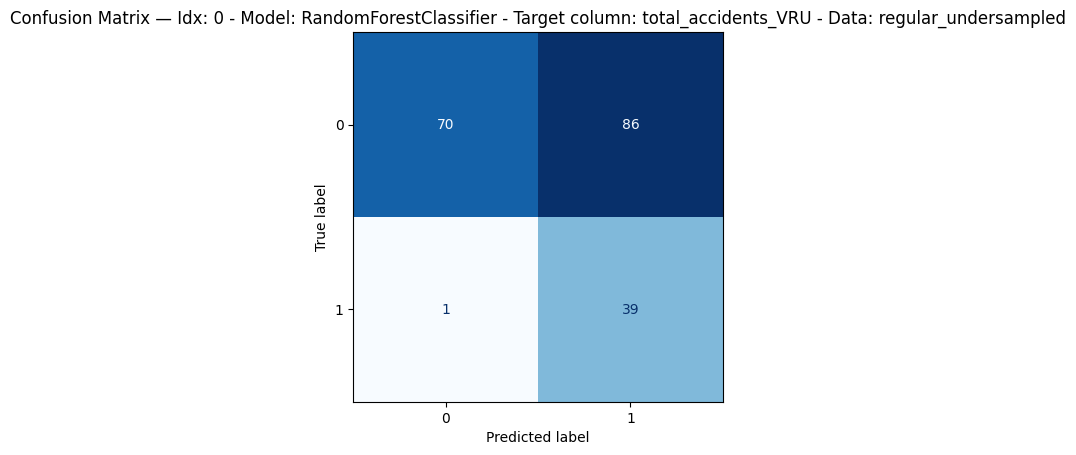

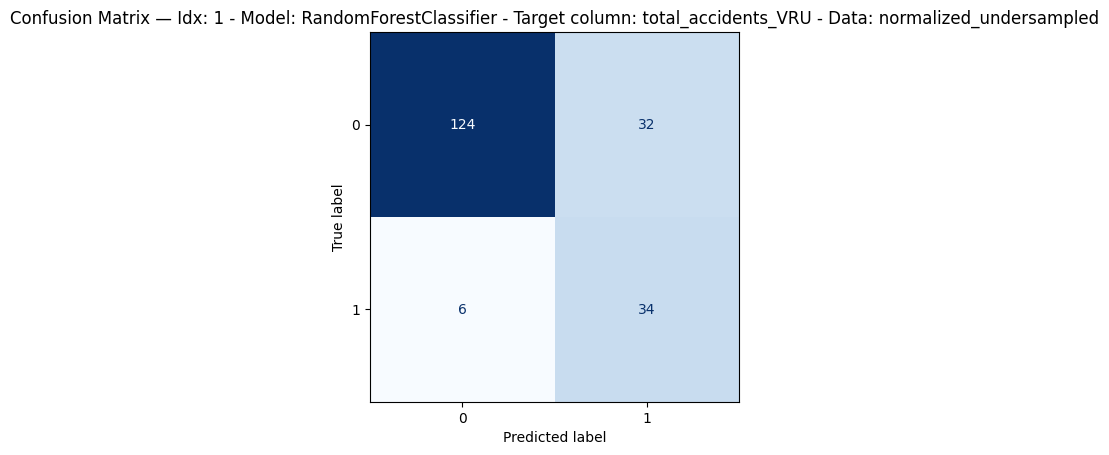

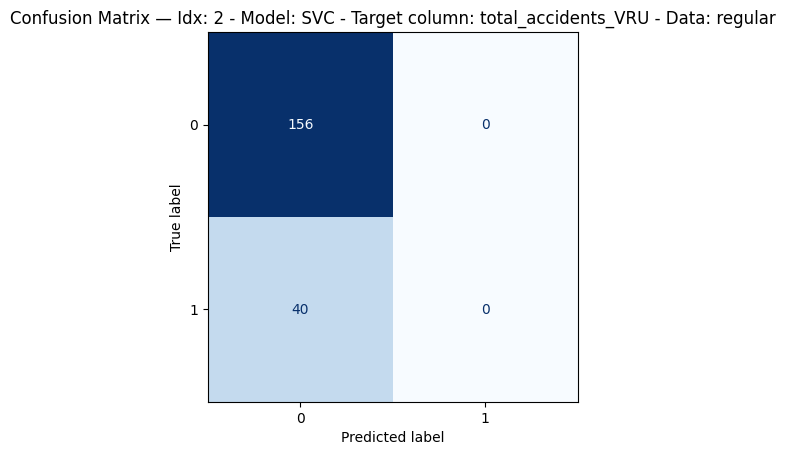

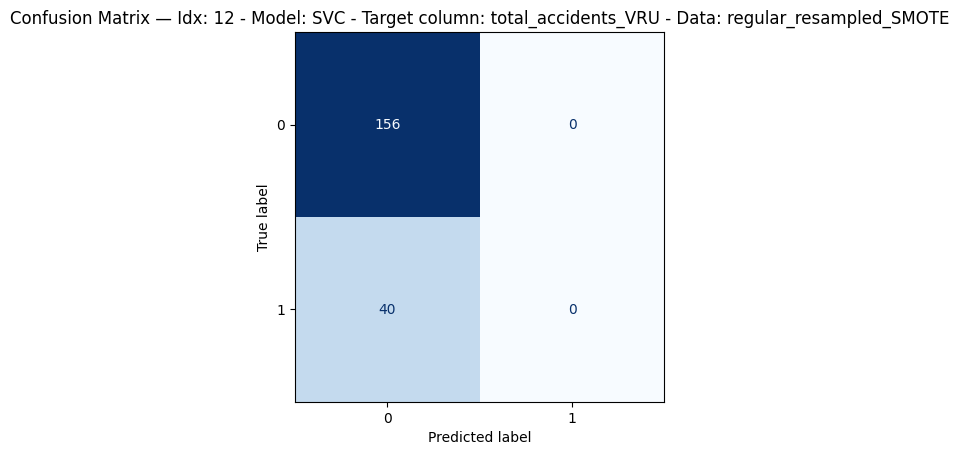

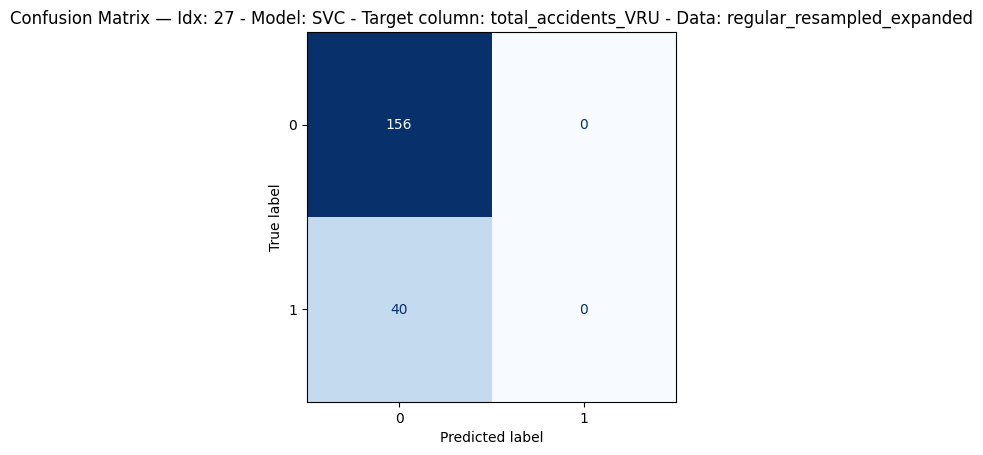

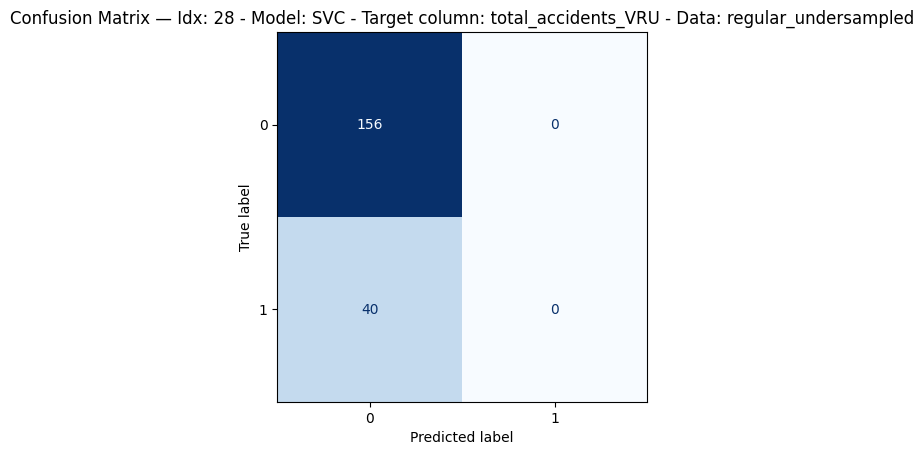

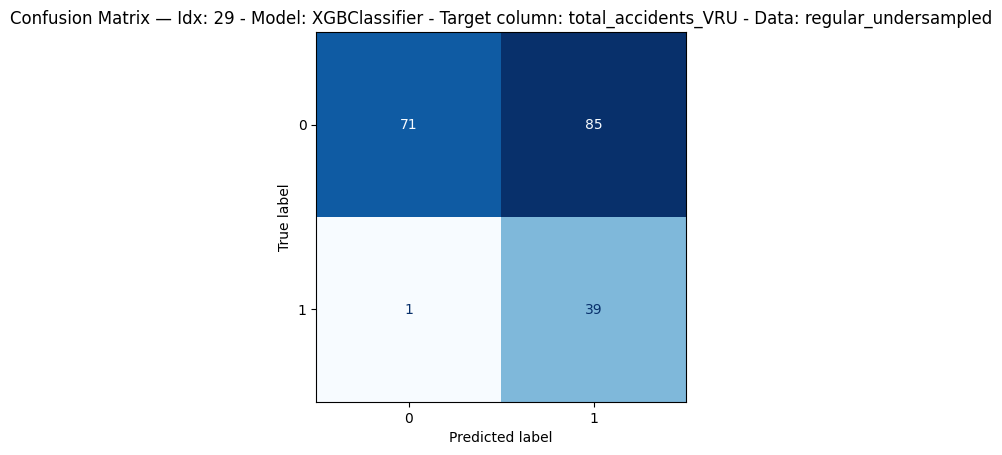

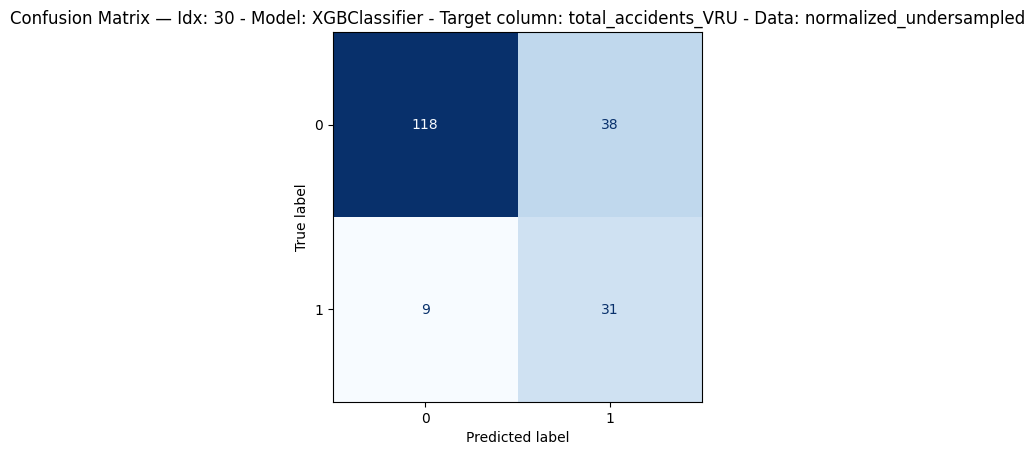

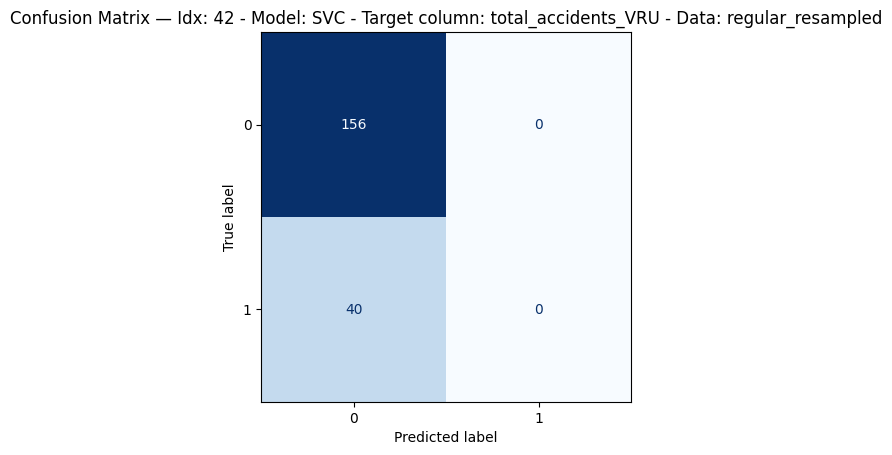

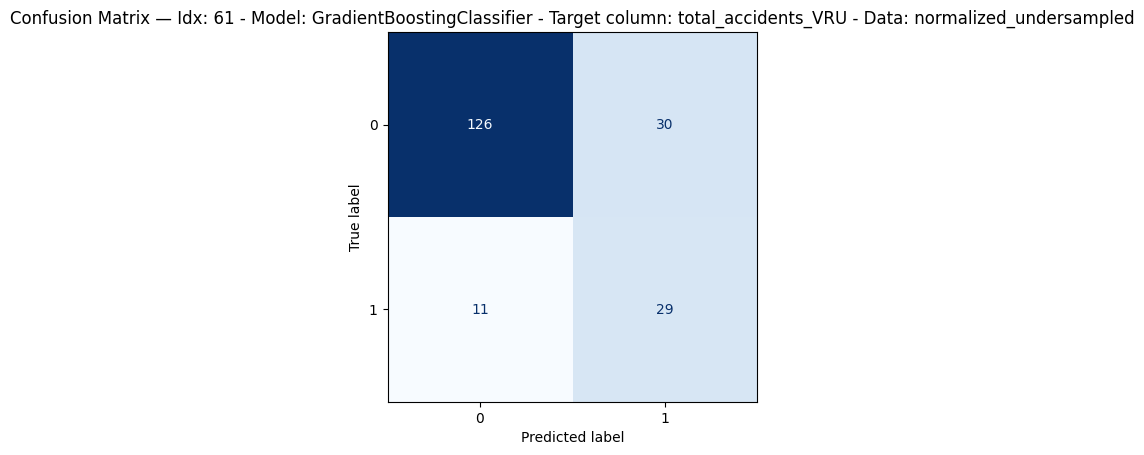

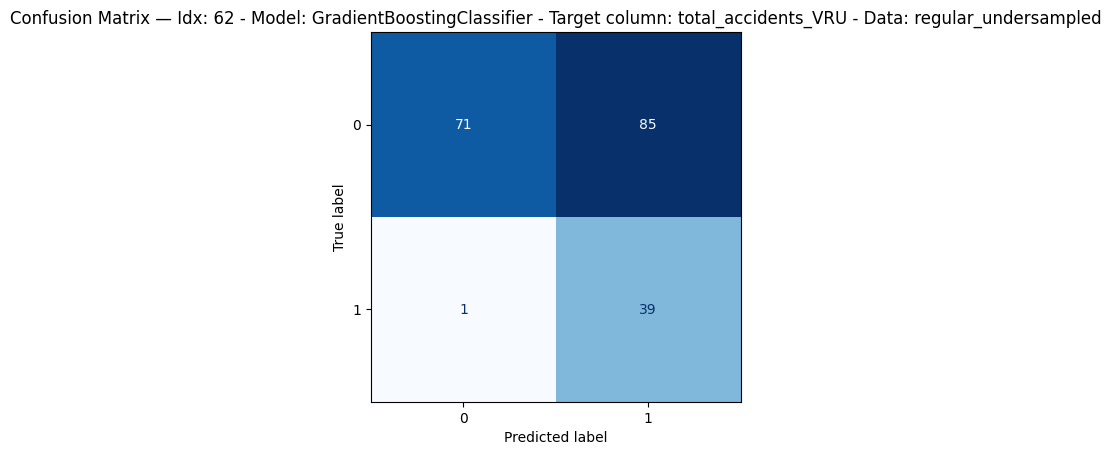

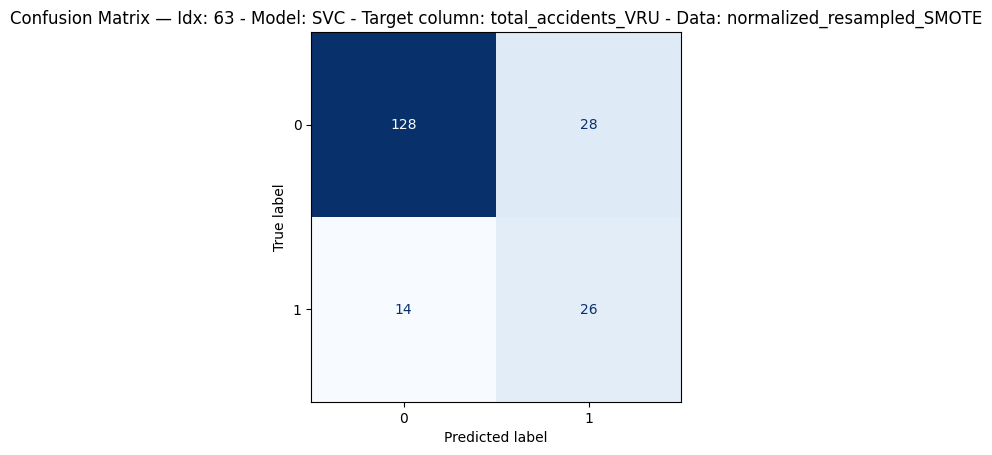

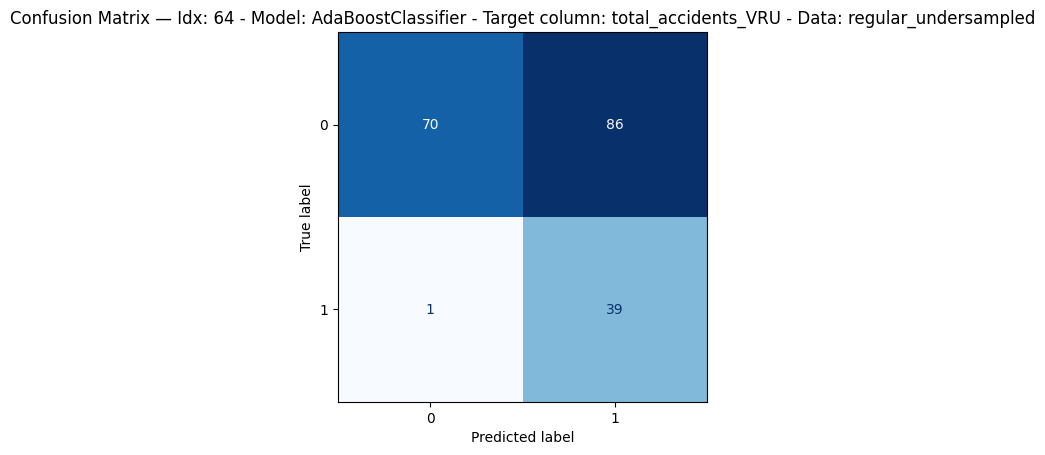

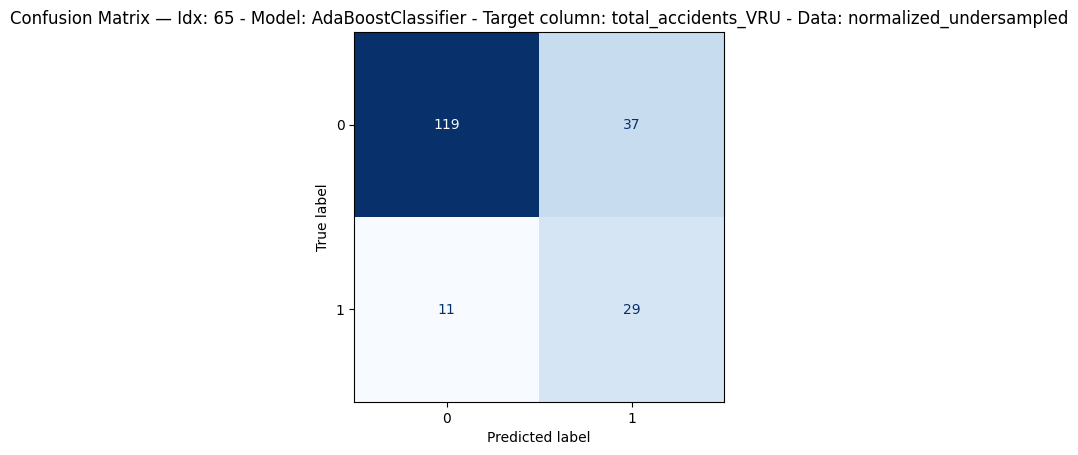

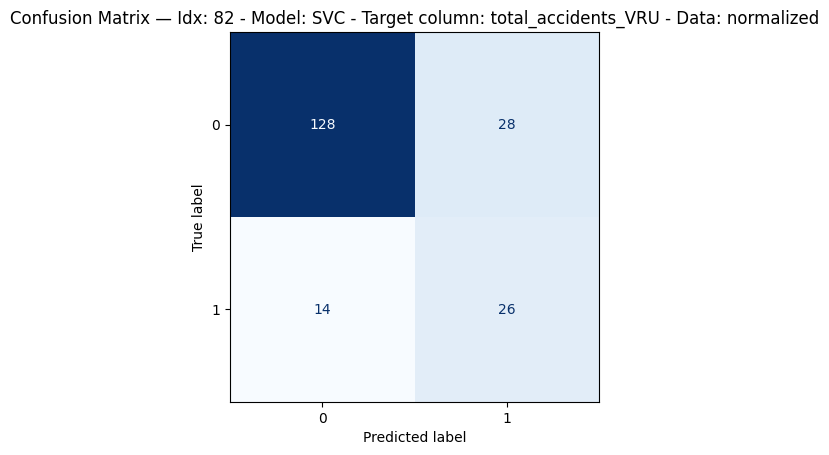

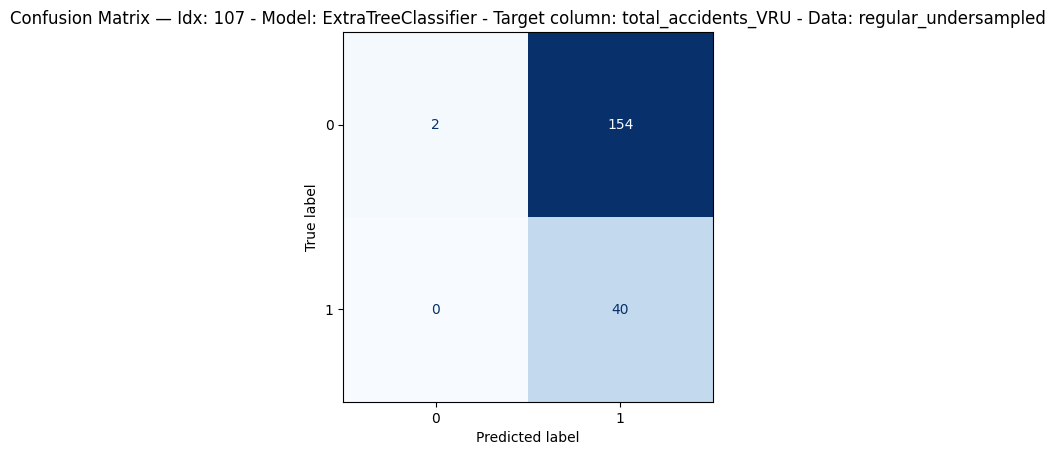

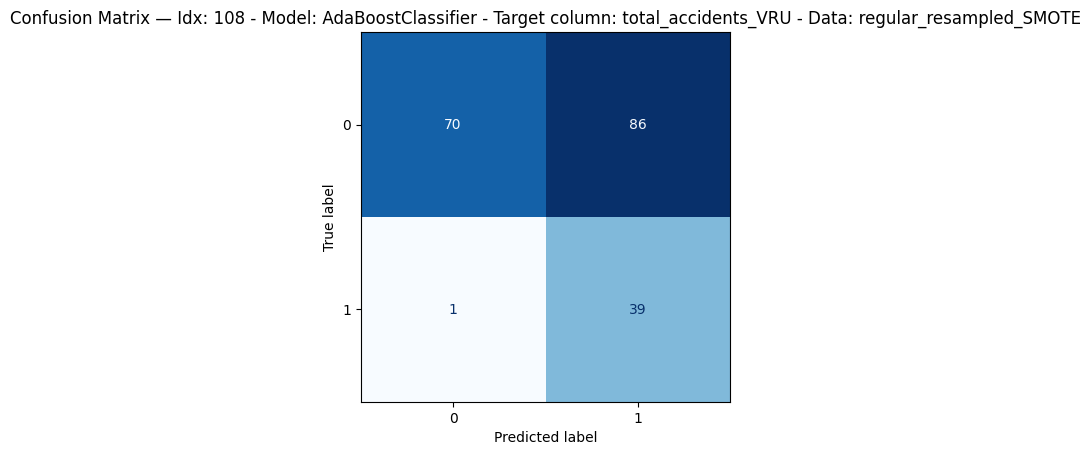

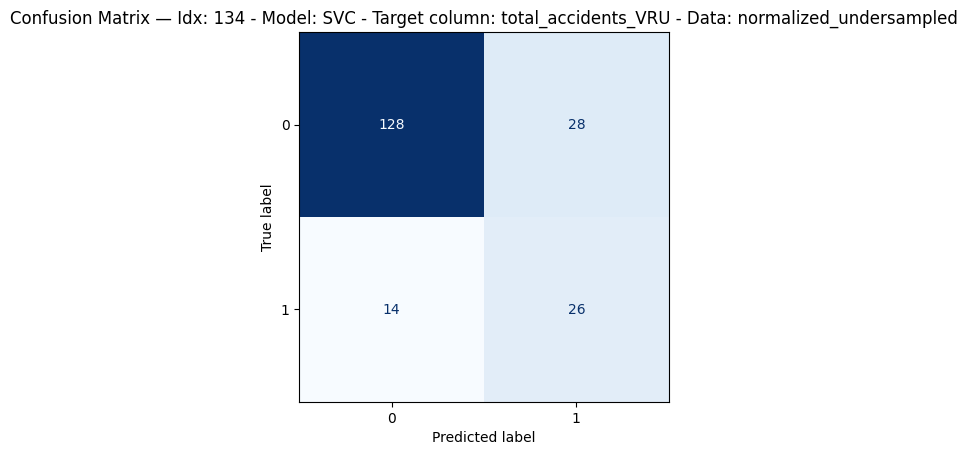

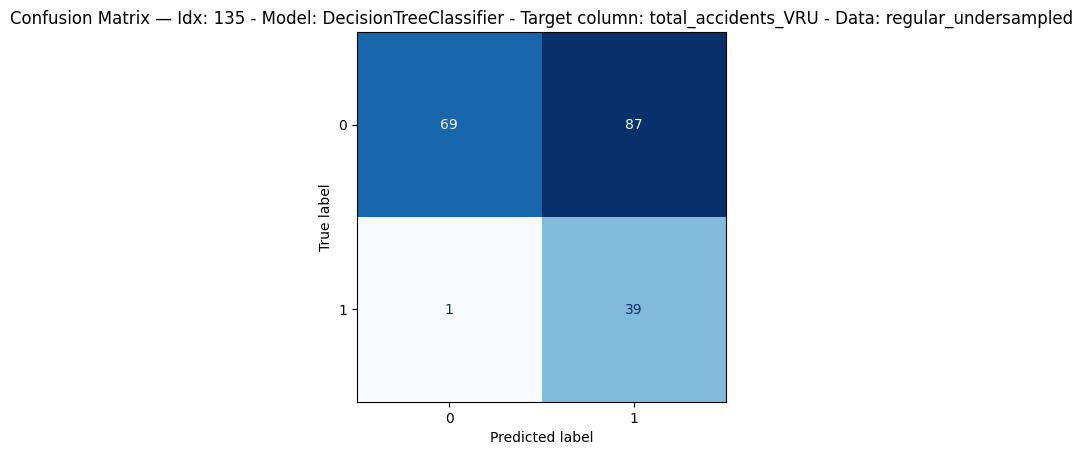

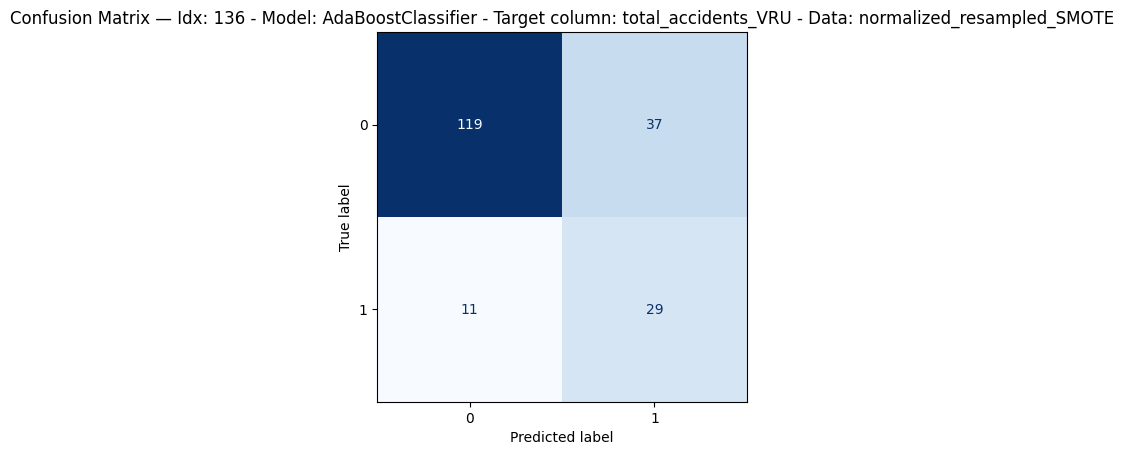

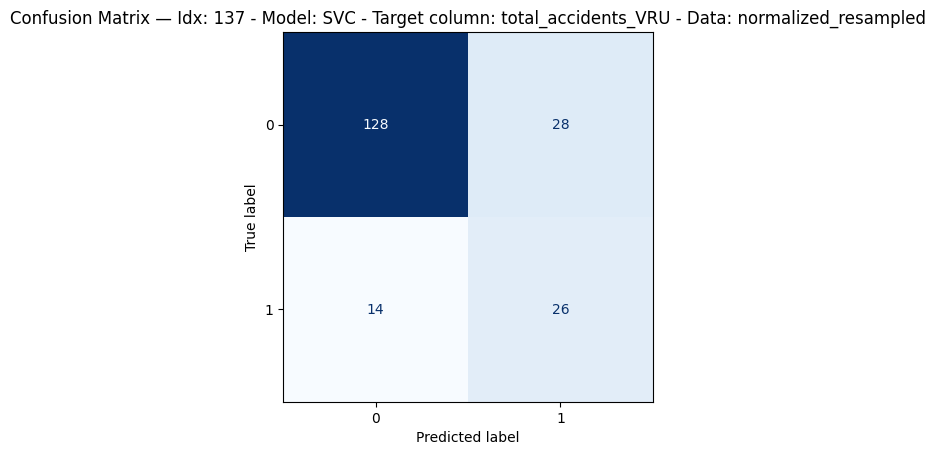

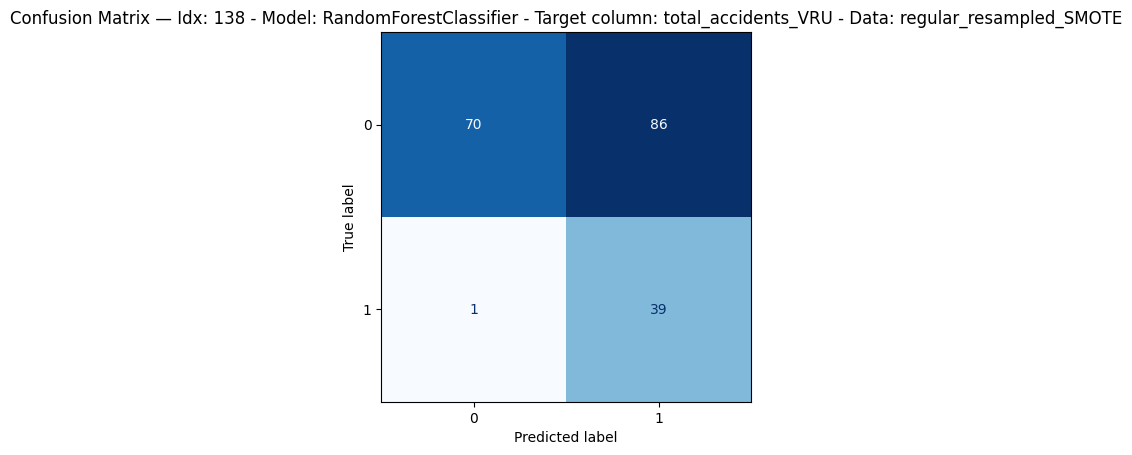

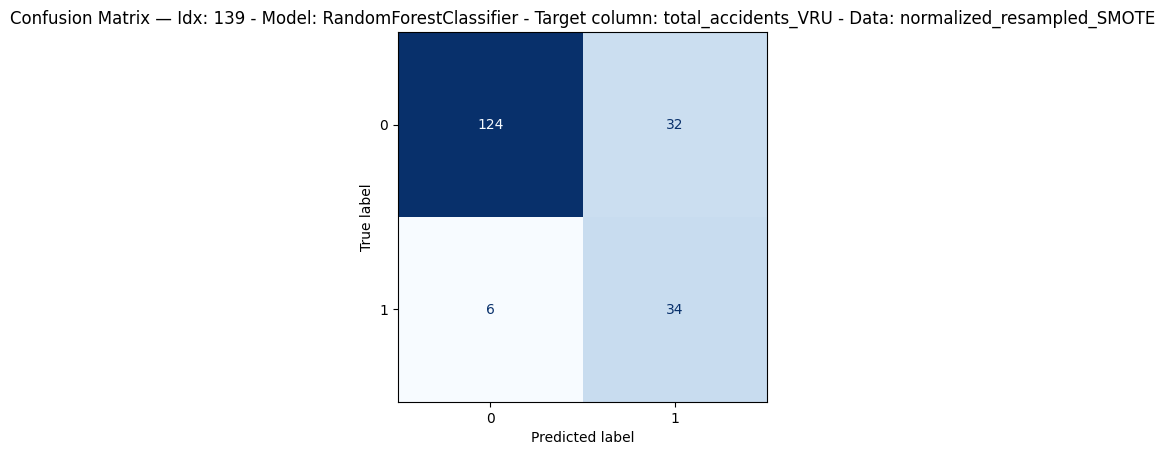

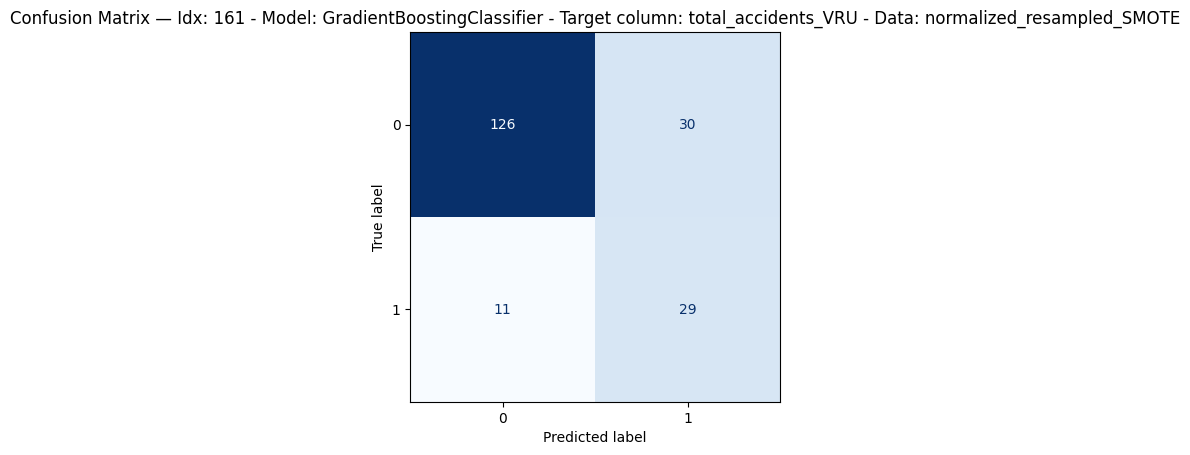

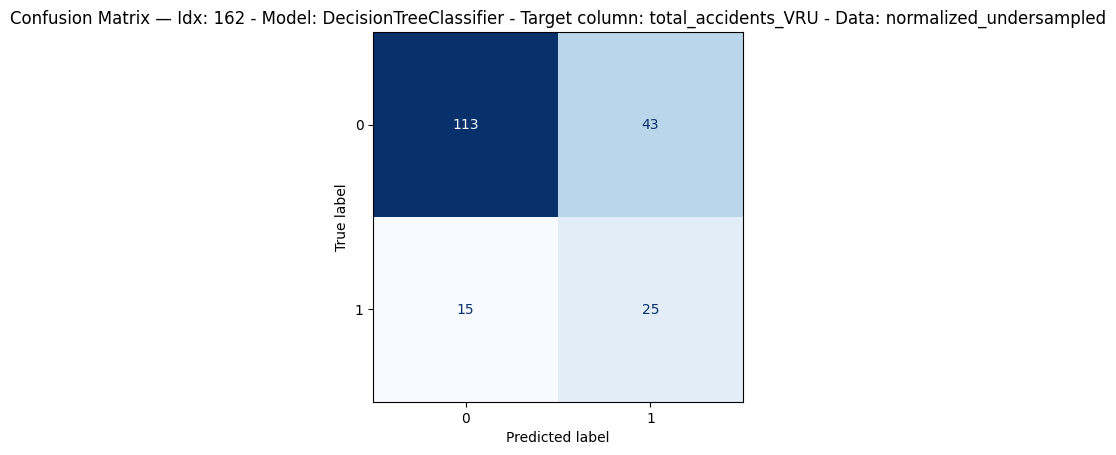

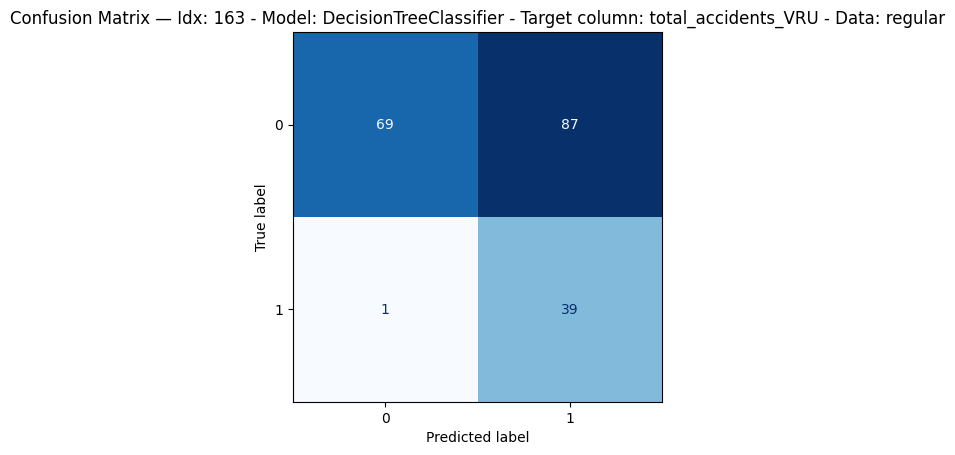

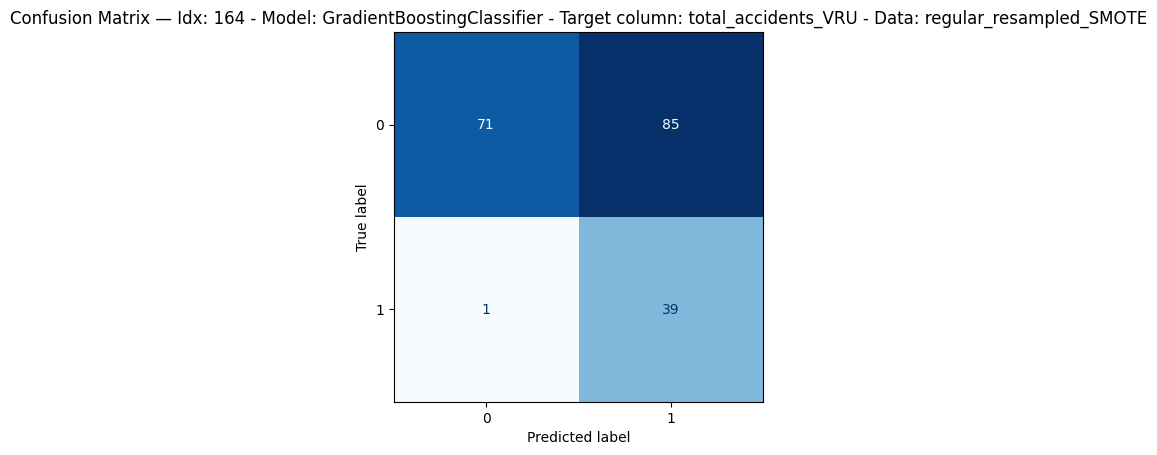

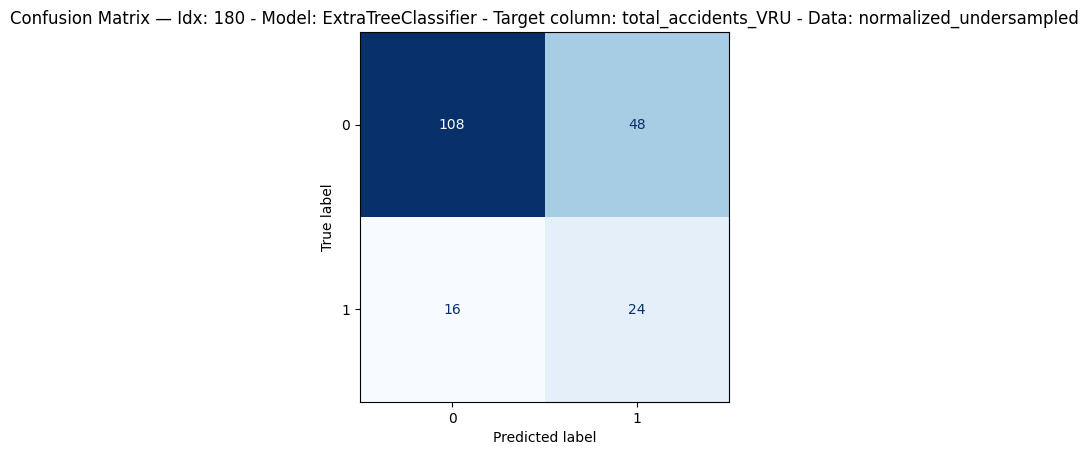

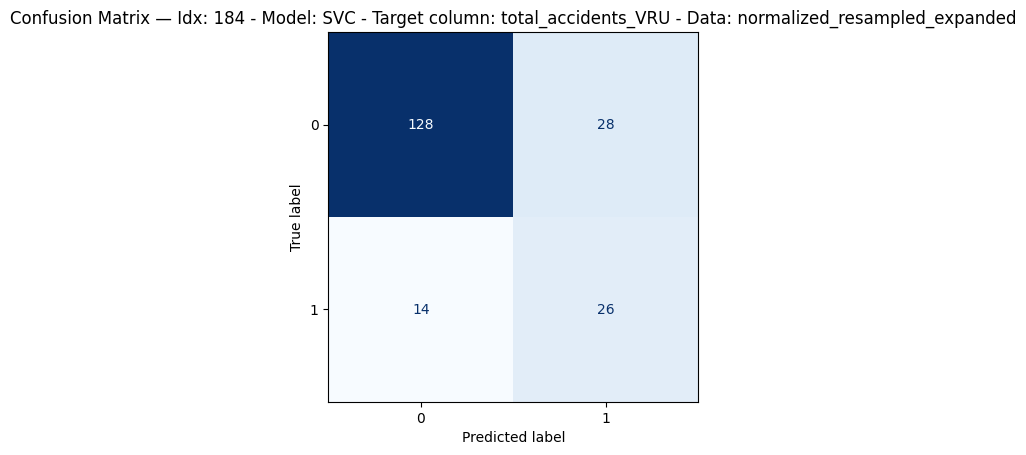

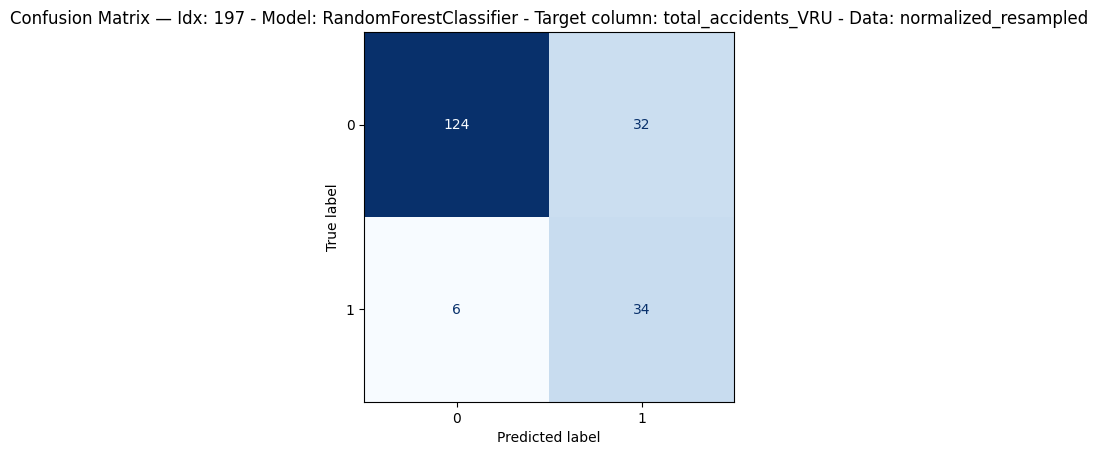

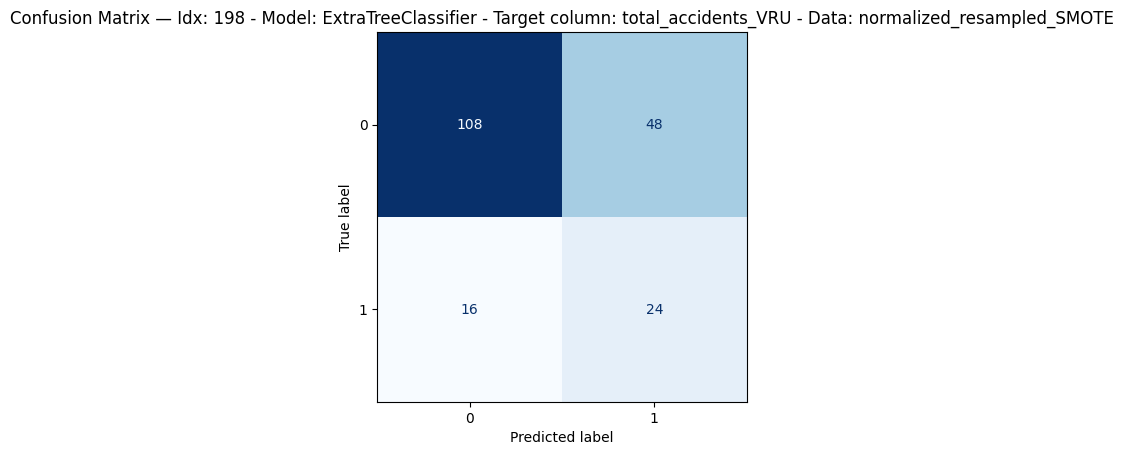

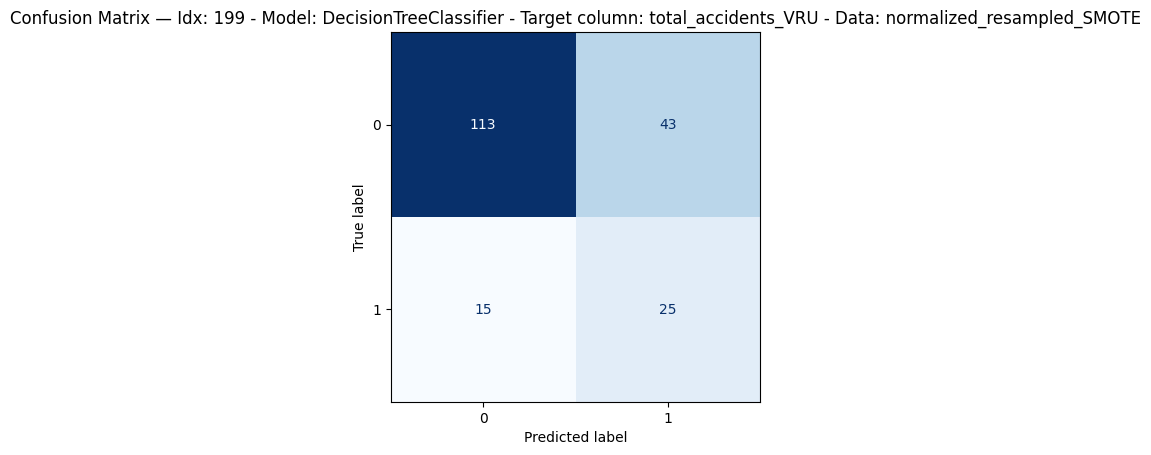

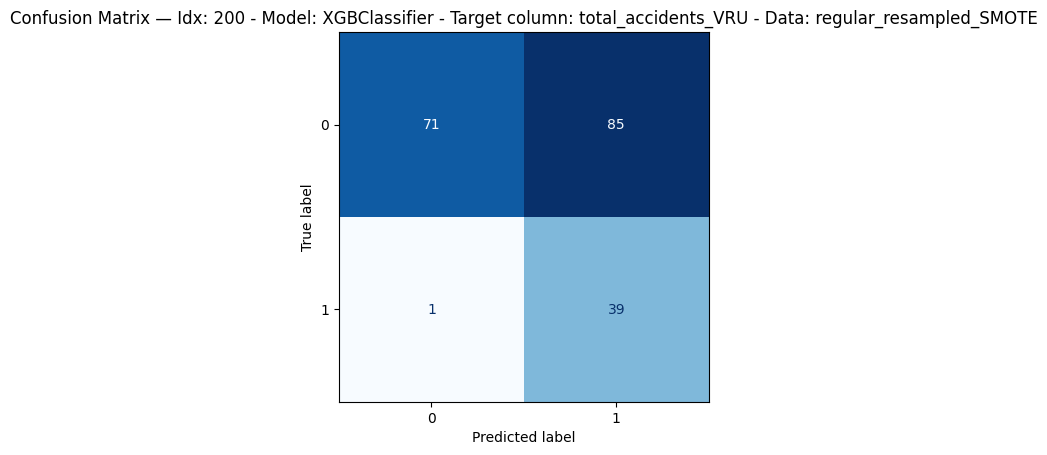

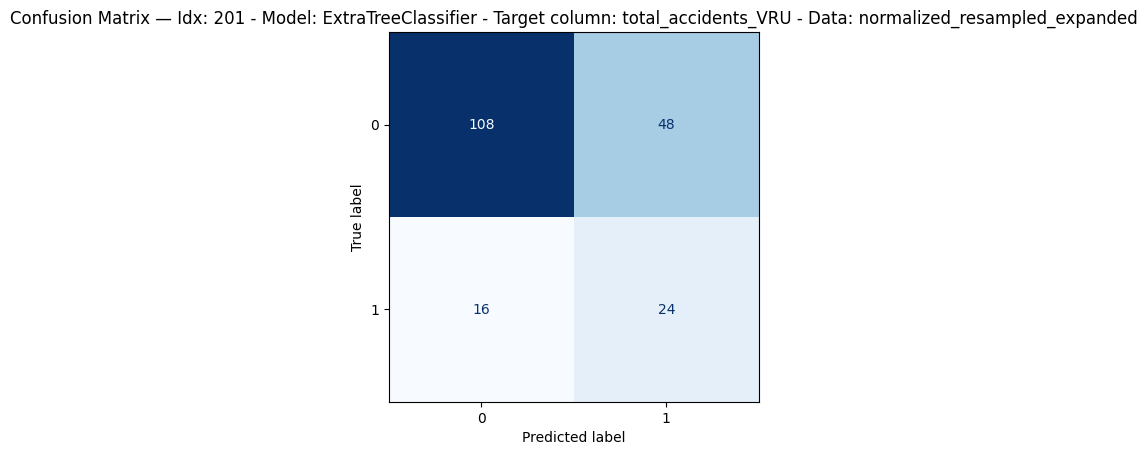

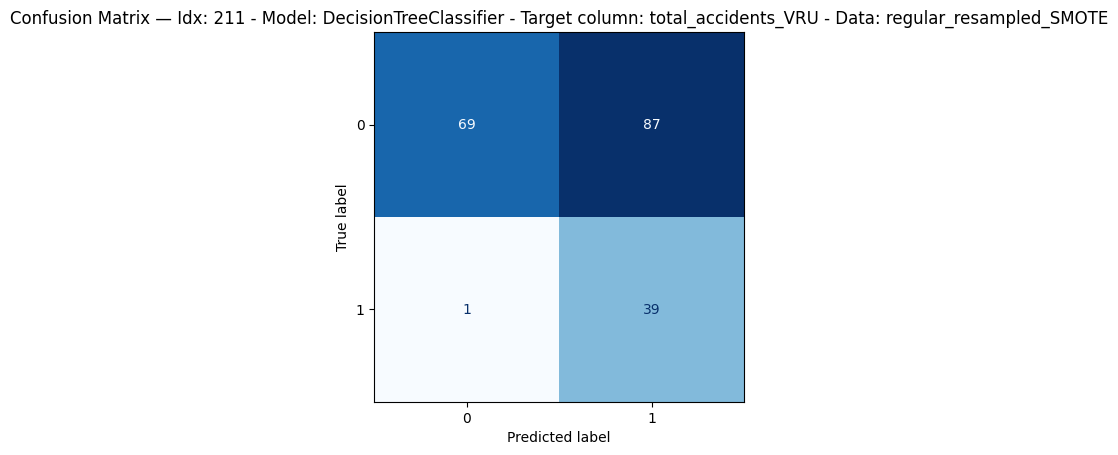

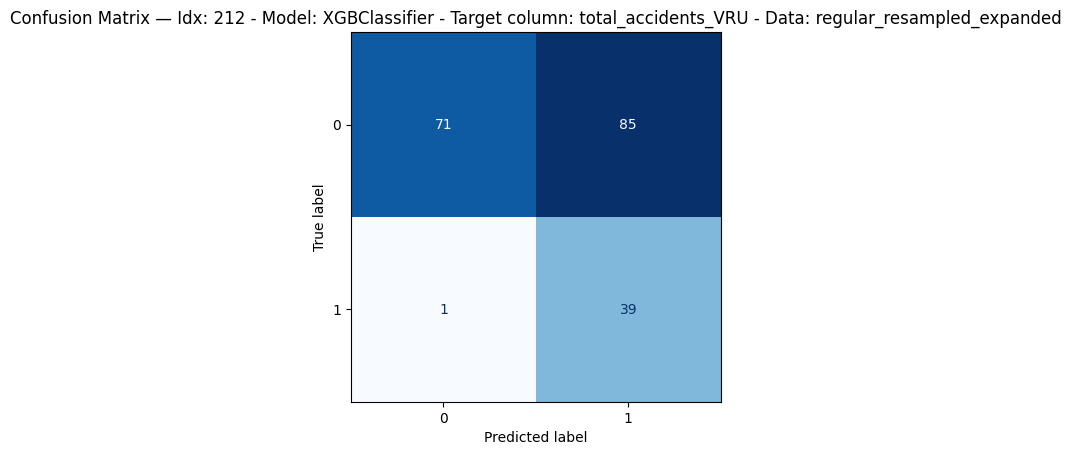

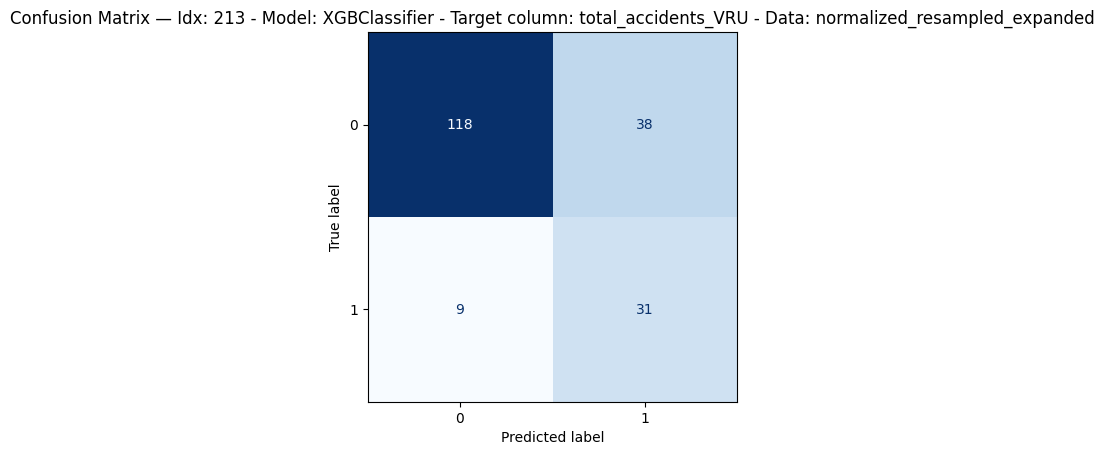

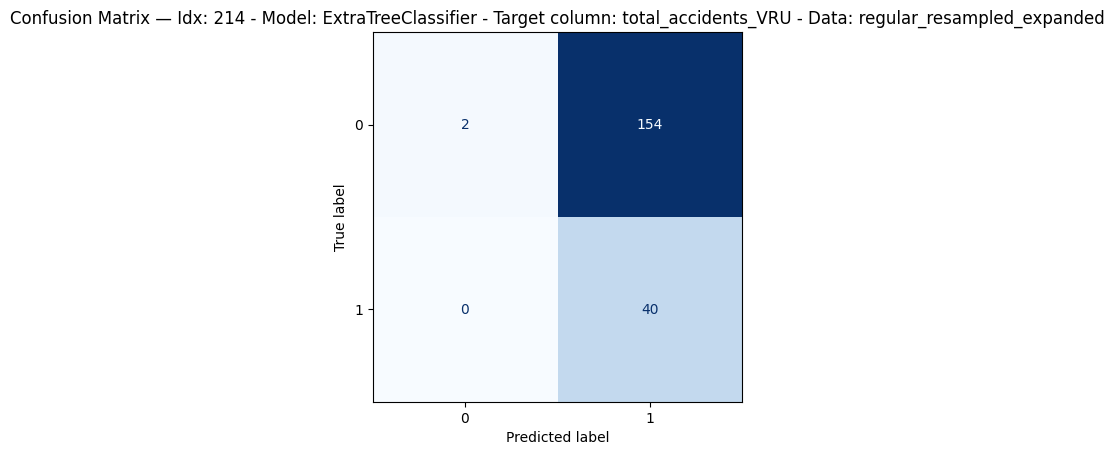

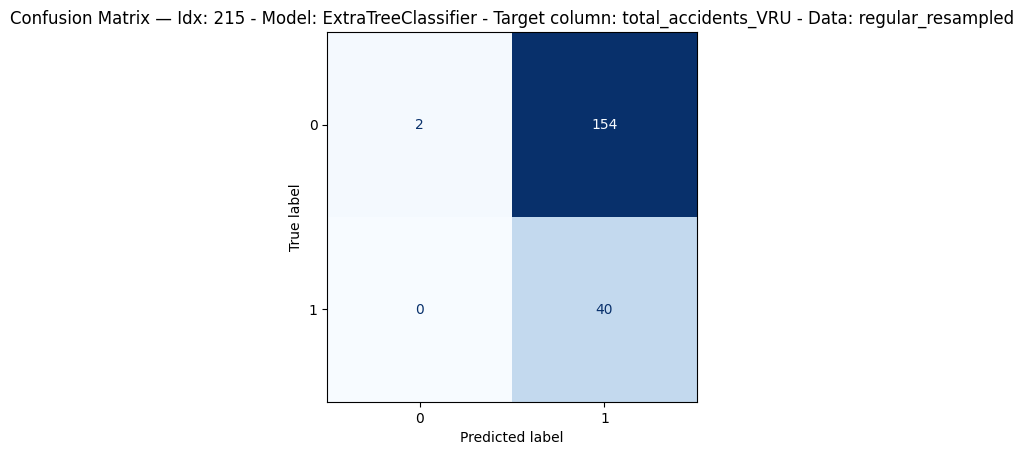

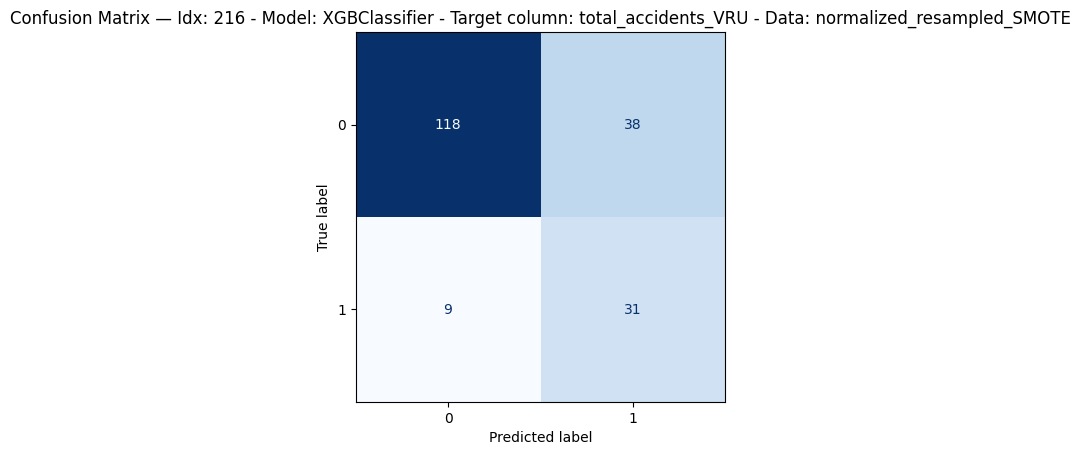

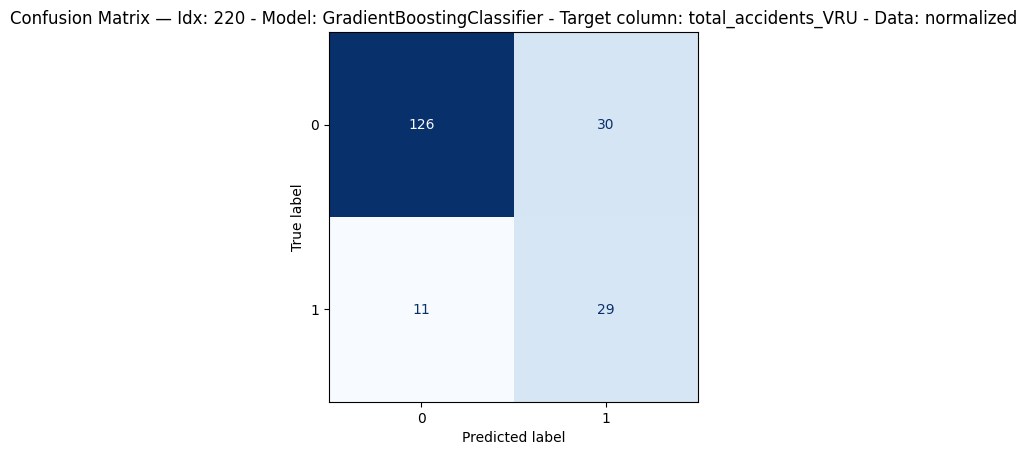

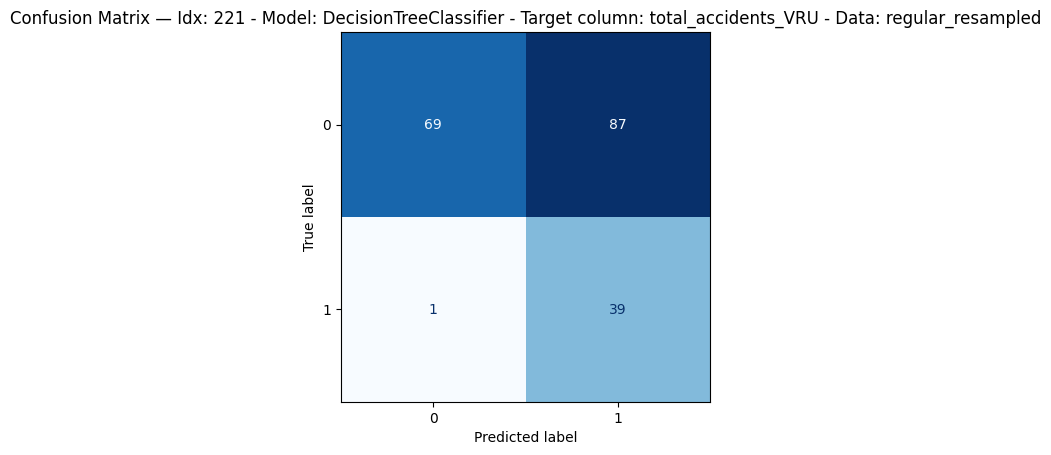

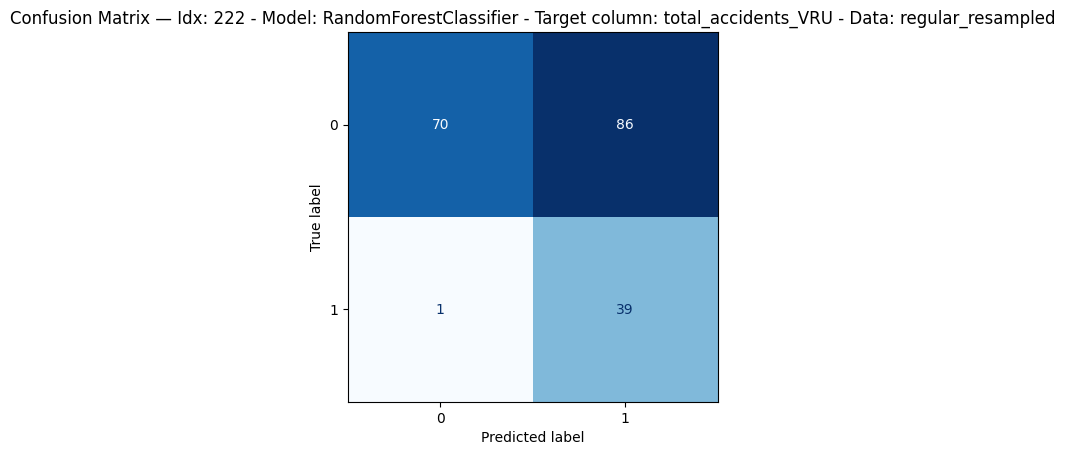

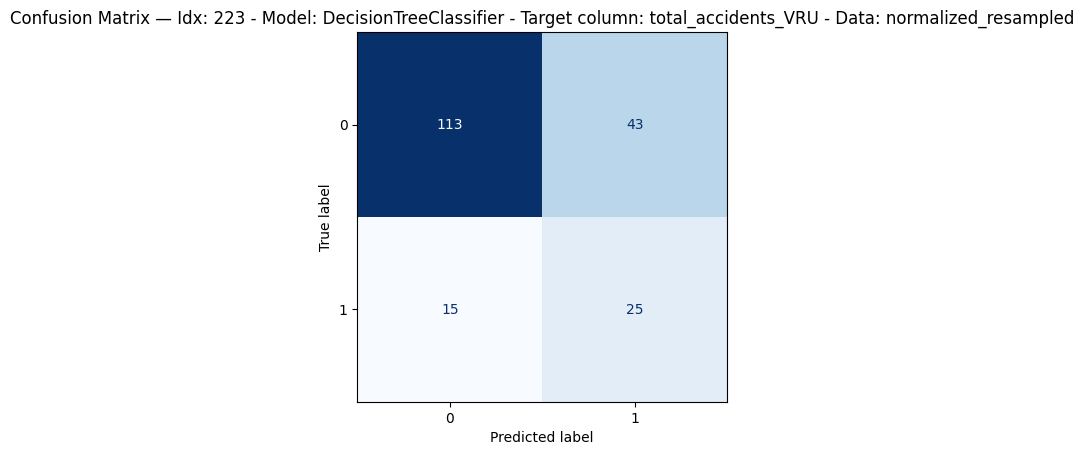

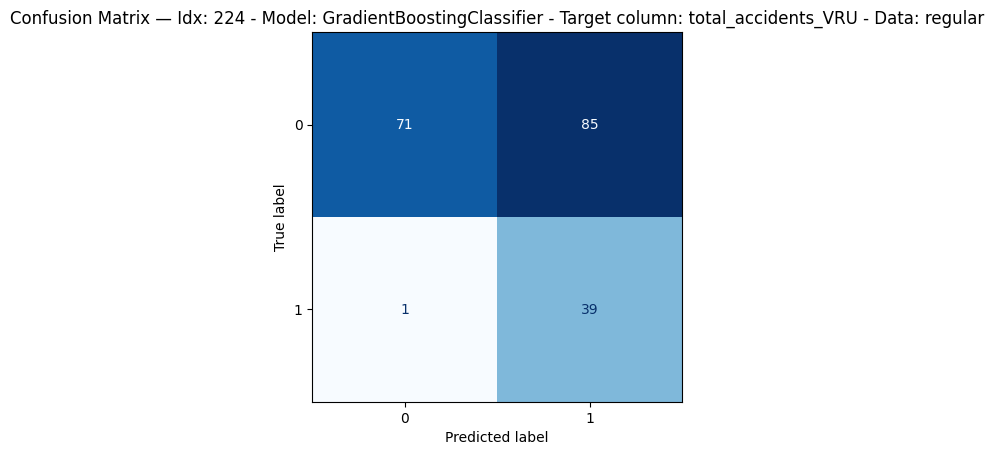

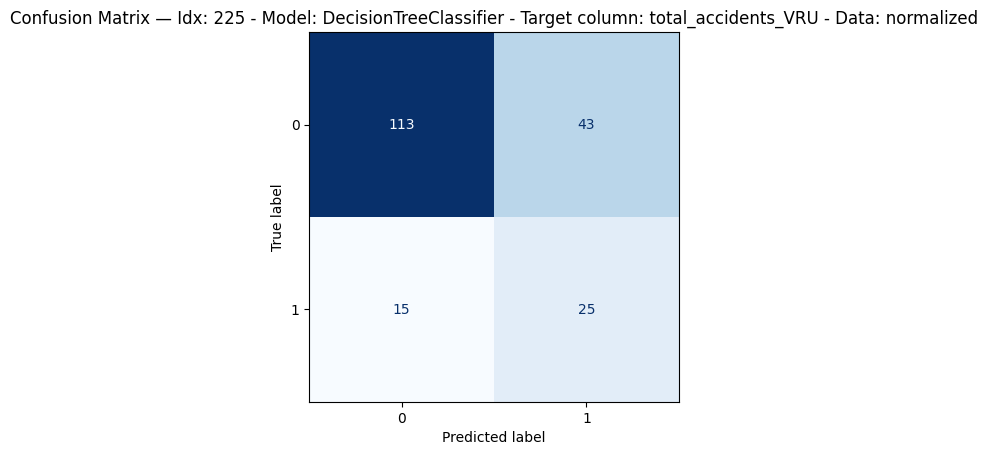

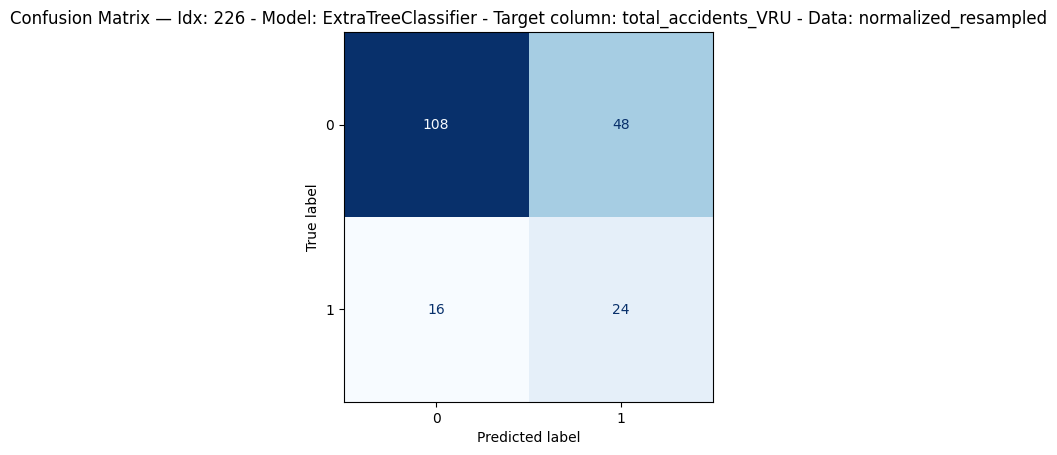

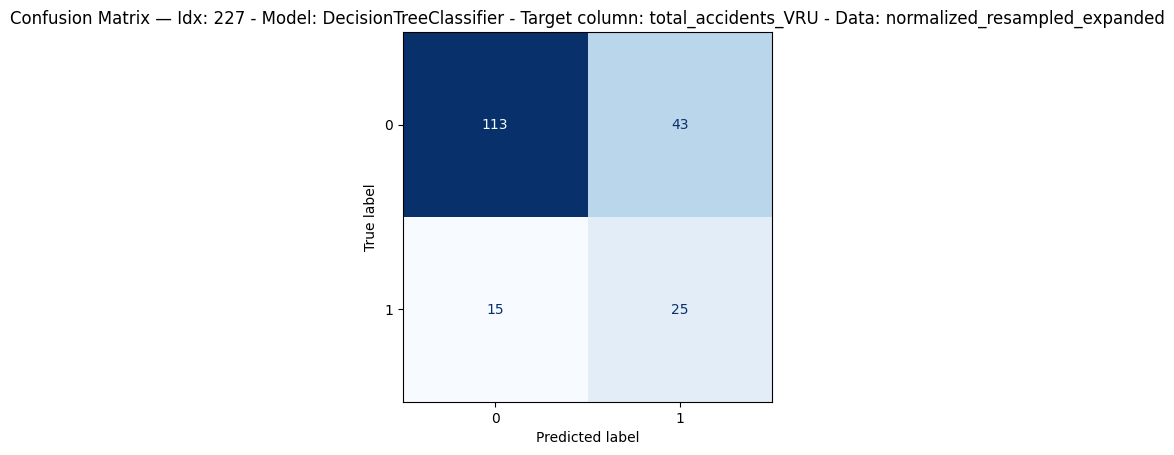

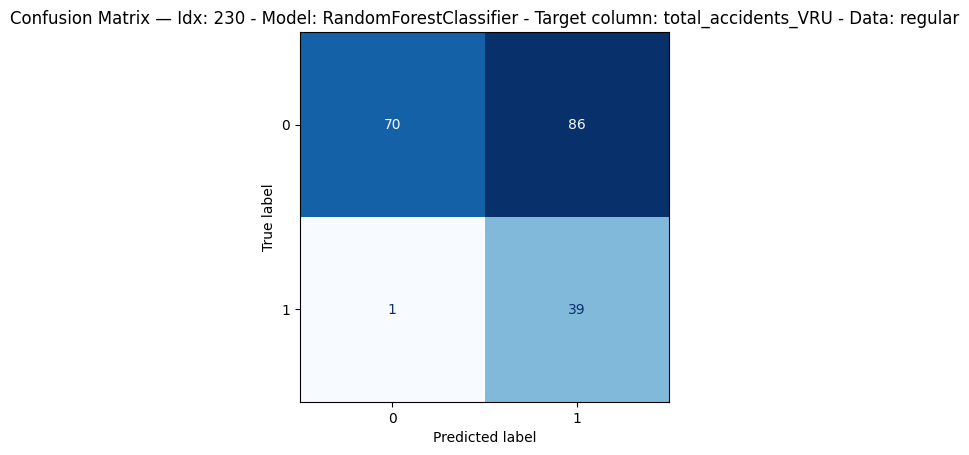

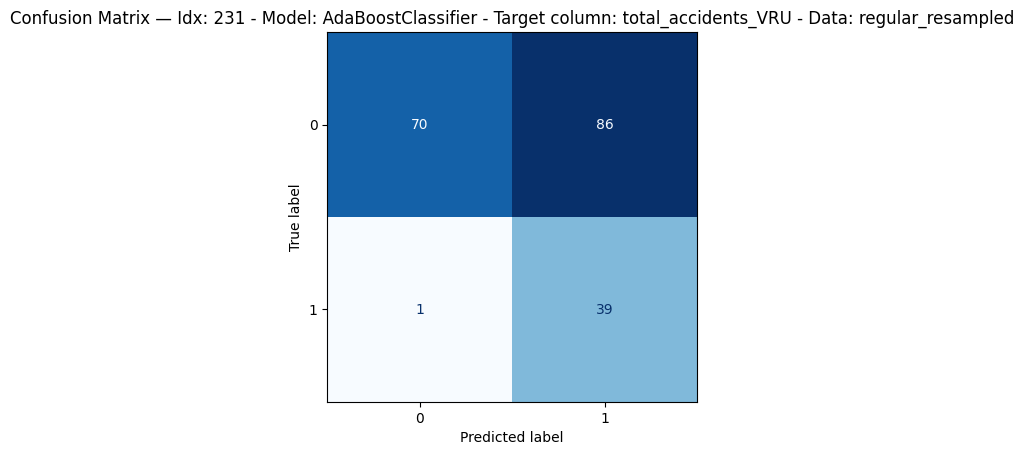

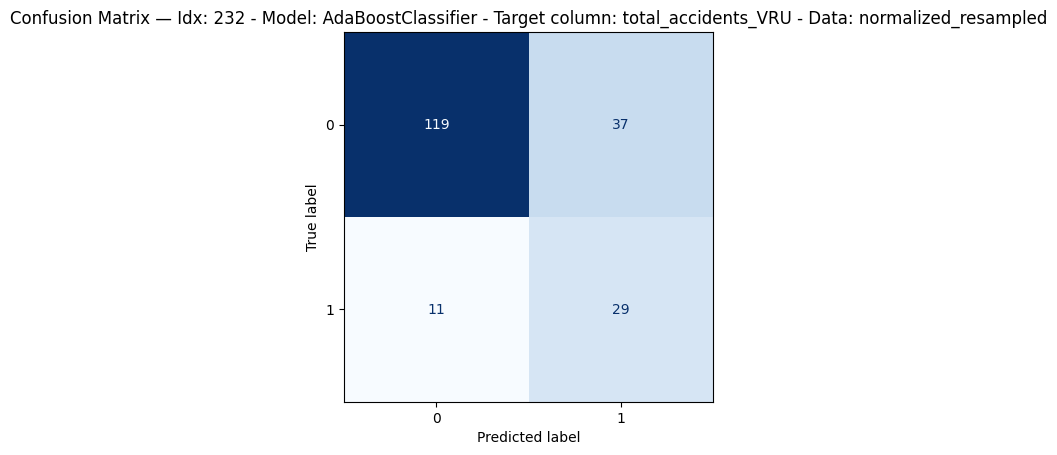

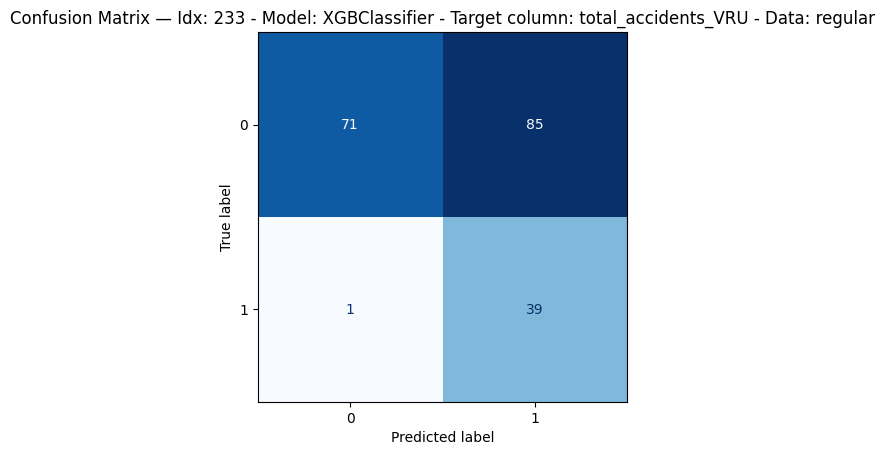

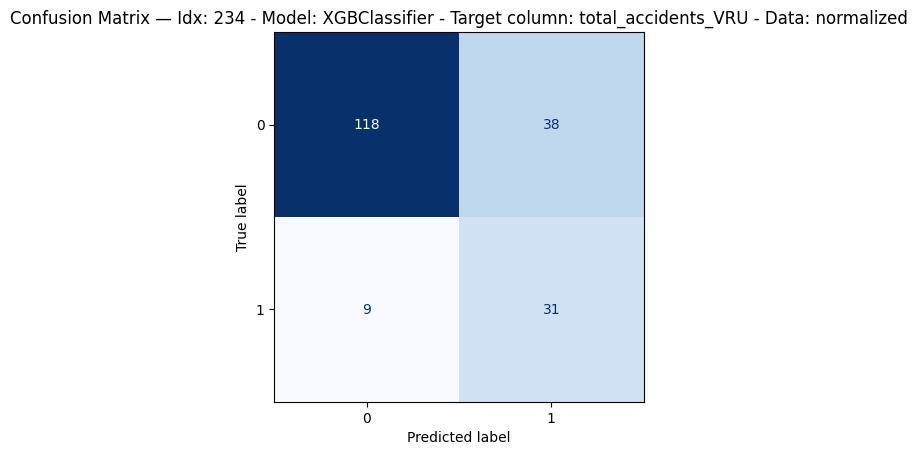

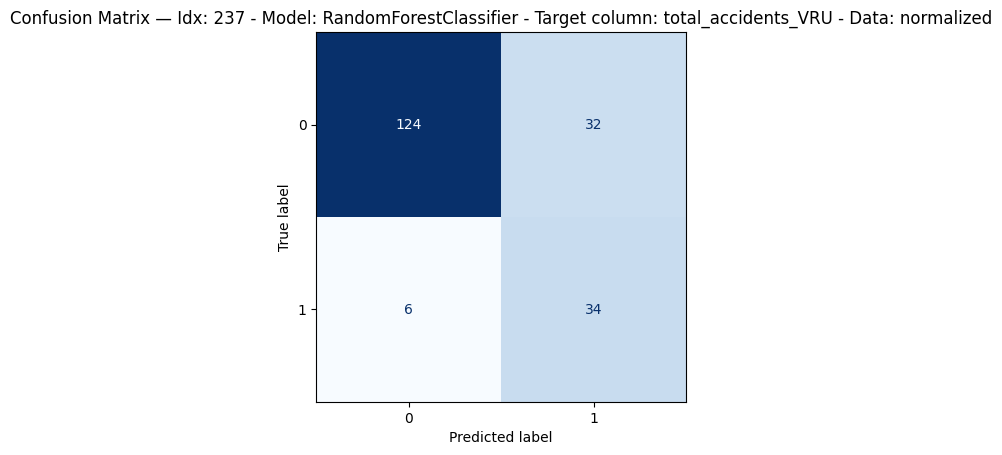

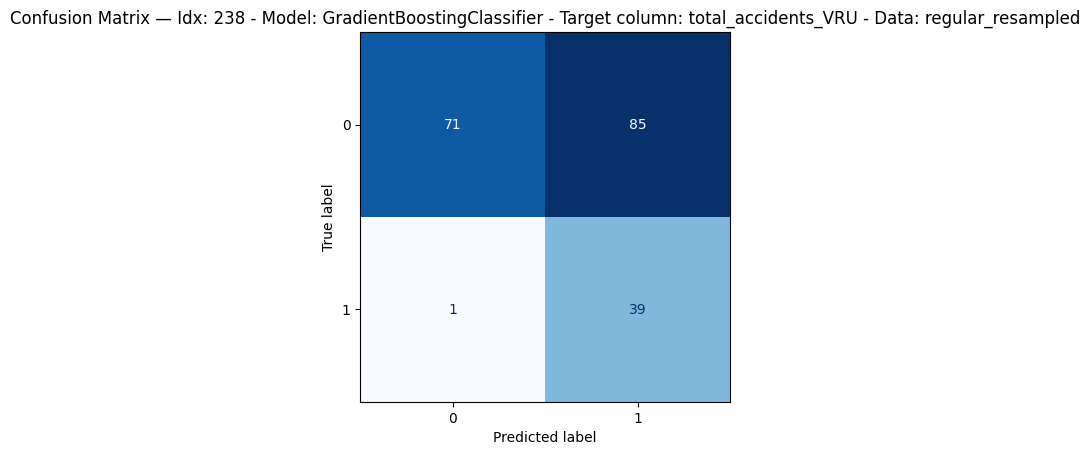

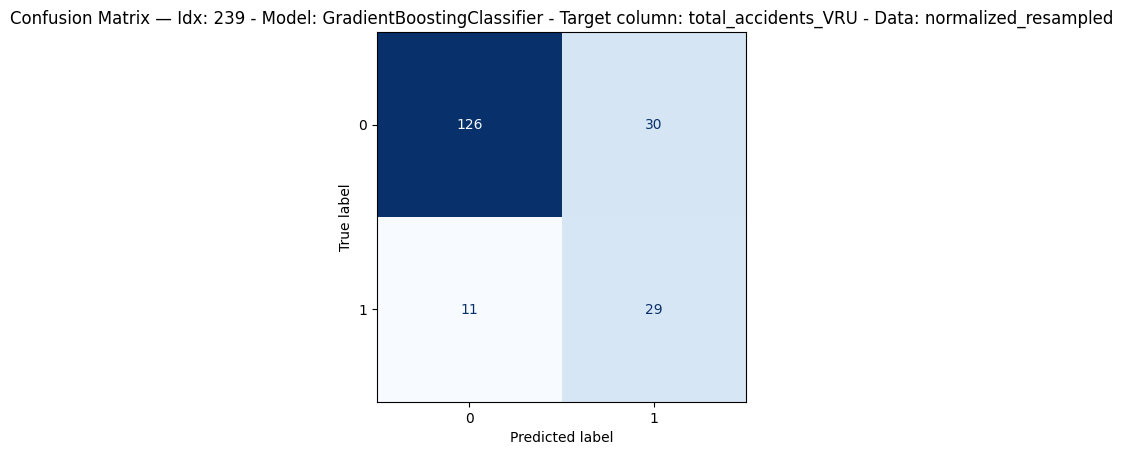

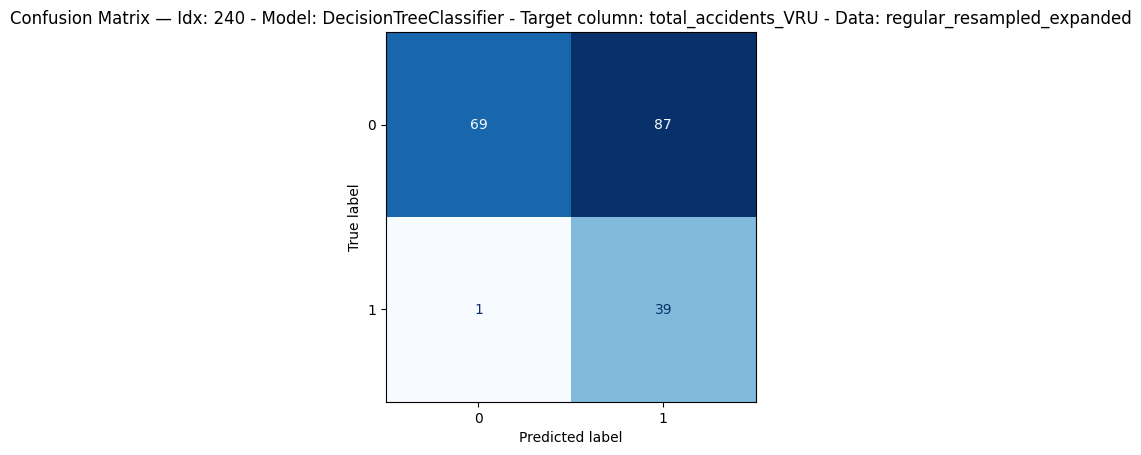

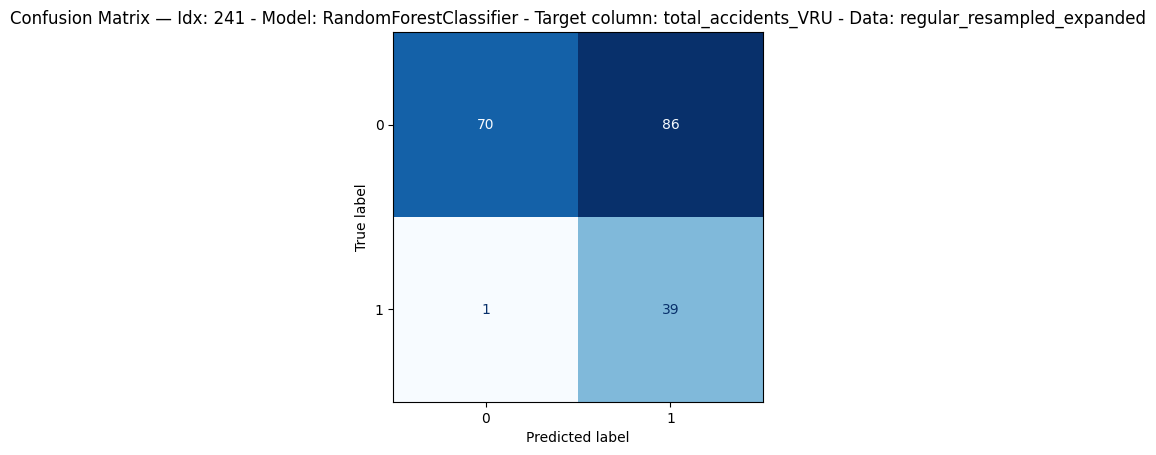

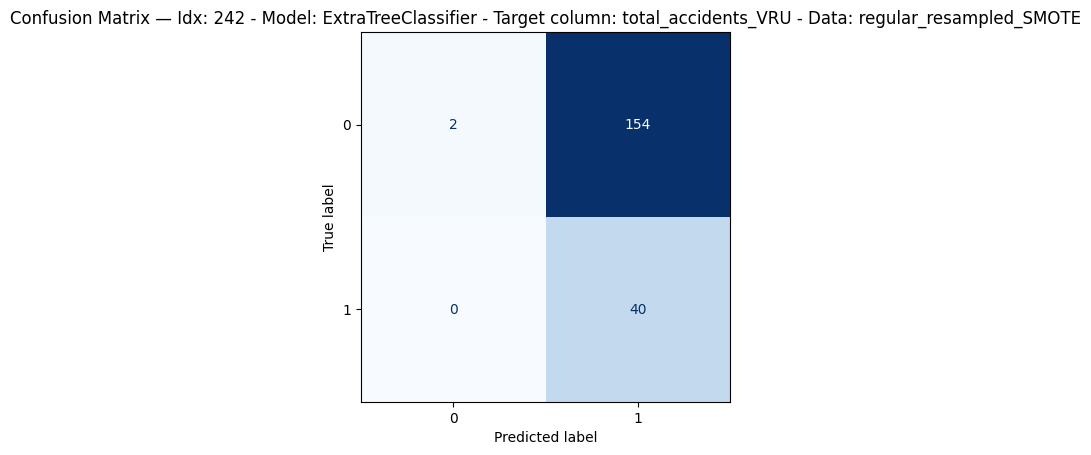

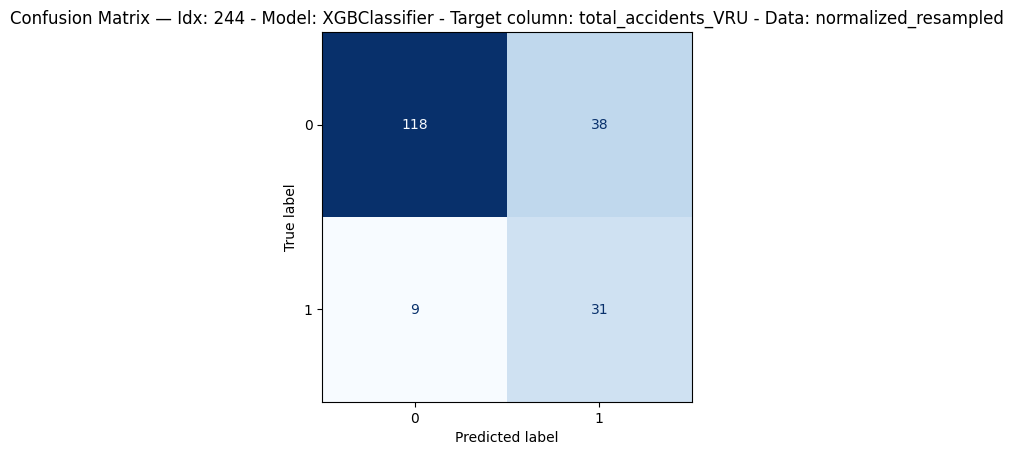

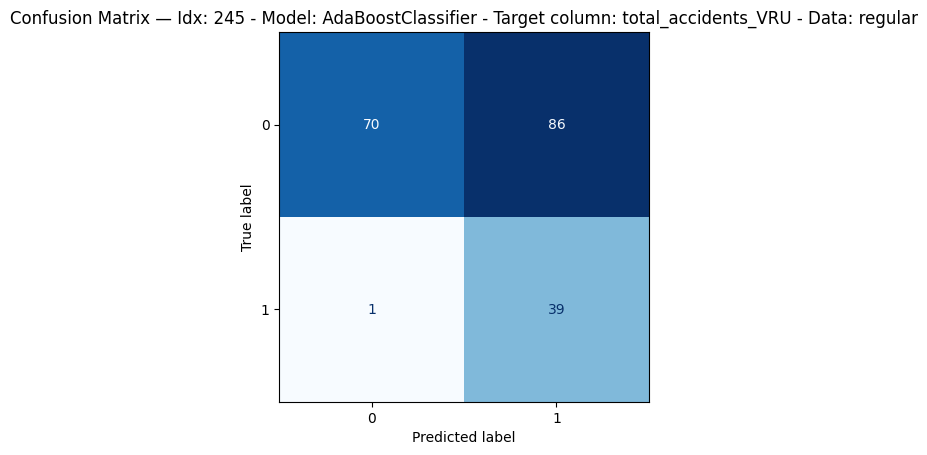

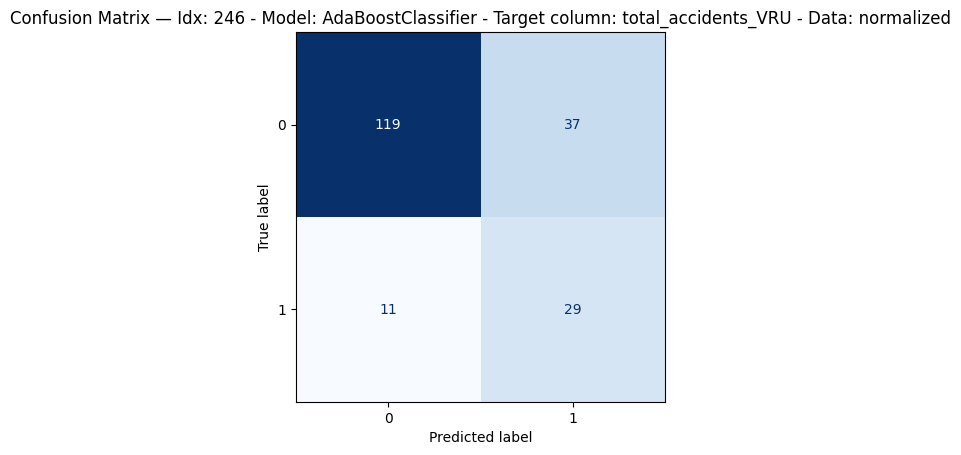

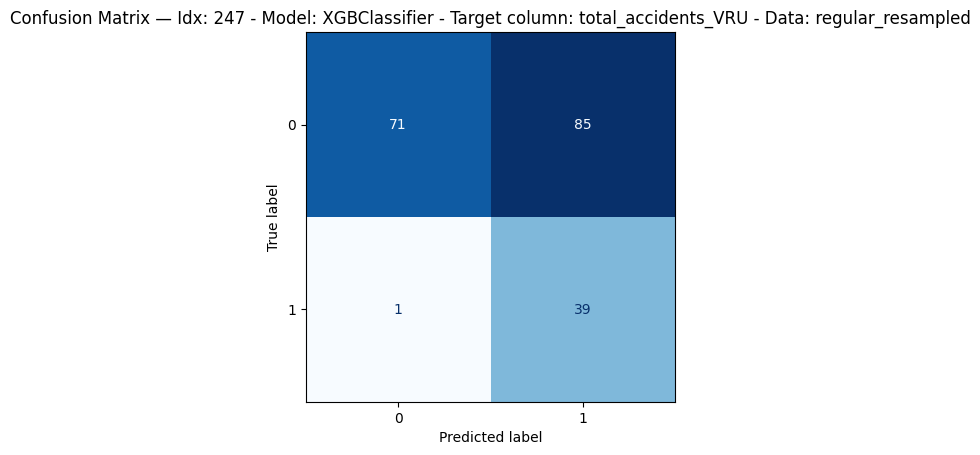

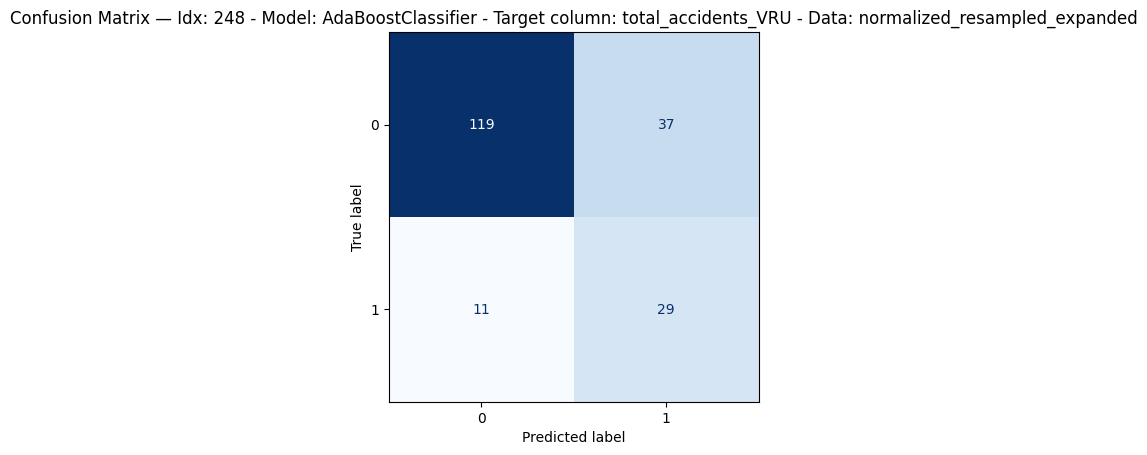

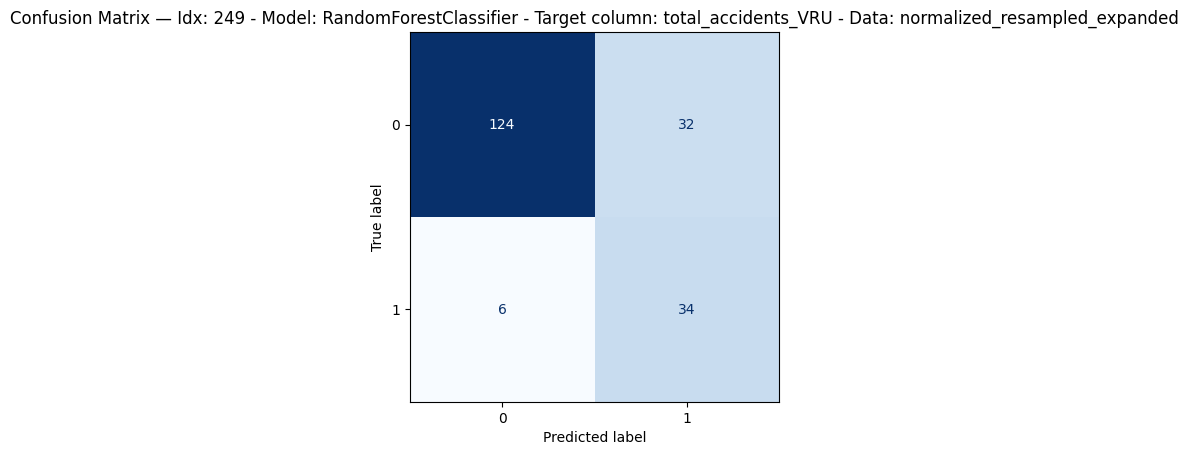

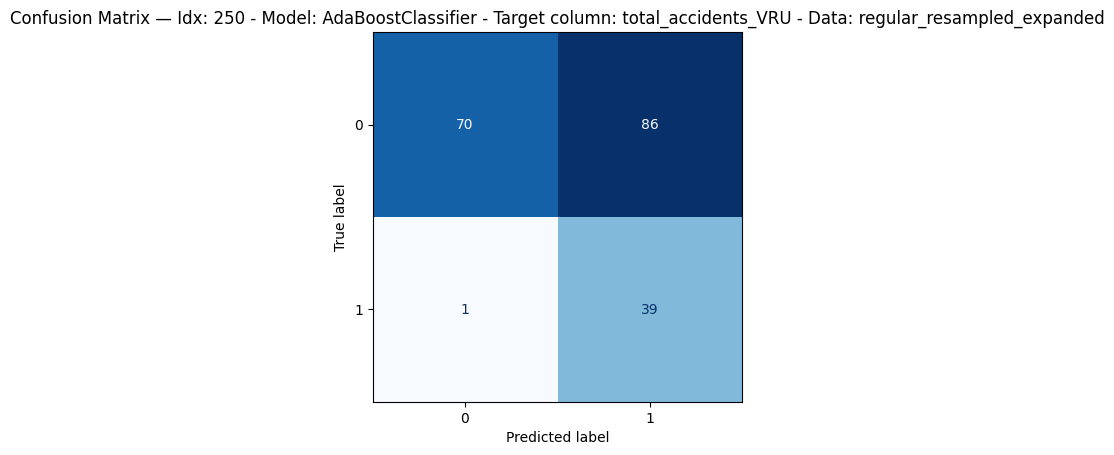

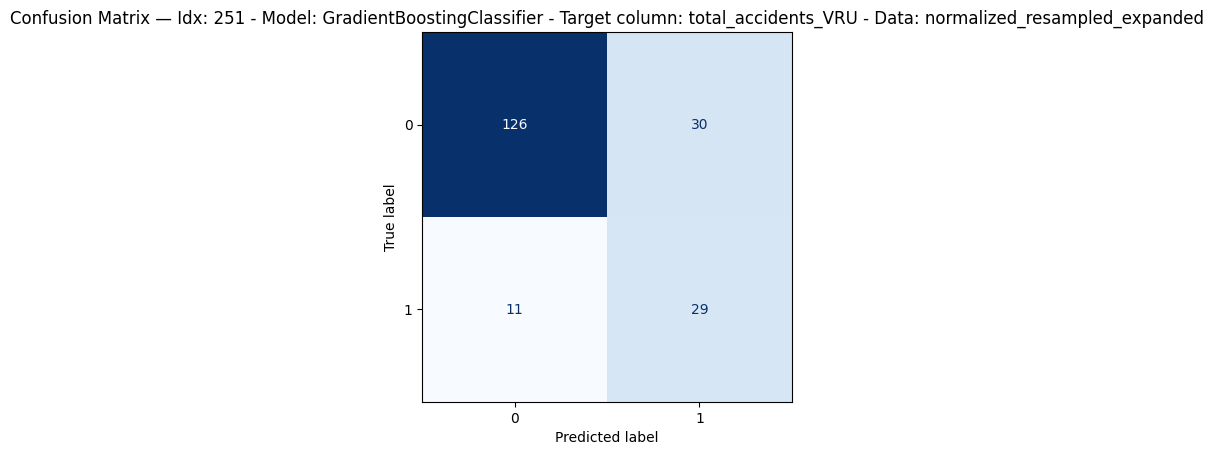

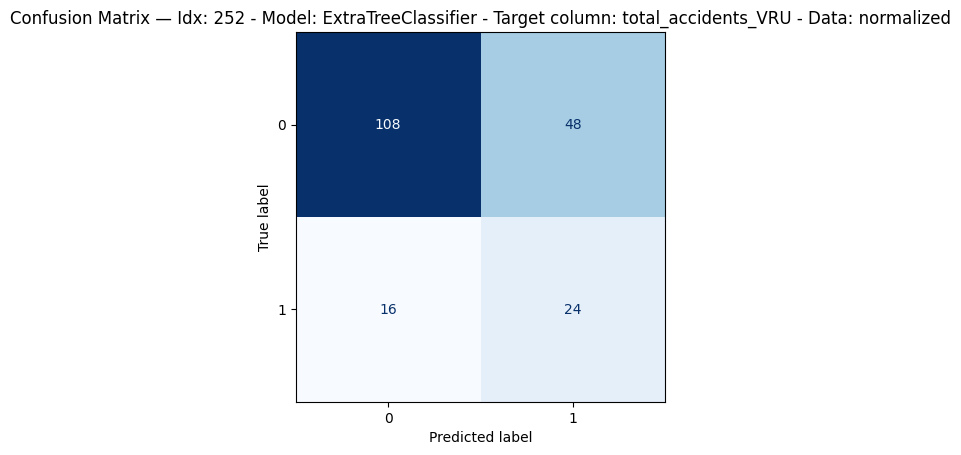

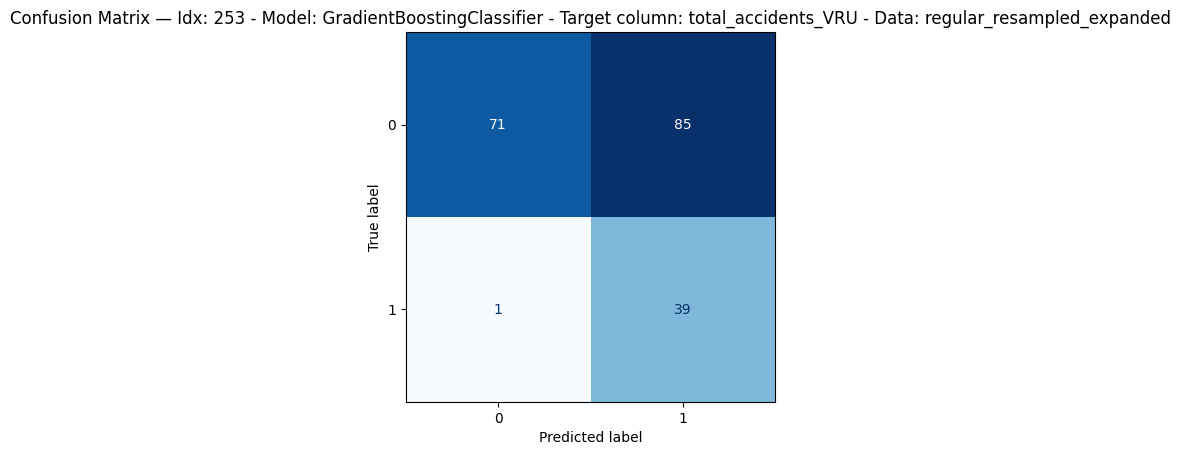

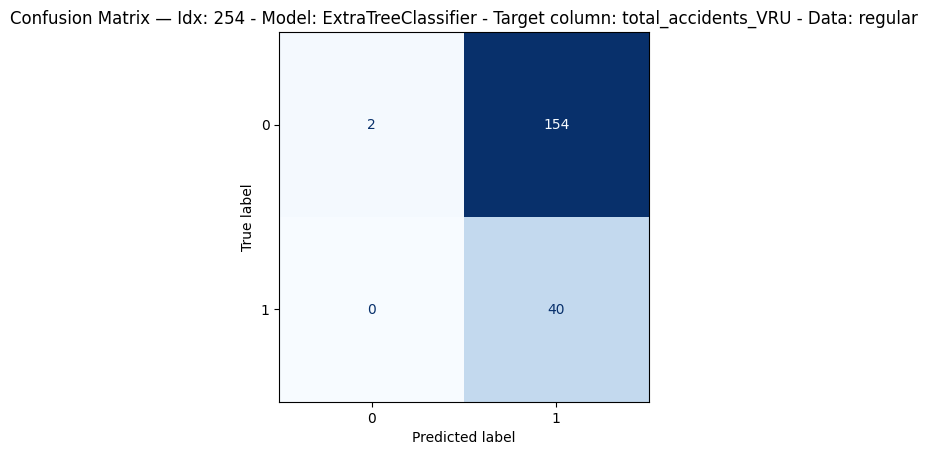

In [ ]:
for idx, row in df_training_info_classification[df_training_info_classification['data_preprocessing'] == 'binary'].iterrows():
    if row['target_column'] != 'total_accidents_VRU':
        continue
    
    model = row['model']
    score_column = row['target_column']
    data_name = row['data_name']

    df = dict_edge_datasets['binary']

    dict_training_datasets = {
        'regular' : base_trainTest_split(df, score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
        'regular_resampled' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
        'regular_resampled_expanded' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
        'regular_resampled_SMOTE' : resample_data_SMOTE(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
        'regular_undersampled' : under_resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),

        'normalized' : base_trainTest_split(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
        'normalized_resampled' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
        'normalized_resampled_expanded' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
        'normalized_resampled_SMOTE' : resample_data_SMOTE(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
        'normalized_undersampled' : under_resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
    }

    y_pred = model.predict(dict_training_datasets[data_name]['x_validation'])

    title = f"Idx: {idx} - Model: {type(model).__name__} - Target column: {score_column} - Data: {data_name}"
    disp = ConfusionMatrixDisplay.from_predictions(
        dict_training_datasets[data_name]['y_validation'],
        y_pred,
        cmap='Blues',
        colorbar=False
    )

    disp.ax_.set_title("Confusion Matrix — " + title)
    # Uncomment the following line to see the confusion matrixes!
    #plt.show()

All crash analysis

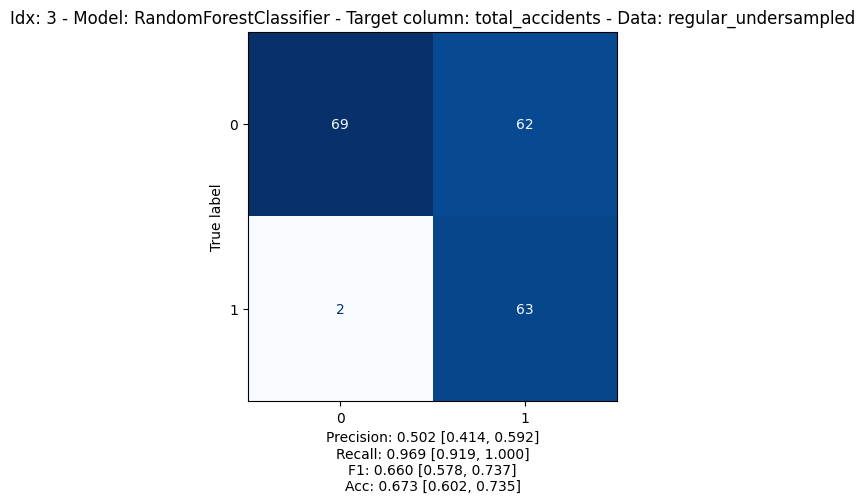

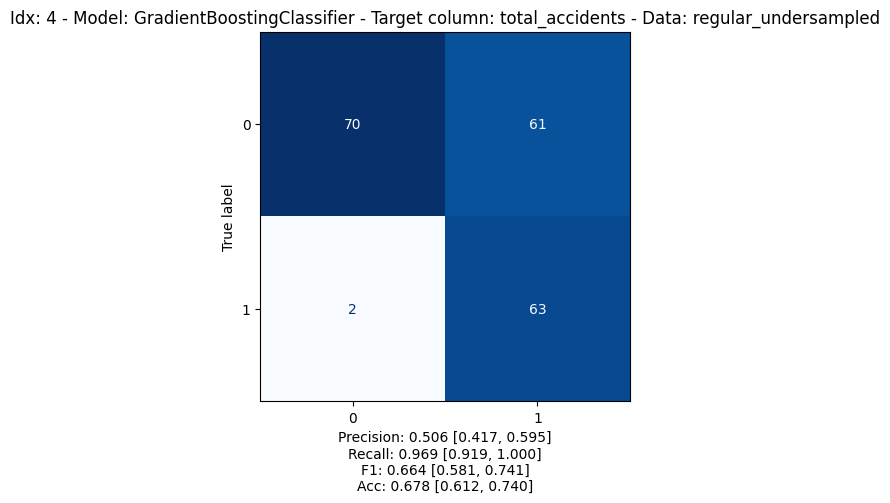

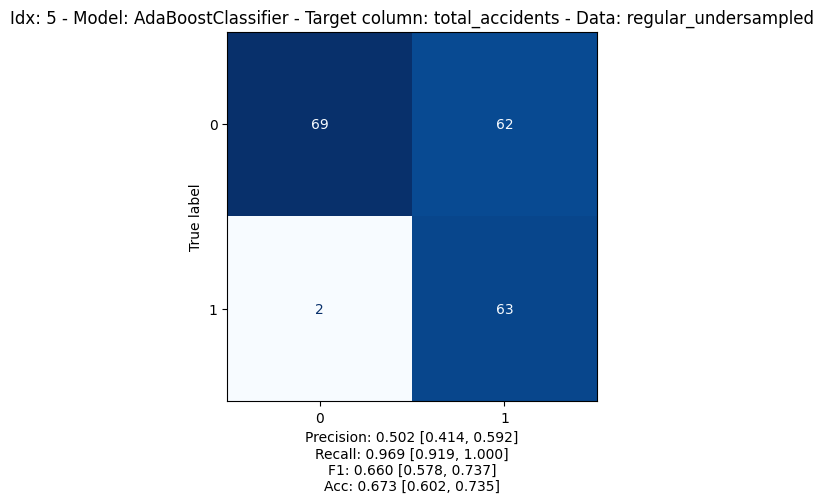

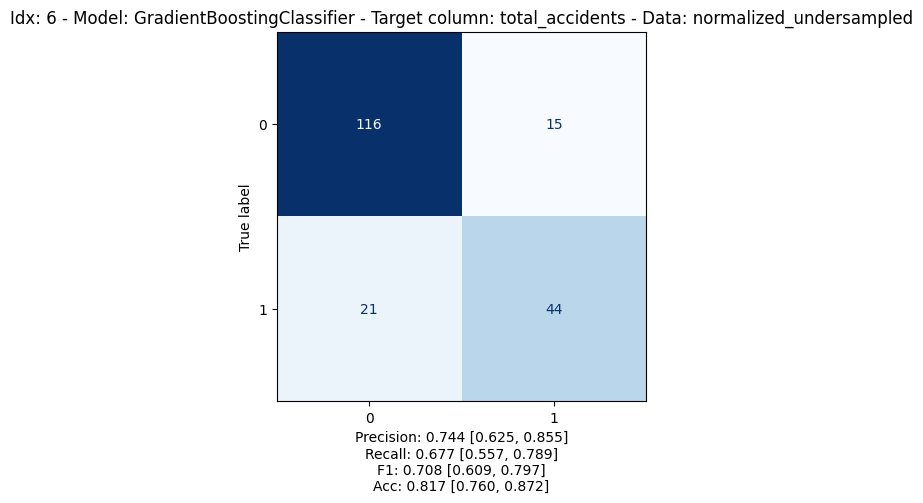

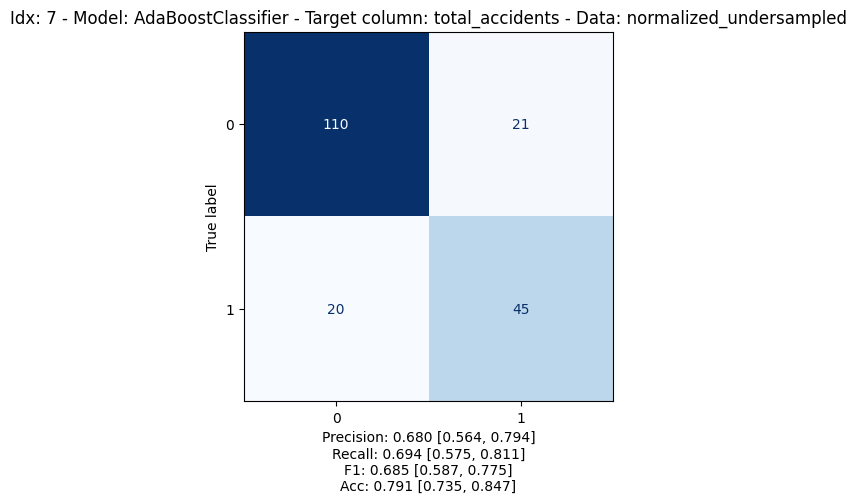

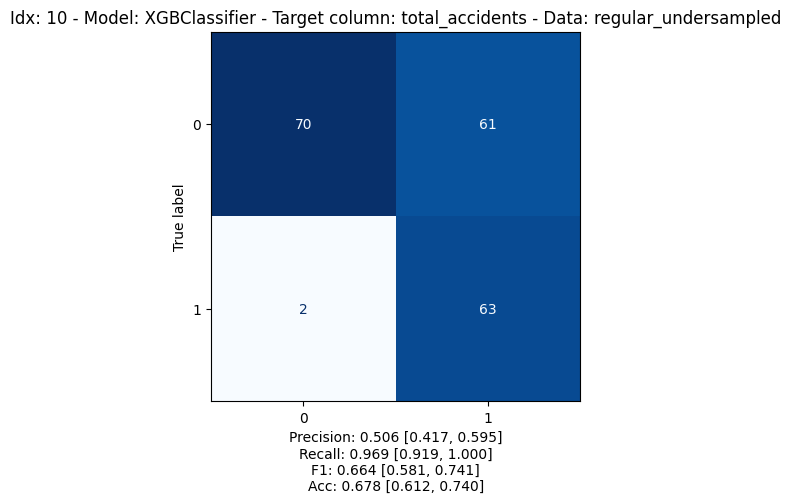

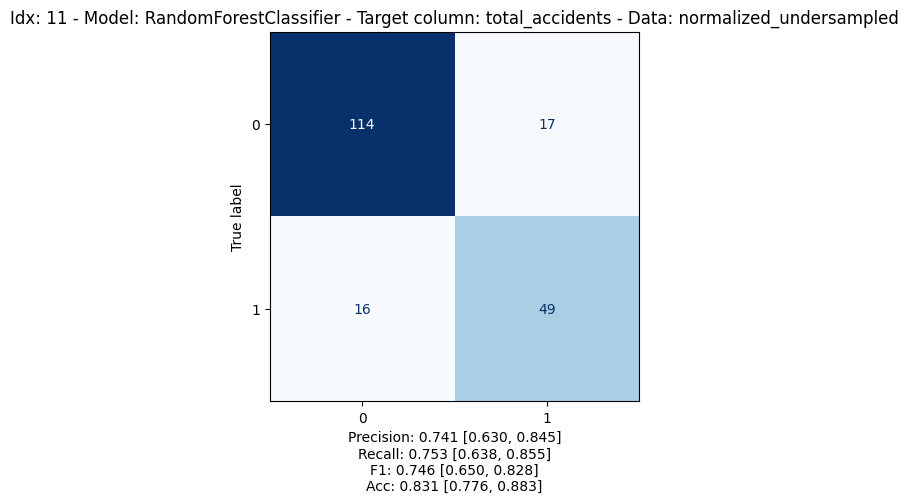

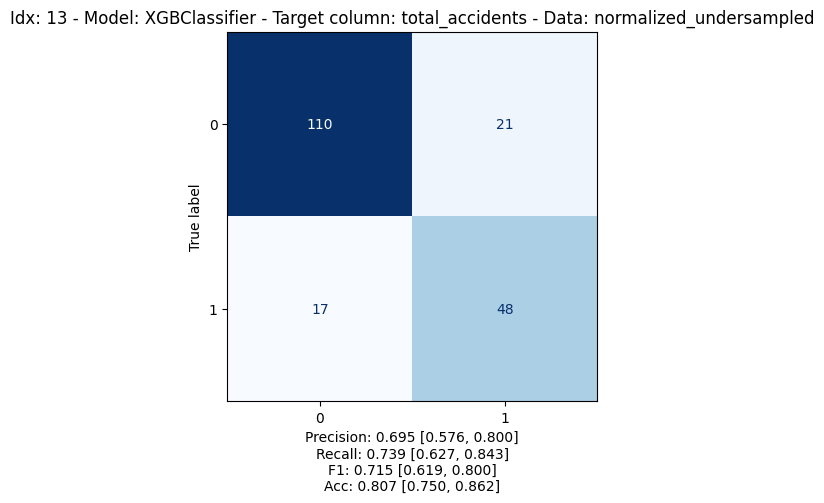

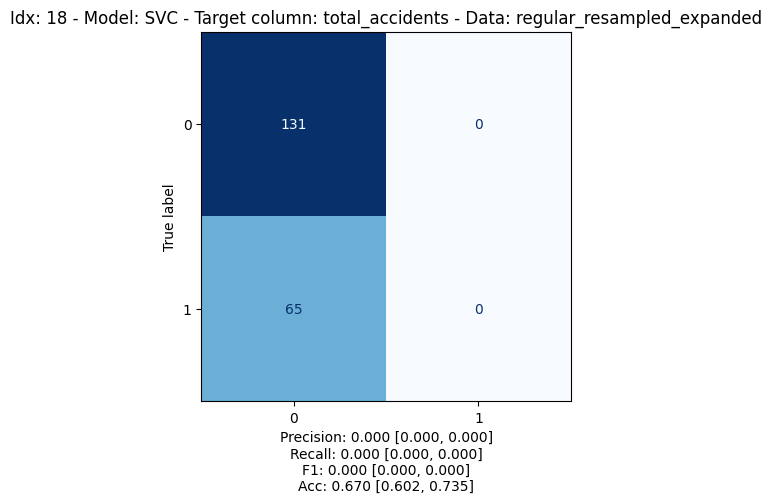

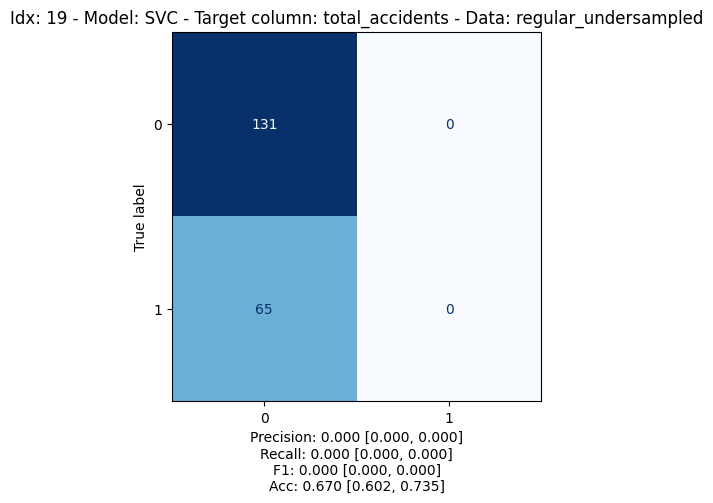

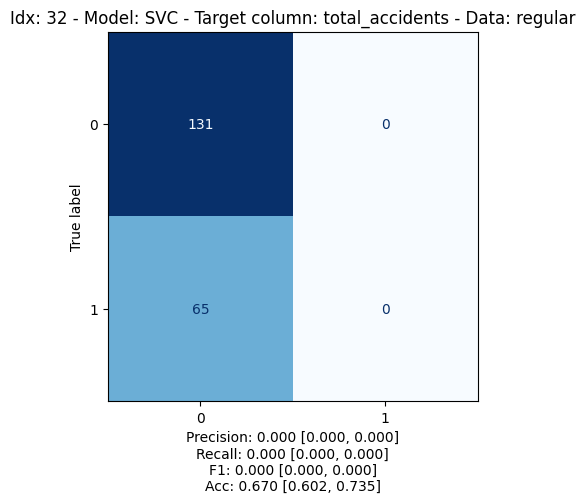

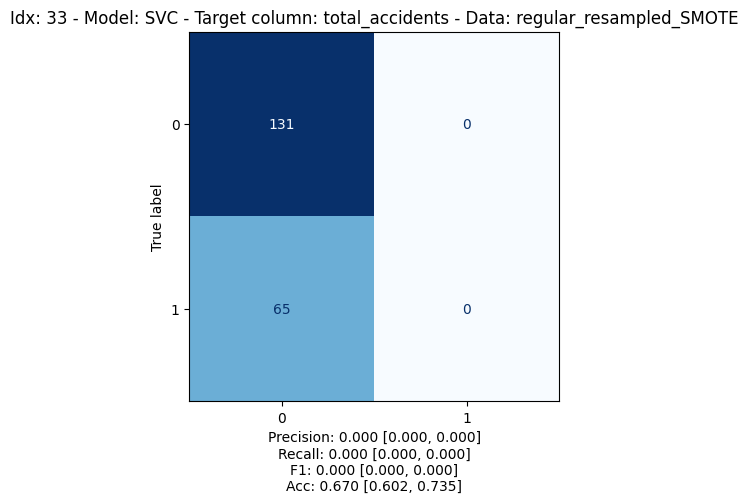

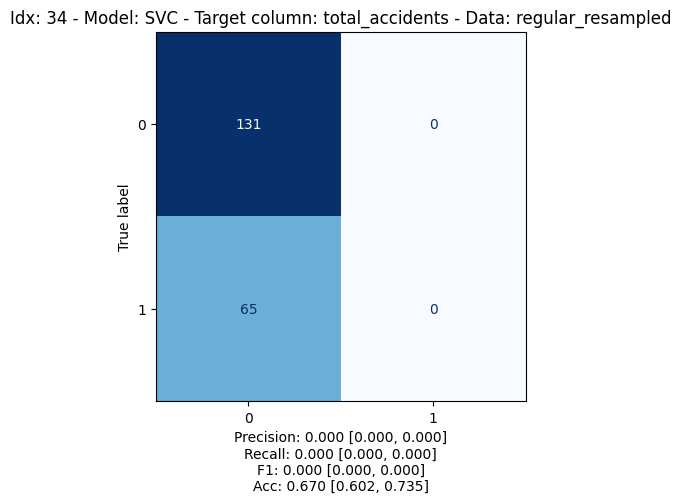

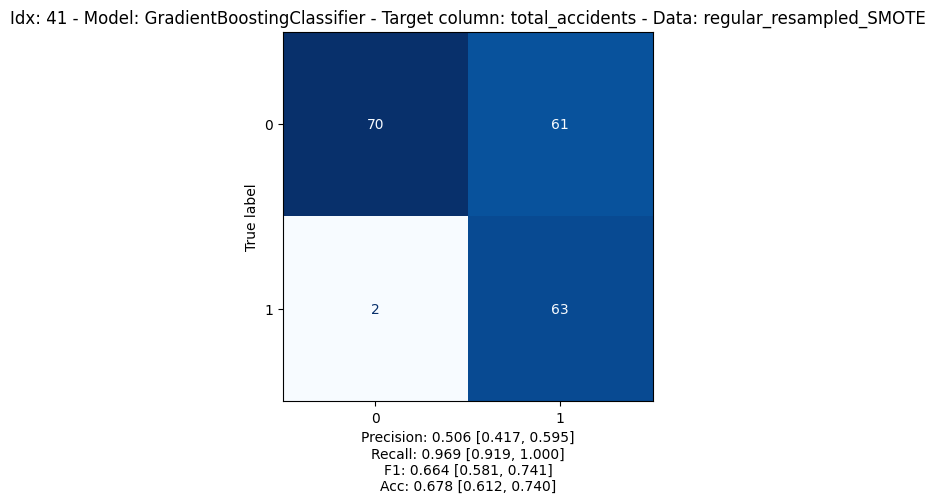

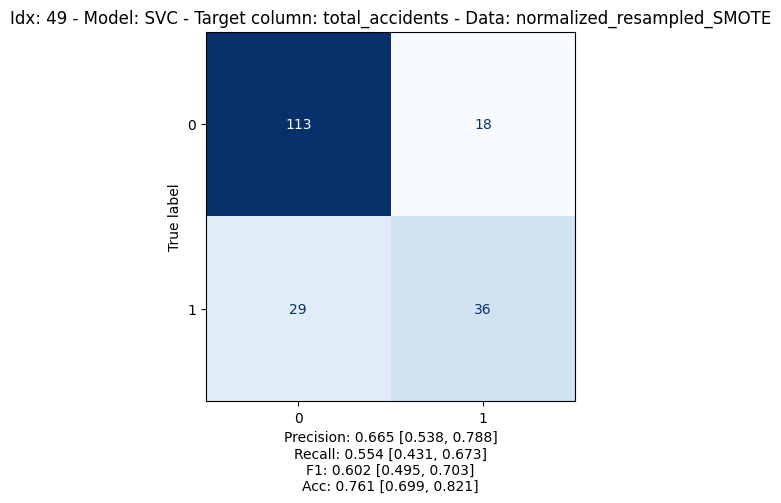

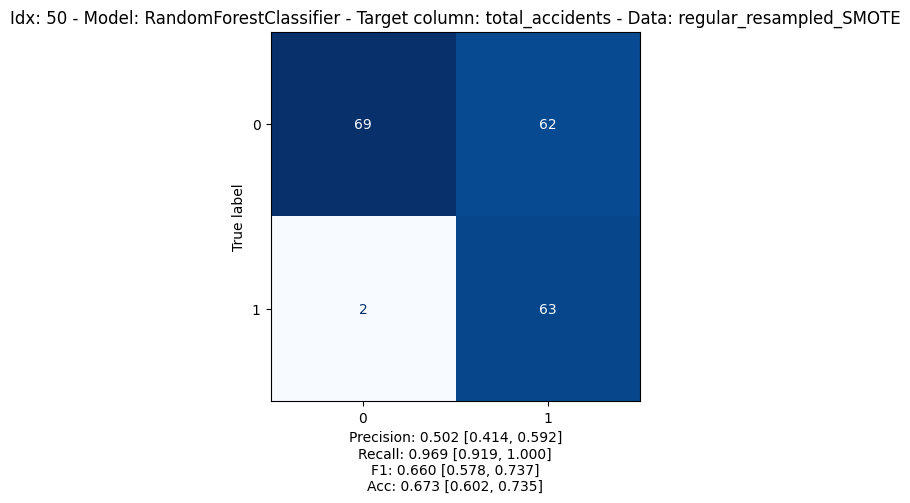

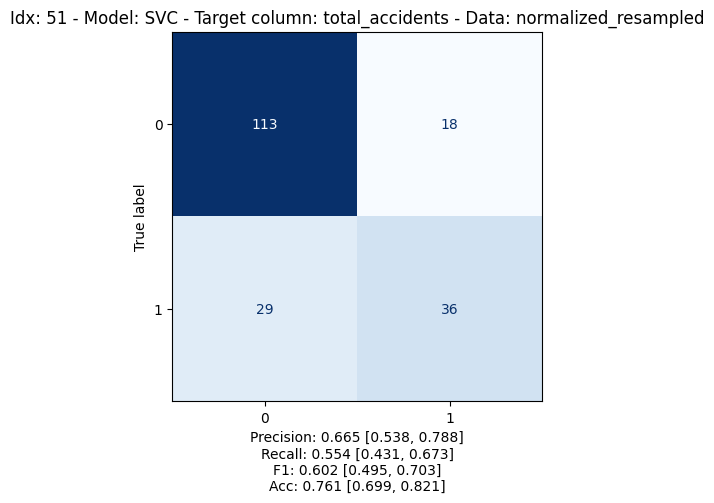

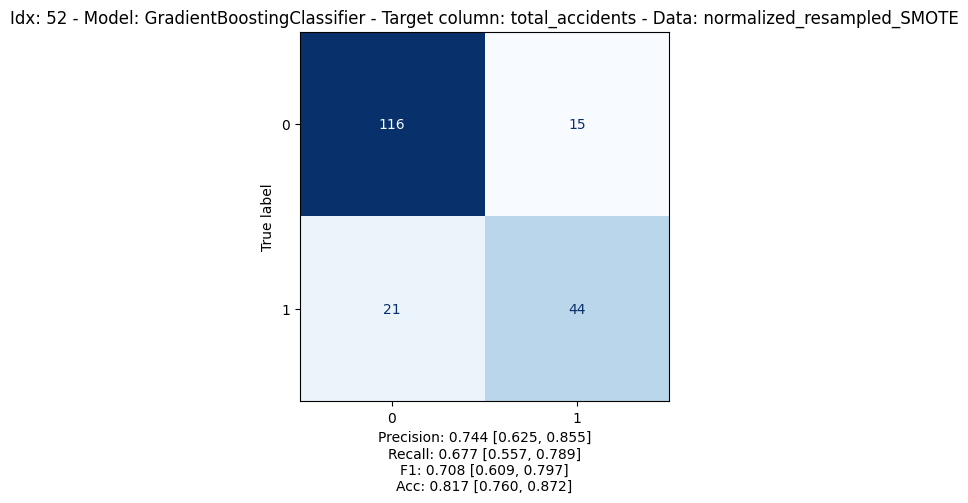

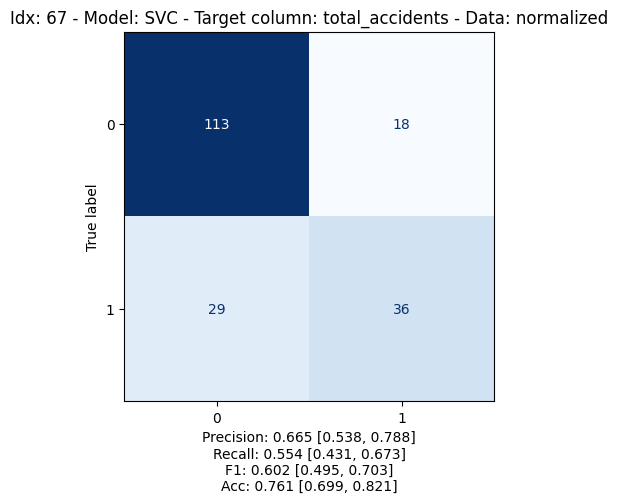

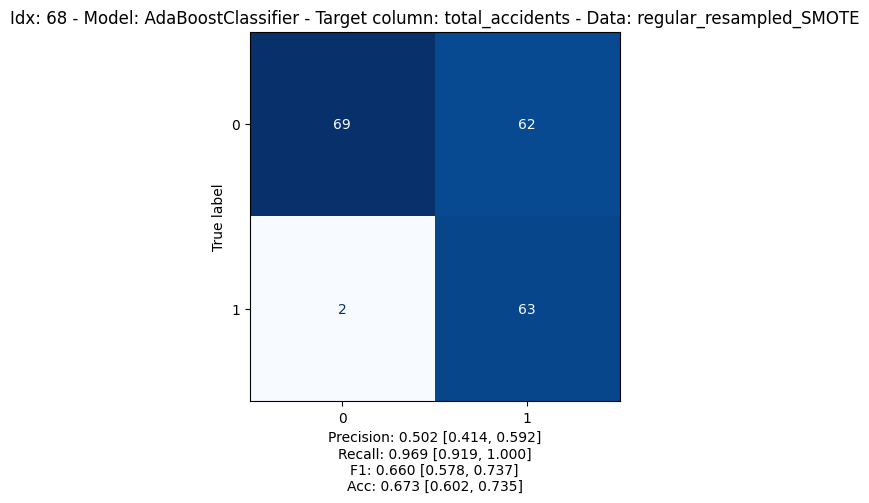

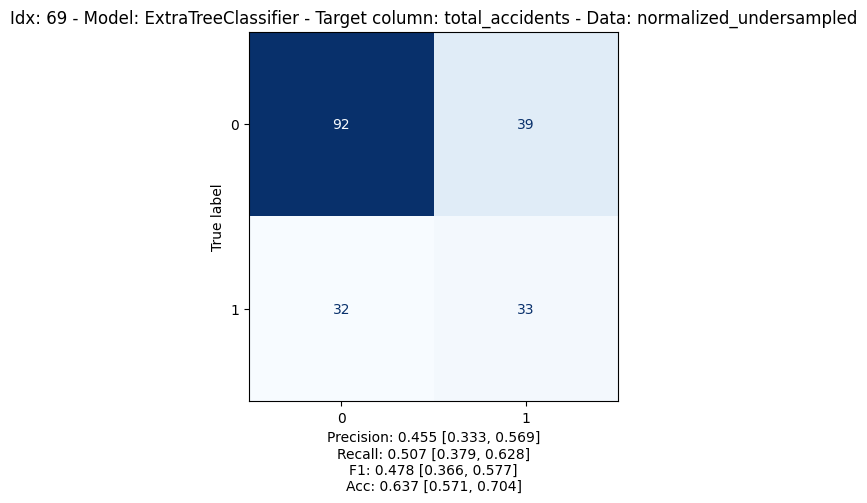

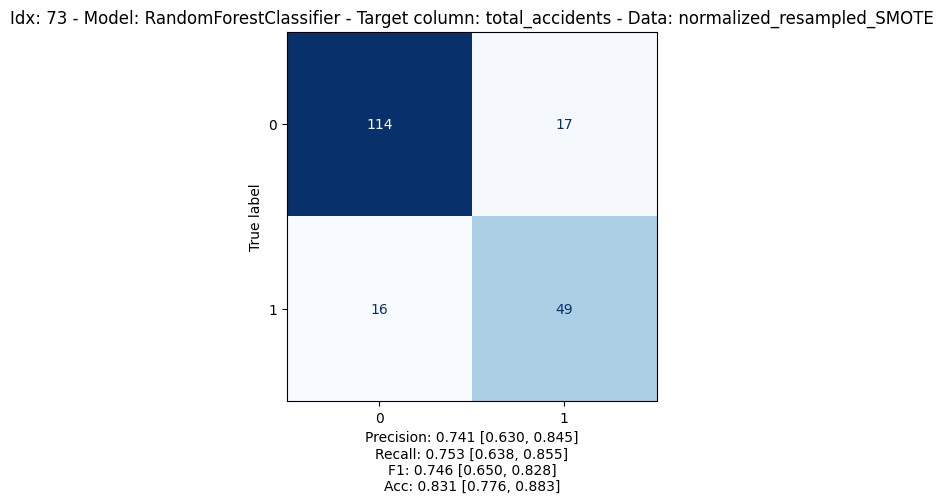

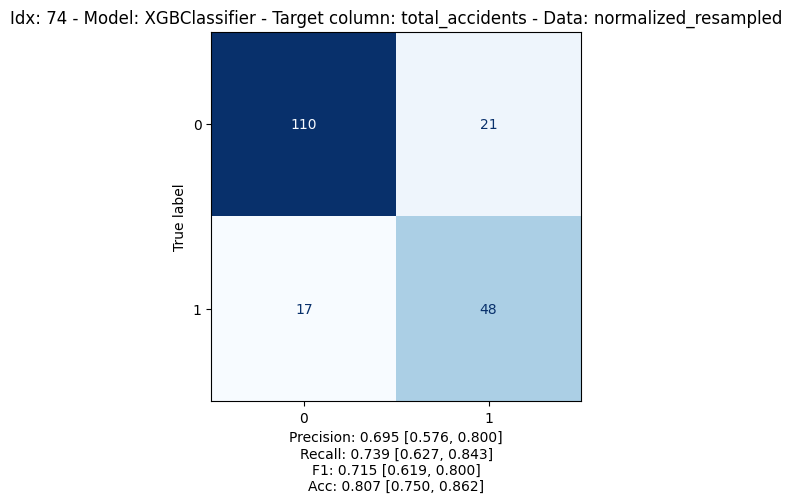

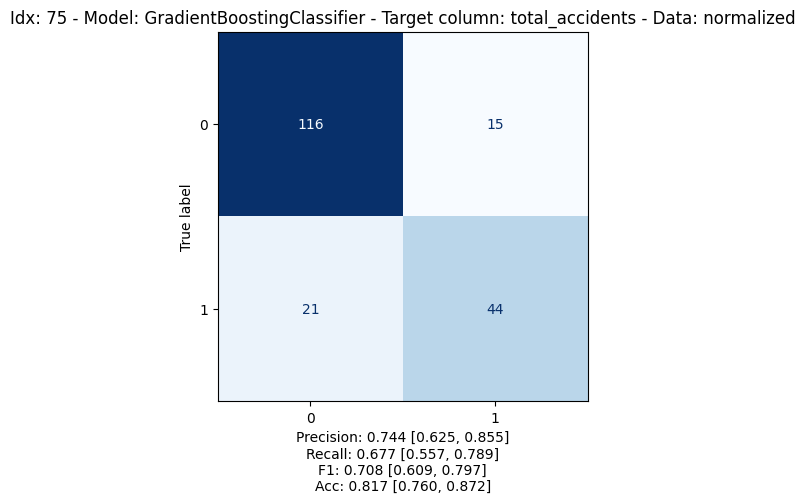

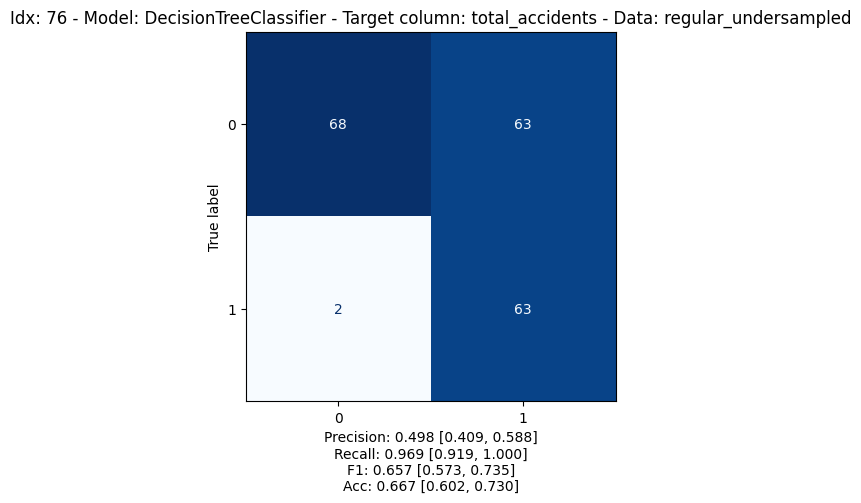

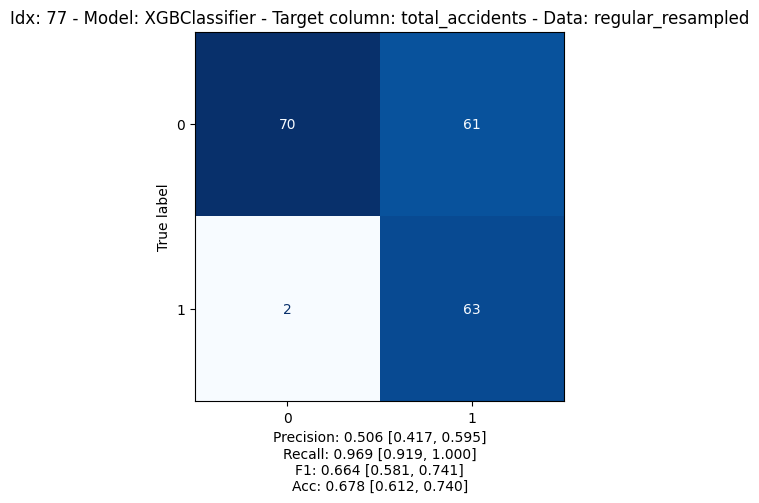

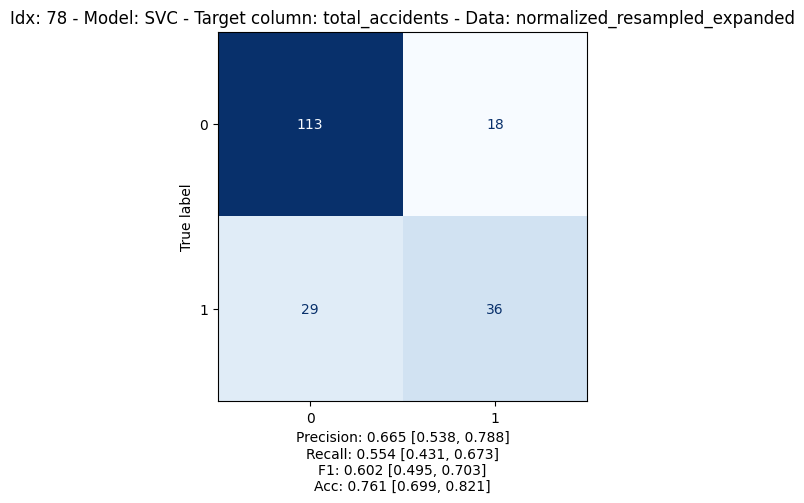

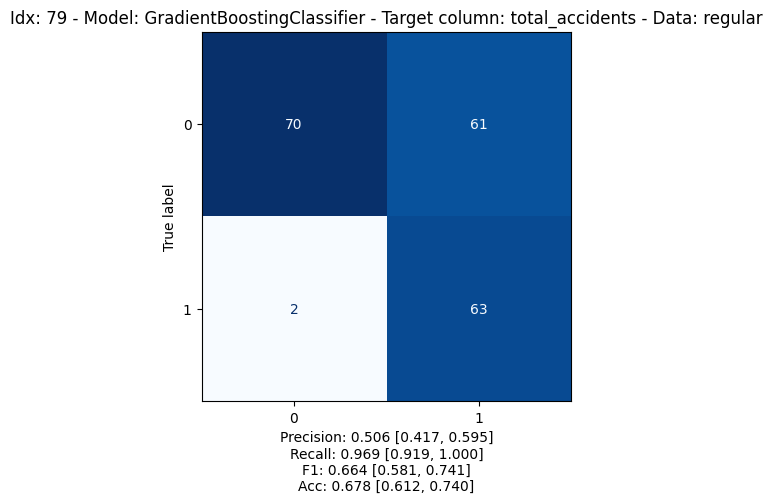

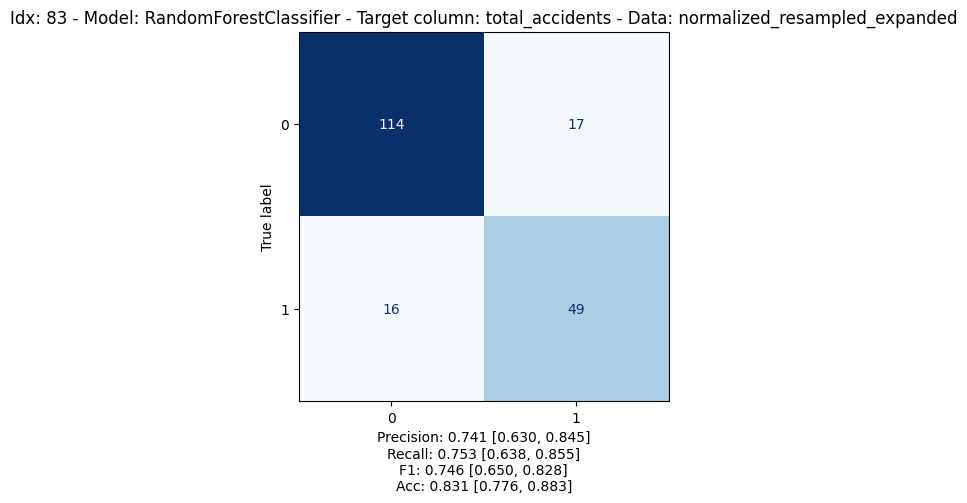

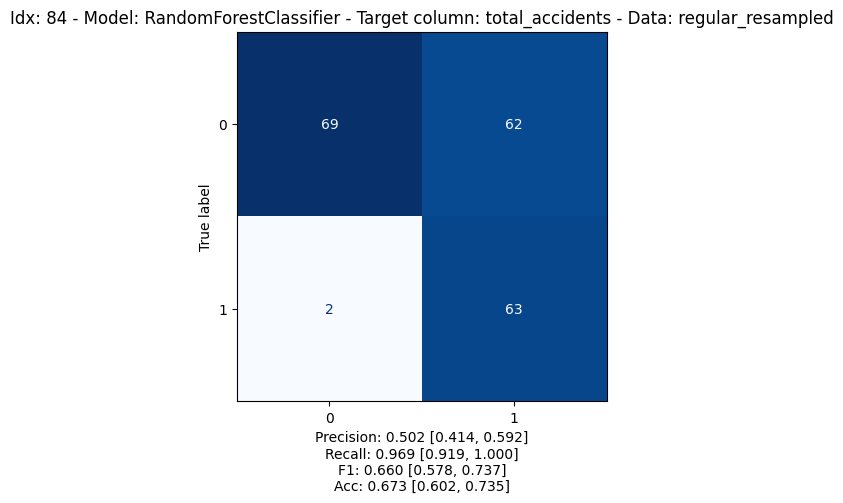

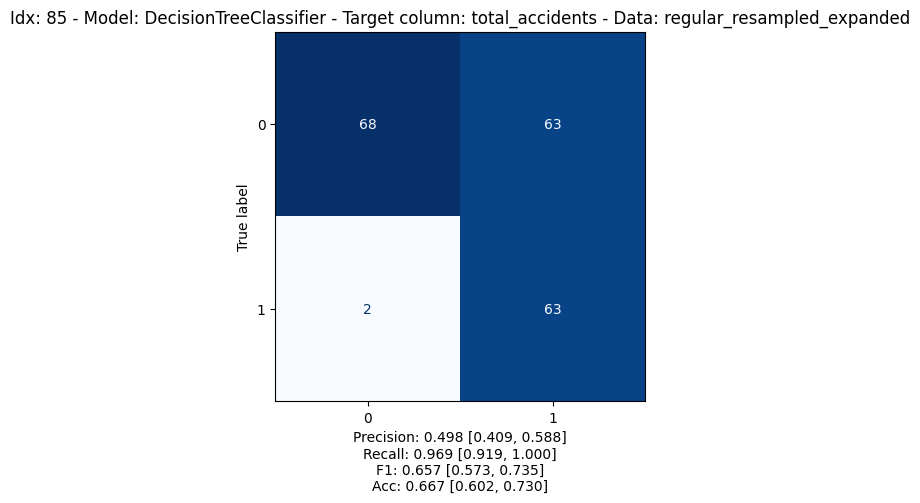

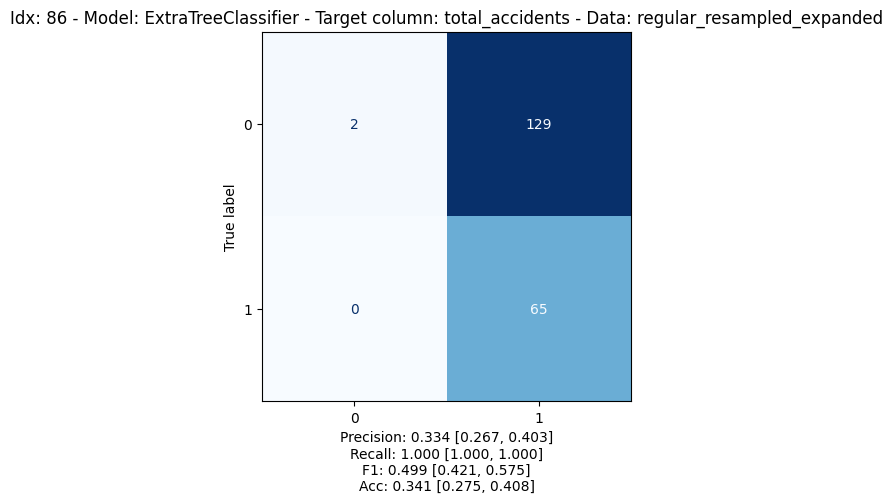

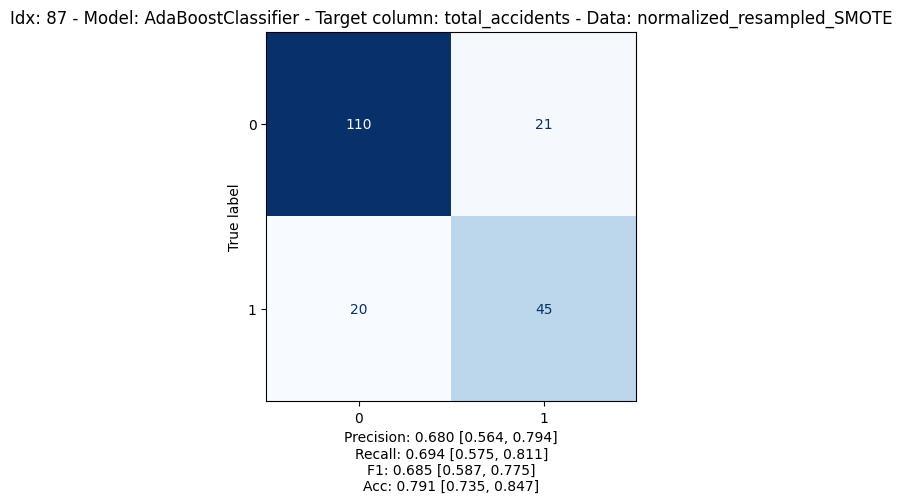

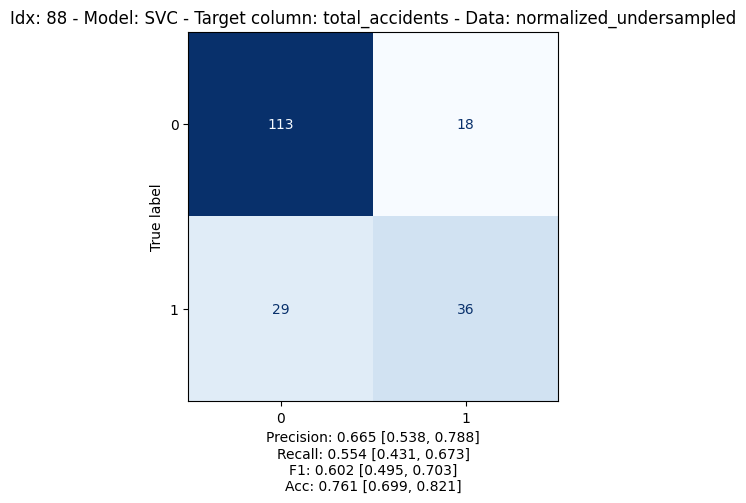

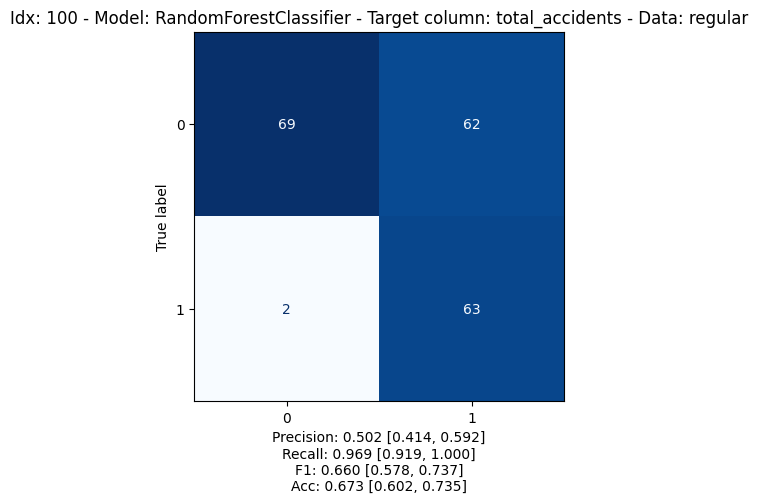

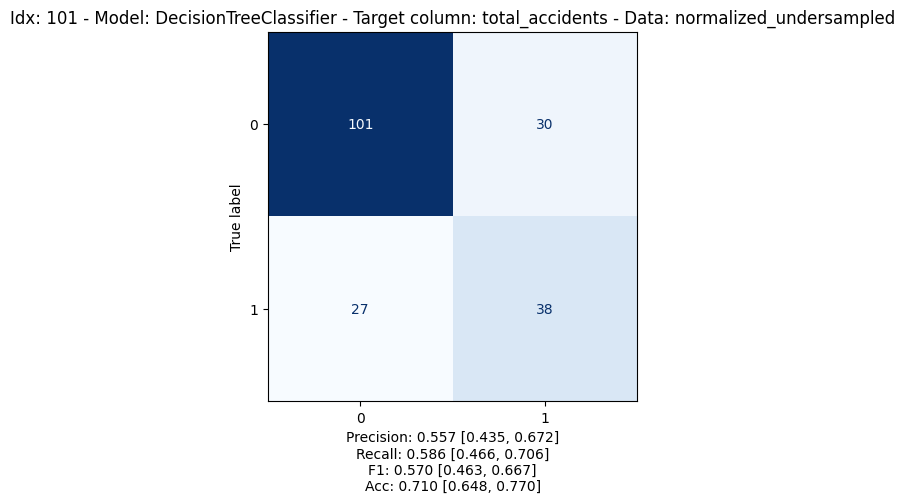

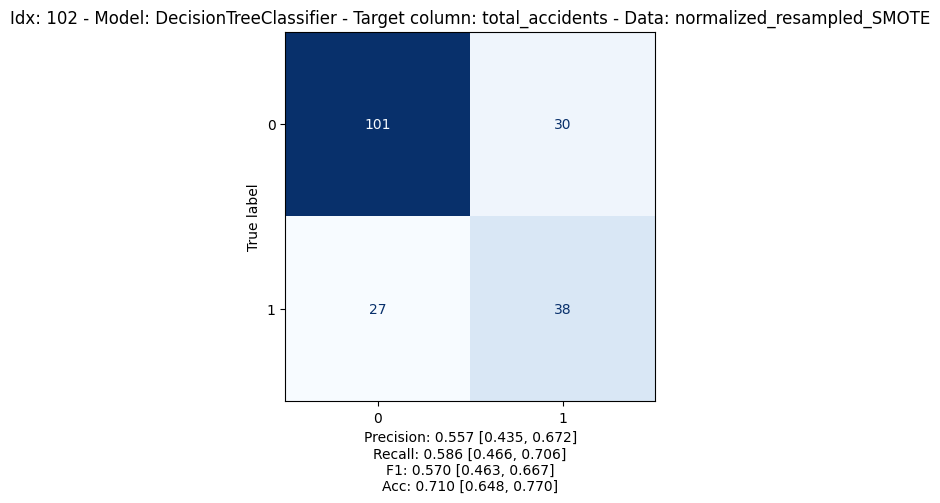

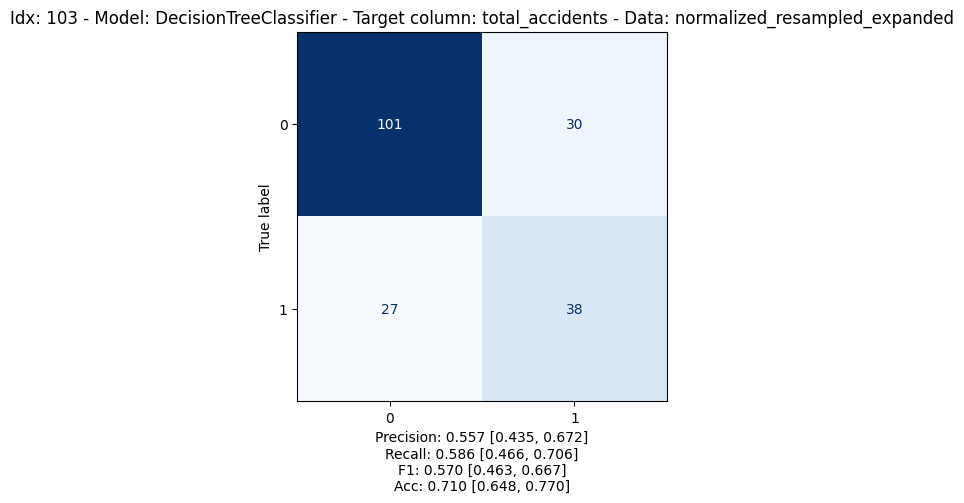

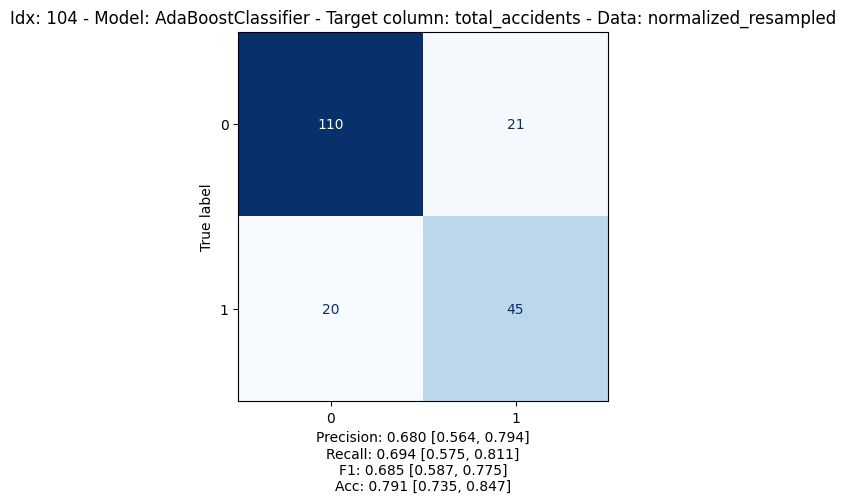

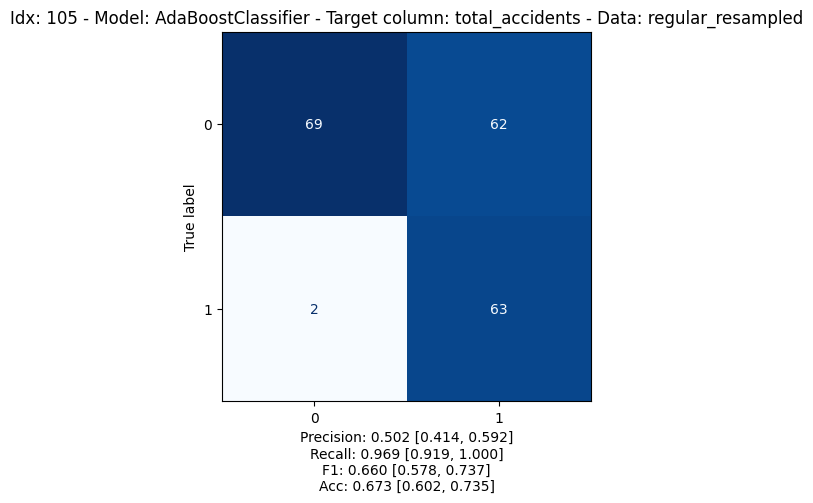

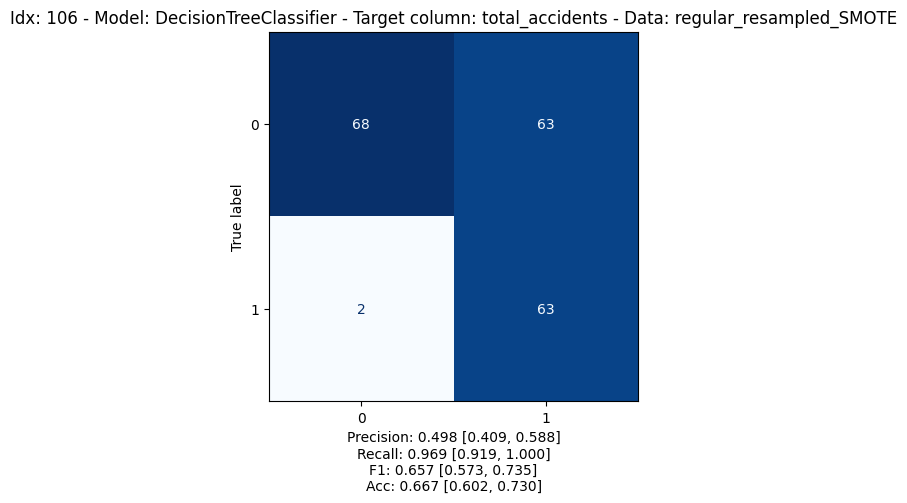

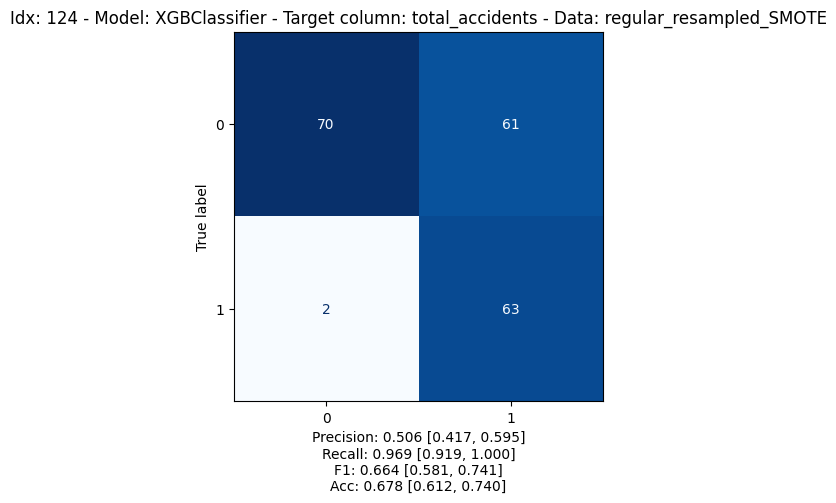

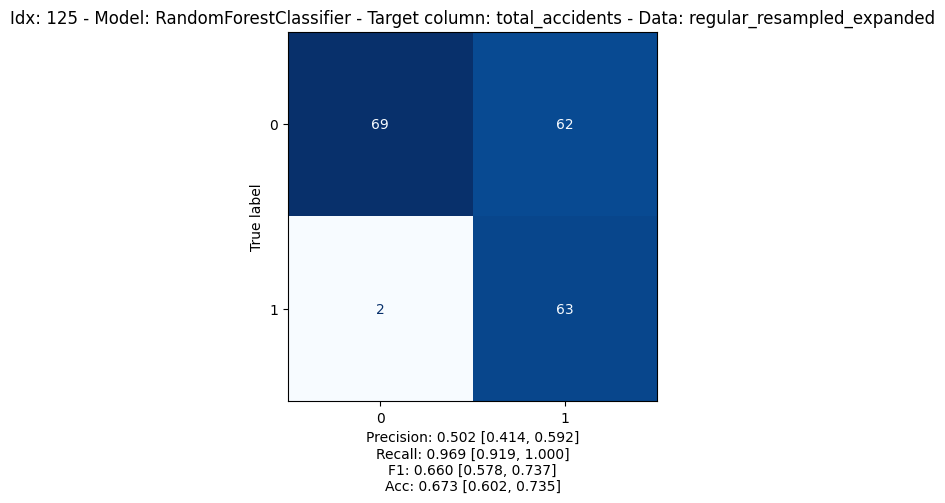

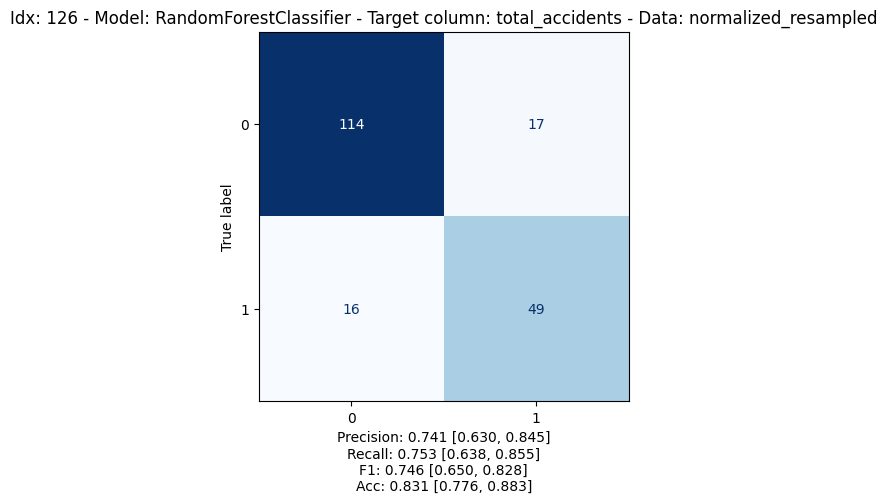

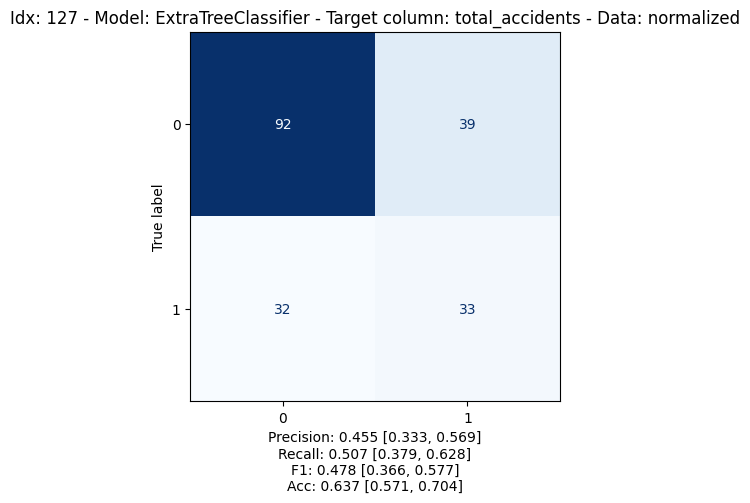

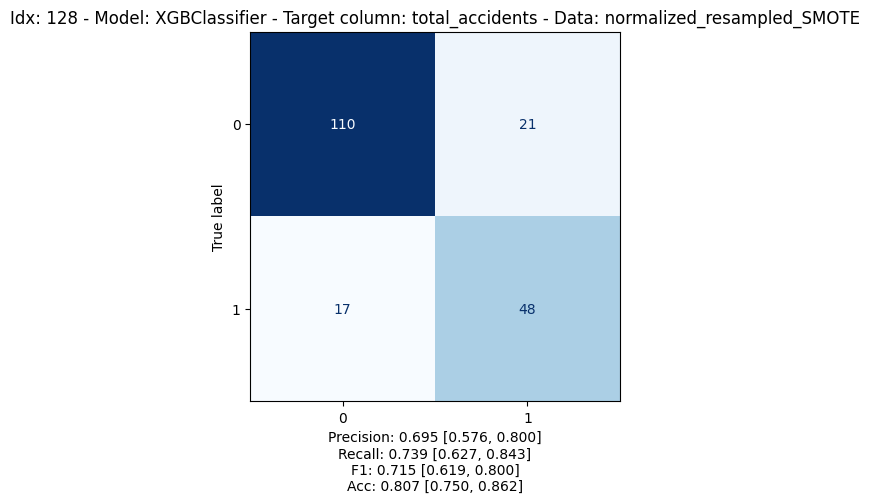

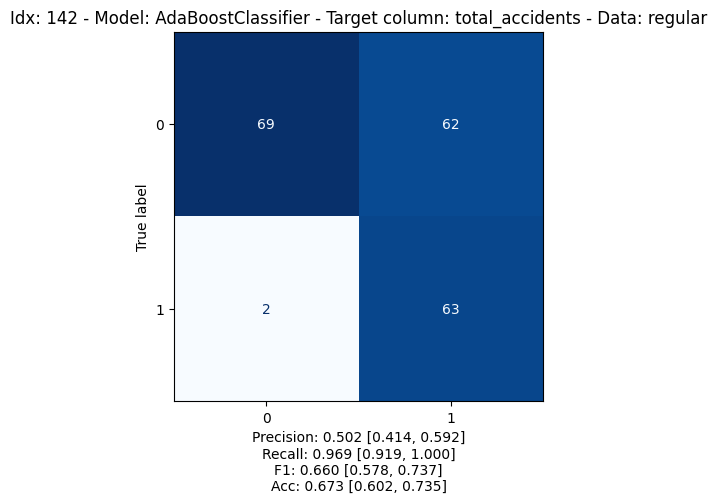

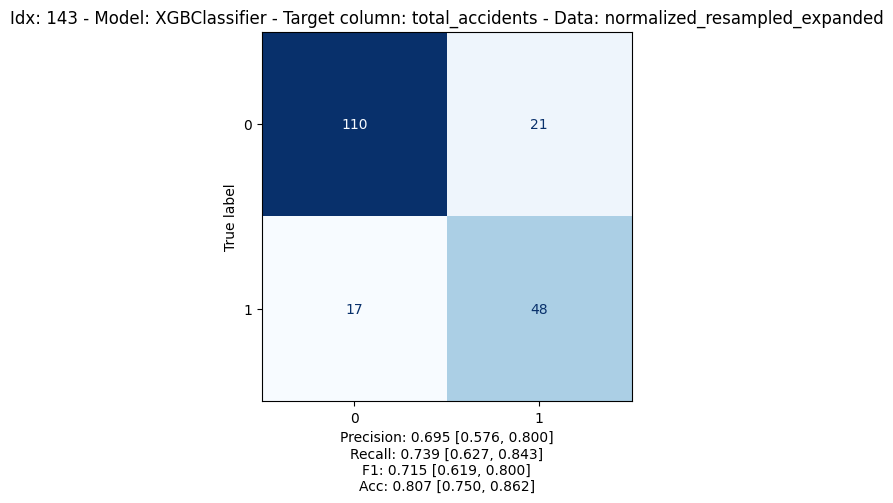

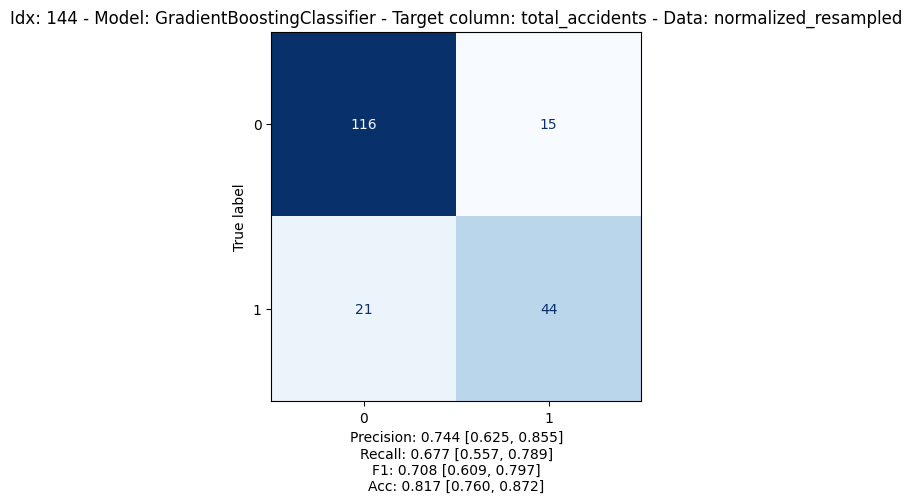

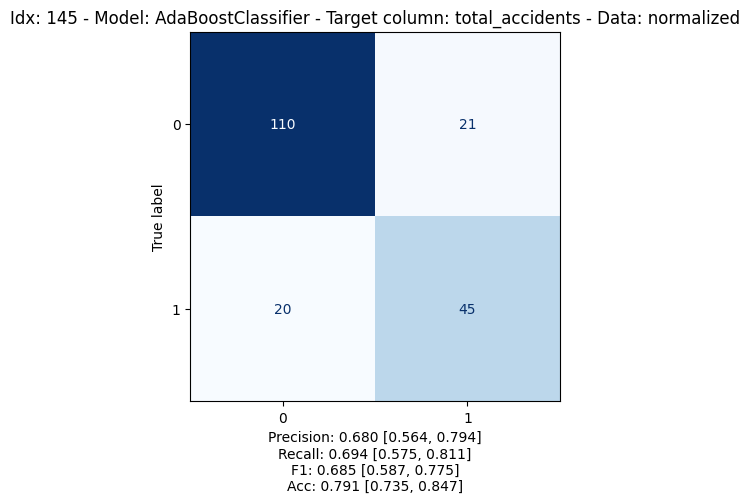

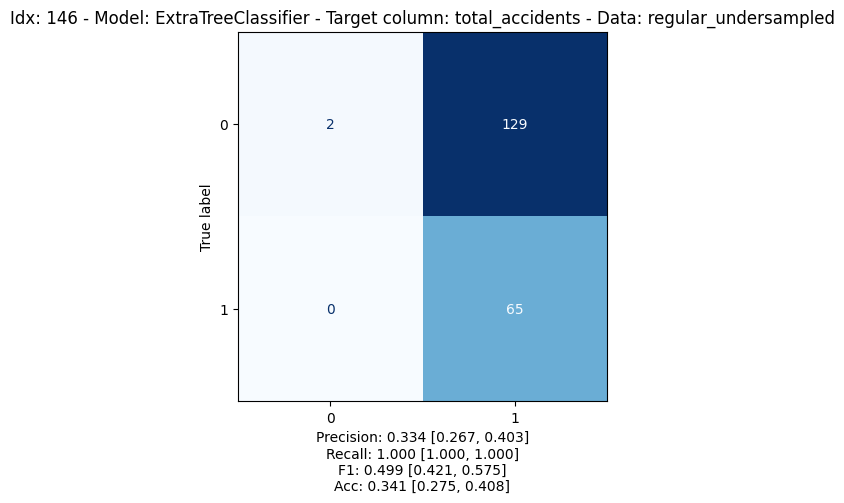

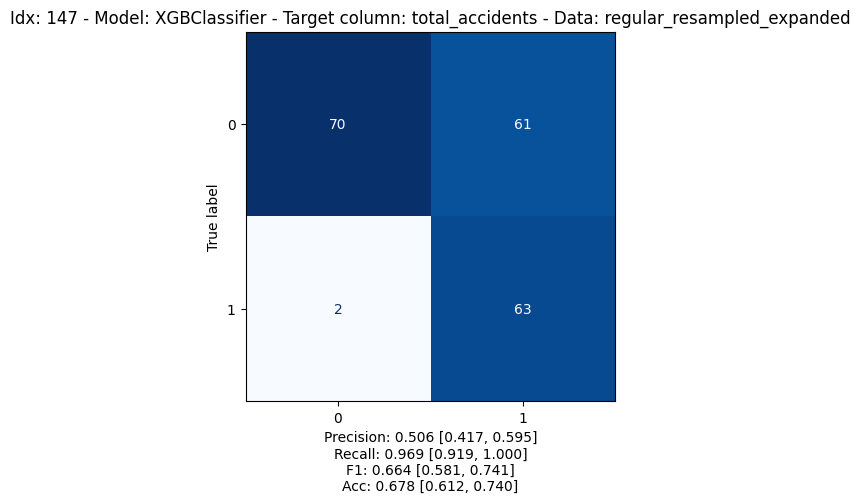

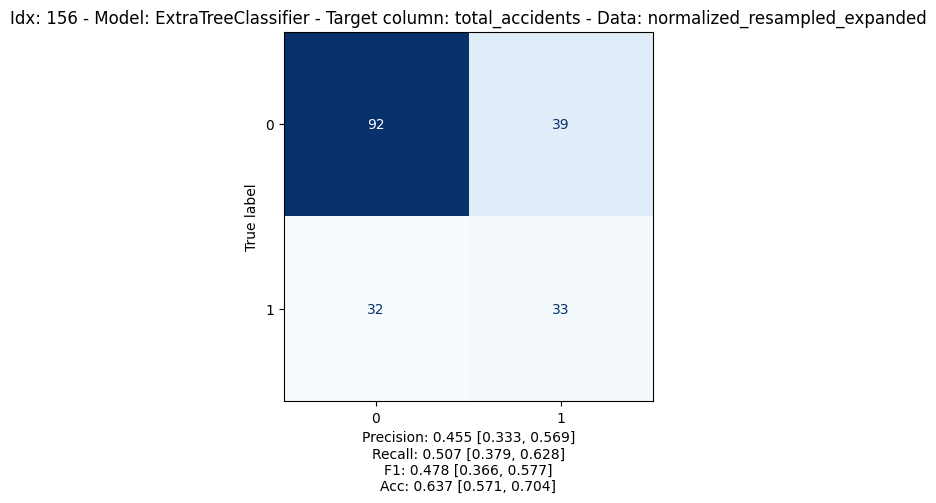

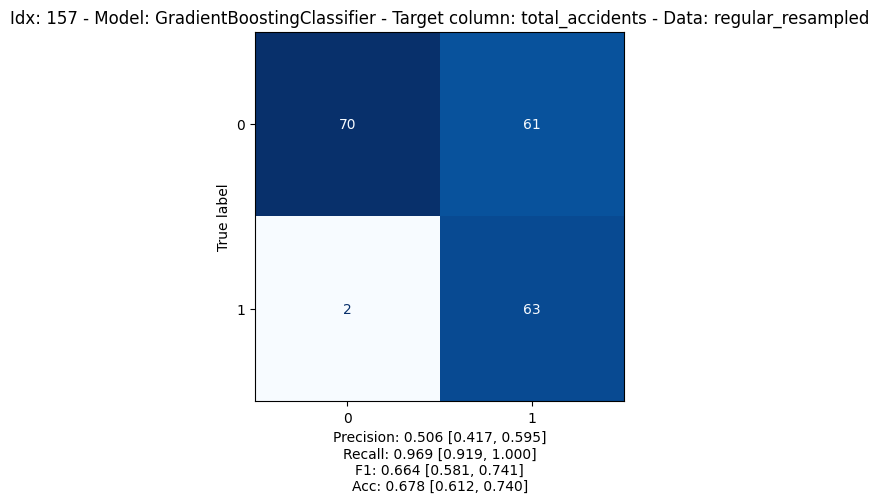

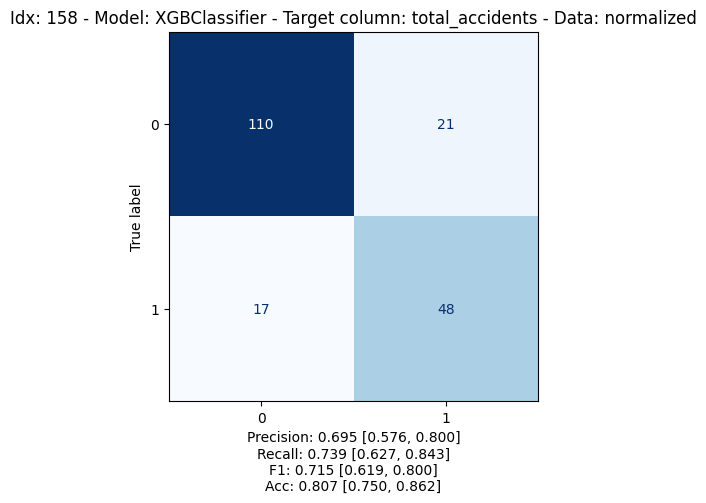

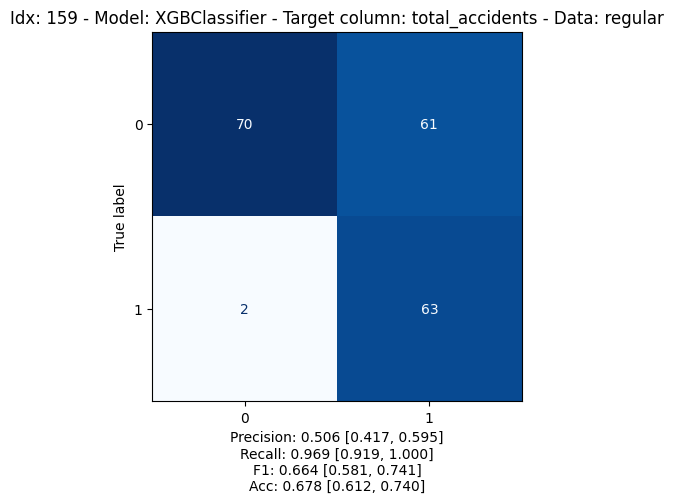

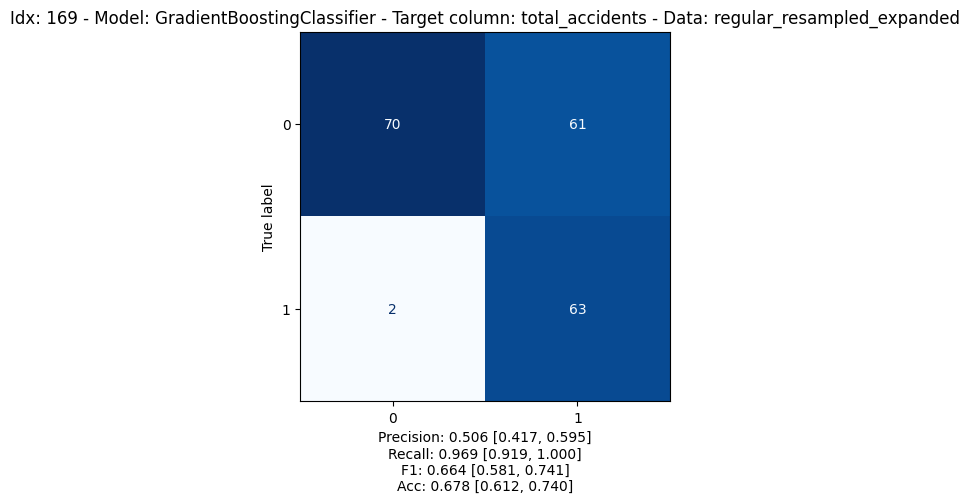

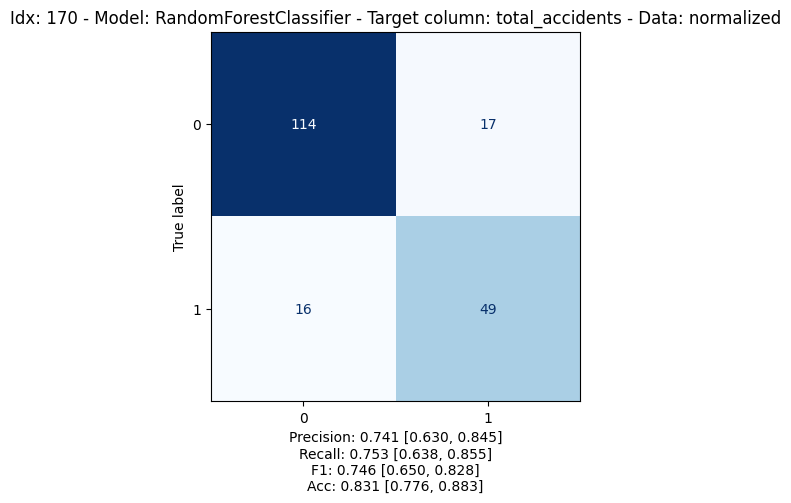

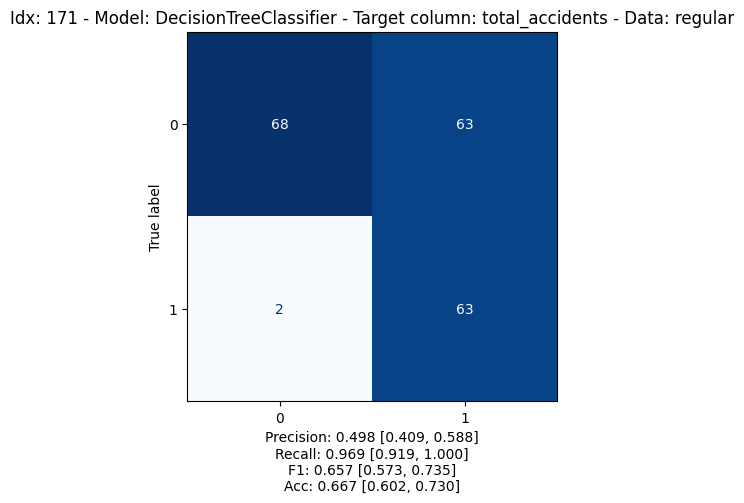

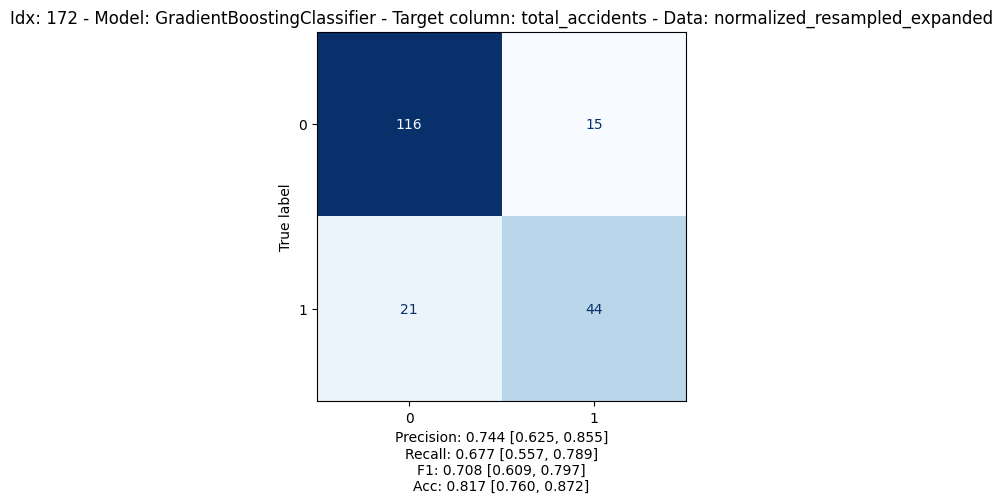

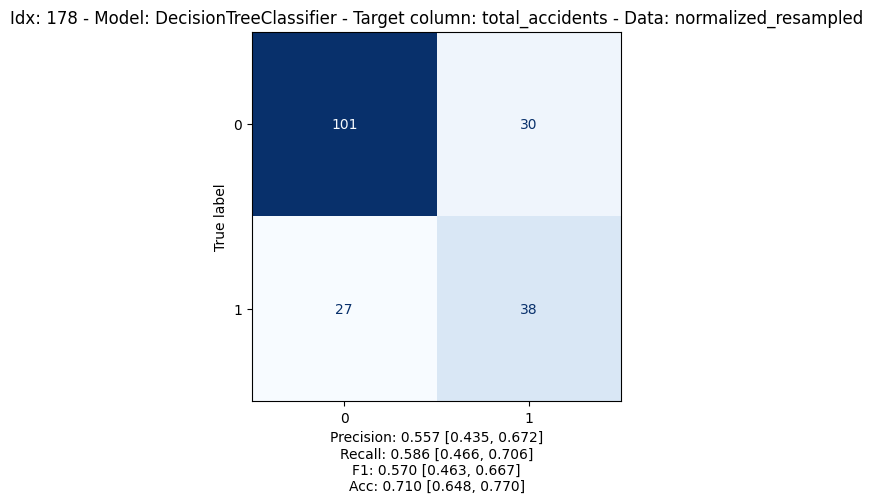

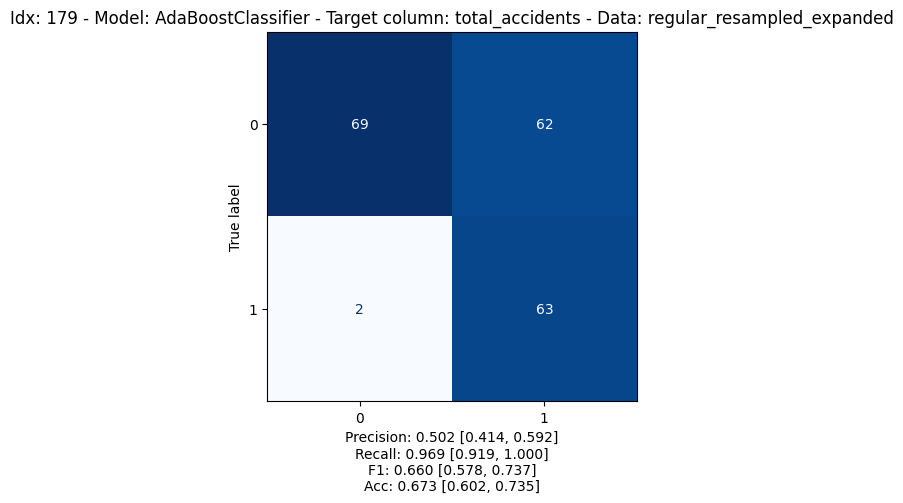

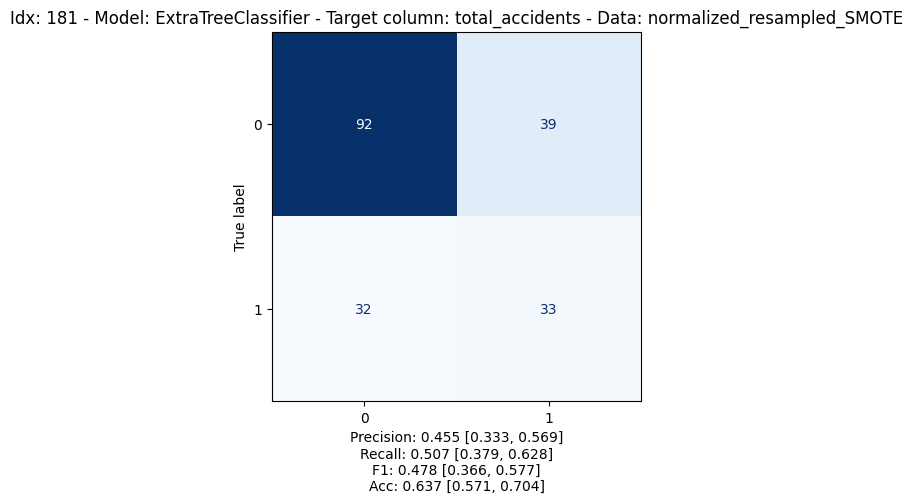

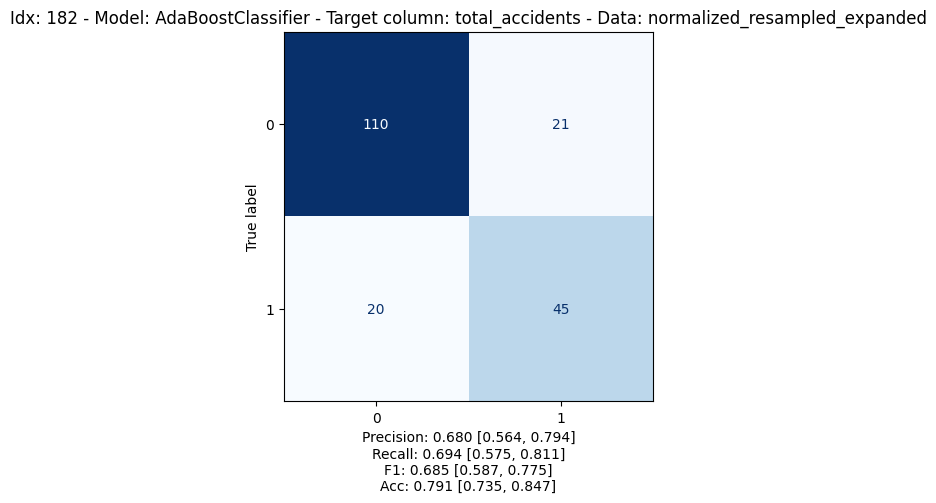

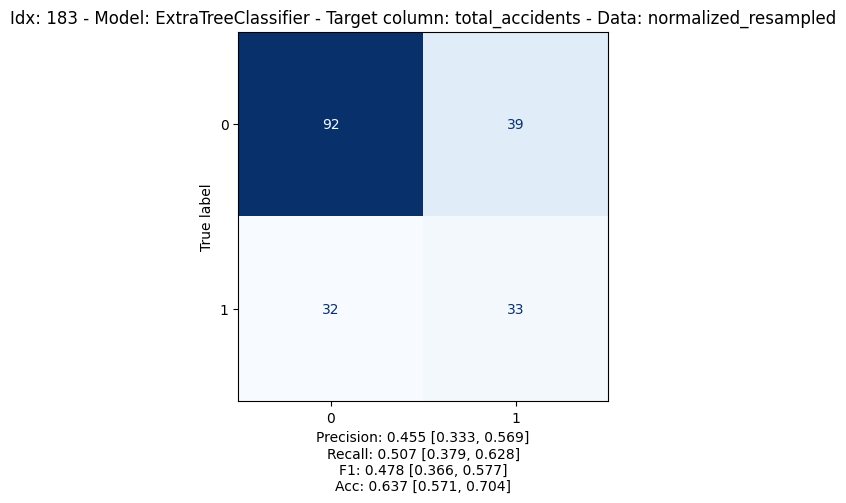

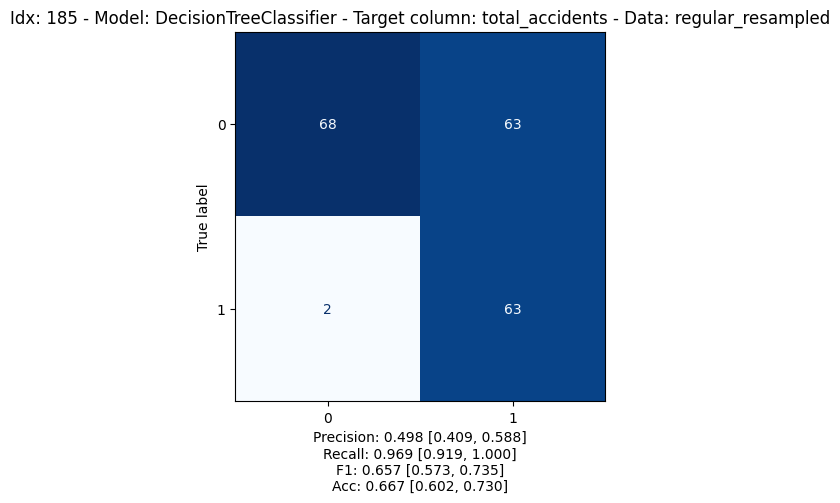

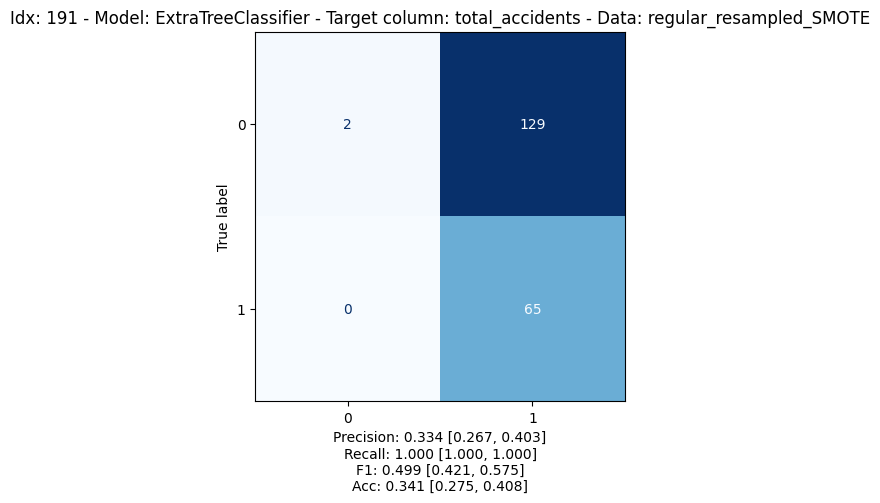

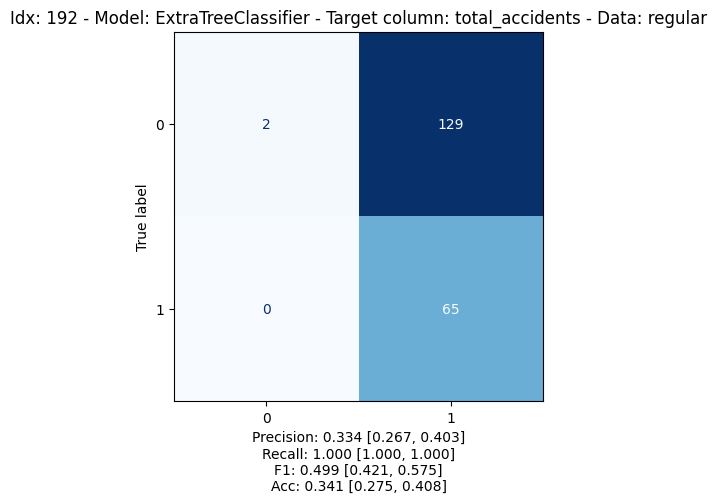

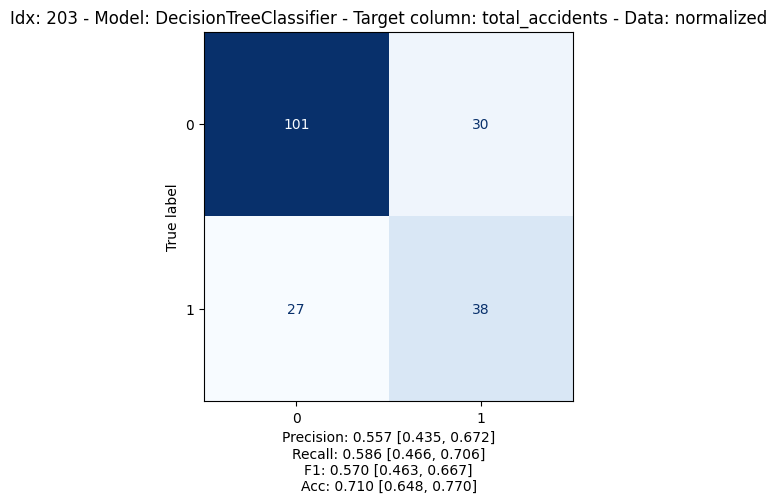

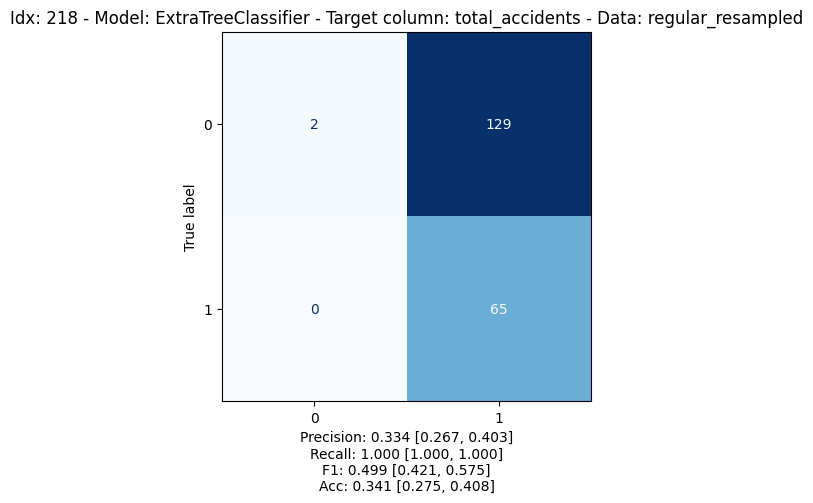

In [52]:
for idx, row in df_training_info_classification[df_training_info_classification['data_preprocessing'] == 'binary'].iterrows():
    if row['target_column'] != 'total_accidents':
        continue
    
    model = row['model']
    score_column = row['target_column']
    data_name = row['data_name']

    df = dict_edge_datasets['binary']

    dict_training_datasets = {
        'regular' : base_trainTest_split(df, score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
        'regular_resampled' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
        'regular_resampled_expanded' : resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
        'regular_resampled_SMOTE' : resample_data_SMOTE(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
        'regular_undersampled' : under_resample_data(df, target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),

        'normalized' : base_trainTest_split(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), score_column, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
        'normalized_resampled' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
        'normalized_resampled_expanded' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
        'normalized_resampled_SMOTE' : resample_data_SMOTE(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
        'normalized_undersampled' : under_resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=score_column, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
    }
    
    y_val = dict_training_datasets[data_name]['y_validation'].values
    y_pred = model.predict(dict_training_datasets[data_name]['x_validation'].drop(columns=['geometry'], errors='ignore'))

    ci = bootstrap_ci_binary(y_val, y_pred)

    title = f"Idx: {idx} - Model: {type(model).__name__} - Target column: {score_column} - Data: {data_name}"
    true_positives = confusion_matrix(dict_training_datasets[data_name]['y_validation'], y_pred)[1,1]
    false_positives = confusion_matrix(dict_training_datasets[data_name]['y_validation'], y_pred)[0,1]
    false_negatives = confusion_matrix(dict_training_datasets[data_name]['y_validation'], y_pred)[1,0]
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score_value = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    stats = (
        f"Precision: {ci['precision'][0]:.3f} "
        f"[{ci['precision'][1]:.3f}, {ci['precision'][2]:.3f}]\n"
        f"Recall: {ci['recall'][0]:.3f} "
        f"[{ci['recall'][1]:.3f}, {ci['recall'][2]:.3f}]\n"
        f"F1: {ci['f1'][0]:.3f} "
        f"[{ci['f1'][1]:.3f}, {ci['f1'][2]:.3f}]\n"
        f"Acc: {ci['accuracy'][0]:.3f} "
        f"[{ci['accuracy'][1]:.3f}, {ci['accuracy'][2]:.3f}]"
    )

    #stats = f"Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1_score_value:.3f}"
    disp = ConfusionMatrixDisplay.from_predictions(
        dict_training_datasets[data_name]['y_validation'],
        y_pred,
        cmap='Blues',
        colorbar=False
    )

    disp.ax_.set_title(title)
    disp.ax_.set_xlabel(stats)
    plt.show()

  


In [59]:
BEST_MODEL_ROW = 6

testing_targetColumn = df_training_info_classification.loc[BEST_MODEL_ROW, 'target_column']
testing_datasetUsed = df_training_info_classification.loc[BEST_MODEL_ROW, 'data_name']
testing_dataPreprocessing = df_training_info_classification.loc[BEST_MODEL_ROW, 'data_preprocessing']

print(f"Accuracy: {round(df_training_info_classification.loc[BEST_MODEL_ROW, 'accuracy'],4)}")
print(f"F1-score: {round(df_training_info_classification.loc[BEST_MODEL_ROW, 'f1'],4)}")
print(f"Precision: {round(df_training_info_classification.loc[BEST_MODEL_ROW, 'precision'],4)}")
print(f"Recall: {round(df_training_info_classification.loc[BEST_MODEL_ROW, 'recall'],4)}")

Accuracy: 0.7959
F1-score: 0.726
Precision: 0.6543
Recall: 0.8154


In [60]:
df = dict_edge_datasets[testing_dataPreprocessing]

dict_training_datasets = {
            'regular' : base_trainTest_split(df, testing_targetColumn, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'regular_resampled' : resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'regular_resampled_expanded' : resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'regular_resampled_SMOTE' : resample_data_SMOTE(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'regular_undersampled' : under_resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),

            'normalized' : base_trainTest_split(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), testing_targetColumn, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'normalized_resampled' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'normalized_resampled_expanded' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'normalized_resampled_SMOTE' : resample_data_SMOTE(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'normalized_undersampled' : under_resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
}

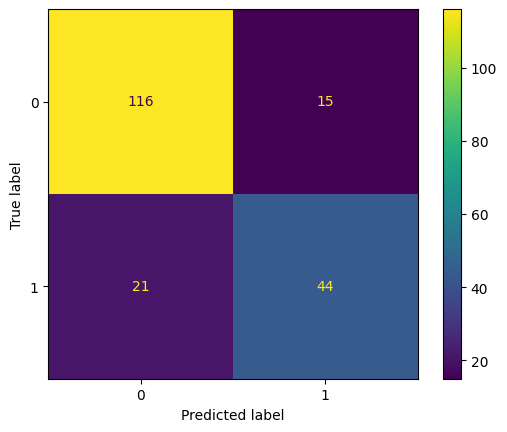

In [61]:
y_pred = df_training_info_classification.loc[BEST_MODEL_ROW,'model'].predict(dict_training_datasets[testing_datasetUsed]['x_validation'])
ConfusionMatrixDisplay.from_predictions(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)

In [63]:
if UPDATE_SAVED_FILES:
    model_name = type(df_training_info_classification.loc[BEST_MODEL_ROW,'model']).__name__
    joblib.dump(df_training_info_classification.loc[BEST_MODEL_ROW,'model'], PATH_MODELS / f'{model_name}_{CASE_NAME}.joblib')

## Grid search for best hyperparameters

Aquí vemos la matriz de confusión del modelo seleccionado

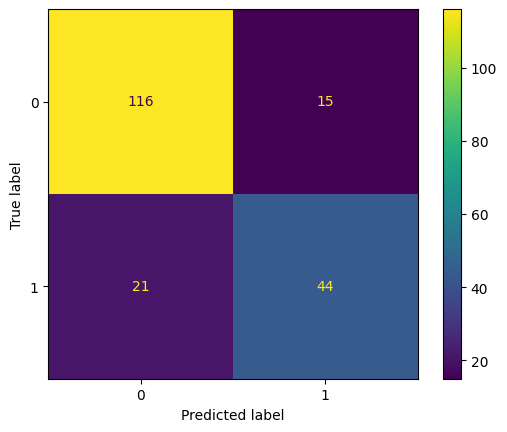

In [64]:
y_pred = df_training_info_classification.loc[BEST_MODEL_ROW,'model'].predict(dict_training_datasets[testing_datasetUsed]['x_validation'])
ConfusionMatrixDisplay.from_predictions(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)

Confidence intervals with bootstraping

In [65]:
ci_chosen_model = bootstrap_ci_binary(dict_training_datasets[testing_datasetUsed]['y_validation'].values,y_pred)

In [66]:
print_ci(ci_chosen_model)

Precision: 0.744 [0.625, 0.855]
Recall: 0.677 [0.557, 0.789]
F1: 0.708 [0.609, 0.797]
Accuracy: 0.817 [0.760, 0.872]


Hyperparameter optimization with optuna (GBC)

In [67]:
param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(50, 500),
    "learning_rate": optuna.distributions.FloatDistribution(0.001, 0.5, log=True),
    "max_depth": optuna.distributions.IntDistribution(2, 10),
    "min_samples_split": optuna.distributions.IntDistribution(2, 50),
    "min_samples_leaf": optuna.distributions.IntDistribution(1, 20),
    "subsample": optuna.distributions.FloatDistribution(0.5, 1.0),
    "max_features": optuna.distributions.CategoricalDistribution(
        ["sqrt", "log2", None]
    ),
    "loss": optuna.distributions.CategoricalDistribution(
        ["log_loss", "exponential"]
    ),
}

optuna_search = OptunaSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    random_state=42,
    refit=True,
    verbose=1
)
    
hyperparameterSearch_X = dict_training_datasets[df_training_info_classification.loc[BEST_MODEL_ROW, 'data_name']]['x_validation']
hyperparameterSearch_y = dict_training_datasets[df_training_info_classification.loc[BEST_MODEL_ROW, 'data_name']]['y_validation']

optuna_search.fit(hyperparameterSearch_X, hyperparameterSearch_y)

C:\Users\jon.diaz\AppData\Local\Temp\ipykernel_38140\2181320973.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2026-02-05 14:56:49,915] A new study created in memory with name: no-name-54069310-c590-4edb-b56f-2333c5770cf4
[I 2026-02-05 14:56:50,543] Trial 0 finished with value: 0.77867011208039 and parameters: {'n_estimators': 255, 'learning_rate': 0.17670501688542614, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 10, 'subsample': 0.6491308156825654, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 0 with value: 0.77867011208039.
[I 2026-02-05 14:56:52,035] Trial 1 finished with value: 0.7852706197882574 and parameters: {'n_estimators': 500, 'learning_rate': 0.023309157448560425, 'max_depth': 4, 'min_samples_split': 21, 'min_samples_leaf': 10, 'subsample': 0.9284839650178446, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 1 with v

OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
               estimator=GradientBoostingClassifier(random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None),
                                    'loss': CategoricalDistribution(choices=('log_loss', 'exponential')),
                                    'max_depth': IntDistribution(high=10, log...
                                    'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)),
                                    'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=50, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=50, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)},
               random_state=42, scoring='f1_macro', verbose=1)

In [68]:
print("\nBest params:", optuna_search.best_params_)
print("Best score:", optuna_search.best_score_)


Best params: {'n_estimators': 102, 'learning_rate': 0.021640514661168498, 'max_depth': 6, 'min_samples_split': 31, 'min_samples_leaf': 12, 'subsample': 0.5555036586152434, 'max_features': None, 'loss': 'exponential'}
Best score: 0.7924702328133874


In [69]:
best_model = GradientBoostingClassifier(**optuna_search.best_params_, random_state=42)
dict_best_dataset = dict_training_datasets[df_training_info_classification.loc[BEST_MODEL_ROW,'data_name']]

In [70]:
best_model.fit(dict_best_dataset['x_train'],
                         dict_best_dataset['y_train'])

best_model_y_pred = best_model.predict(dict_best_dataset['x_test'])

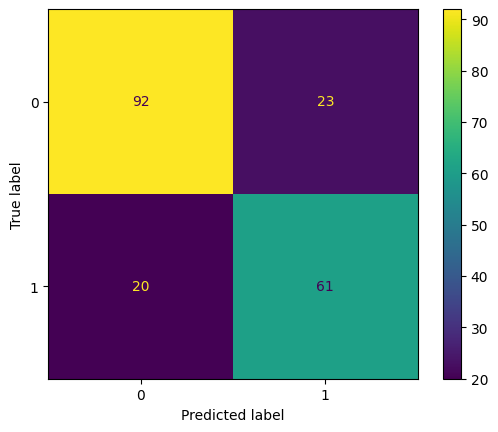

In [71]:
ConfusionMatrixDisplay.from_predictions(
    dict_best_dataset['y_test'],
    best_model_y_pred
)

In [86]:
print(classification_report(
    dict_best_dataset['y_test'], best_model_y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       115
           1       0.74      0.75      0.75        81

    accuracy                           0.79       196
   macro avg       0.78      0.79      0.78       196
weighted avg       0.79      0.79      0.79       196



In [184]:
x_train_normalized = dict_training_datasets[testing_datasetUsed]['x_train']
x_validation_normalized = dict_training_datasets[testing_datasetUsed]['x_validation']
x_test_normalized = dict_training_datasets[testing_datasetUsed]['x_test']
y_train_normalized = dict_training_datasets[testing_datasetUsed]['y_train']
y_validation_normalized = dict_training_datasets[testing_datasetUsed]['y_validation']
y_test_normalized = dict_training_datasets[testing_datasetUsed]['y_test']

x_train_regular = dict_training_datasets['regular_undersampled']['x_train']
x_validation_regular = dict_training_datasets['regular_undersampled']['x_validation']
x_test_regular = dict_training_datasets['regular_undersampled']['x_test']
y_train_regular = dict_training_datasets['regular_undersampled']['y_train']
y_validation_regular = dict_training_datasets['regular_undersampled']['y_validation']
y_test_regular = dict_training_datasets['regular_undersampled']['y_test']

path_train_test_data = PATH_DATA / 'train_test_set'

if not path_train_test_data.exists():
    path_train_test_data.mkdir(parents=True, exist_ok=True)

if UPDATE_SAVED_FILES:
    x_train_normalized.to_csv(path_train_test_data / f'x_train_{testing_datasetUsed}.csv', index=False)
    pd.concat([x_validation_normalized, x_test_normalized], ignore_index=True).to_csv(path_train_test_data / f'x_test_{testing_datasetUsed}.csv', index=False)

    y_train_normalized.to_csv(path_train_test_data / f'y_train_{testing_datasetUsed}.csv', index=False)
    pd.concat([y_validation_normalized, y_test_normalized], ignore_index=True).to_csv(path_train_test_data / f'y_test_{testing_datasetUsed}.csv', index=False)

    x_train_regular.to_csv(path_train_test_data / f'x_train_regular_undersampled.csv', index=False)
    pd.concat([x_validation_regular, x_test_regular], ignore_index=True).to_csv(path_train_test_data / f'x_test_regular_undersampled.csv', index=False)

    y_train_regular.to_csv(path_train_test_data / f'y_train_regular_undersampled.csv', index=False)
    pd.concat([y_validation_regular, y_test_regular], ignore_index=True).to_csv(path_train_test_data / f'y_test_regular_undersampled.csv', index=False)

In [74]:
if UPDATE_SAVED_FILES:
    joblib.dump(best_model, PATH_MODELS / f'{model_name}_hypertuned_{CASE_NAME}.joblib')

In [75]:
if UPDATE_SAVED_FILES:

    with open(f'parameters/{model_name}_hypertuned_{CASE_NAME}_parameters.json', 'w') as f:
        json.dump(best_model.get_params(), f)

## Model calibration

In [185]:
y_prob = best_model.predict_proba(x_test_normalized)[:,1]

In [186]:
prob_true, prob_pred = calibration_curve(y_test_normalized, y_prob, n_bins=10, strategy='quantile')

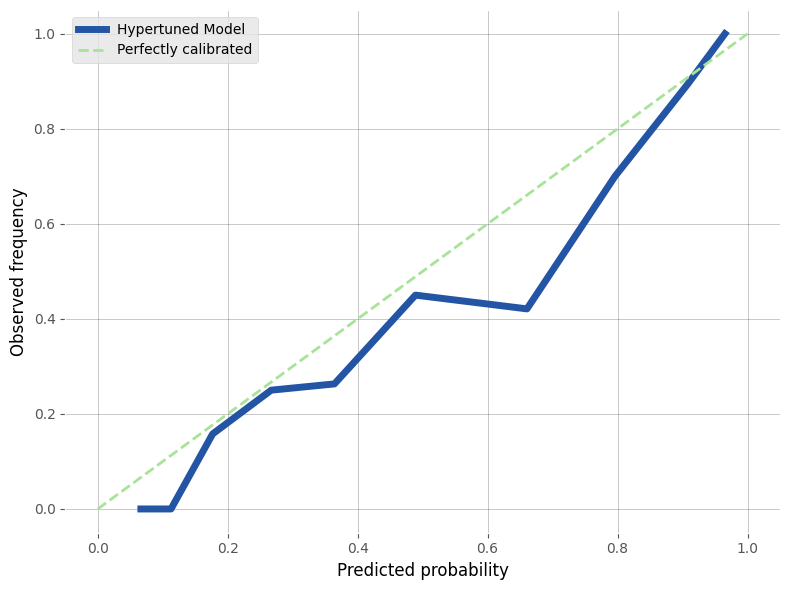

In [187]:
plt.style.use('ggplot')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, color=LIST_COLOR_PALETTE[3],  linewidth=5, label='Hypertuned Model')
plt.plot([0, 1], [0, 1], linestyle='--', color=LIST_COLOR_PALETTE[0], linewidth=2, label='Perfectly calibrated')
plt.gca().set_facecolor('white')
plt.legend()
plt.xlabel("Predicted probability", color='black')
plt.ylabel("Observed frequency", color='black')
plt.grid(True, alpha=0.3, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig(PATH_SAVE_FIGURE / f'calibration_curve.png', dpi=600)
#plt.show()

In [188]:
brier = brier_score_loss(y_test_normalized, y_prob)
print("Brier score:", brier)

Brier score: 0.13940344551911996


In [189]:
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) > 0:
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece = compute_ece(y_test_normalized, y_prob)
print("ECE:", ece)

ECE: 0.07864297701932157


## Thresholding strategy

In [190]:
precision, recall, thresholds = precision_recall_curve(y_test_normalized, y_prob)

targets = [0.90, 0.95, 0.99]
rows = []

for target in targets:
    # índice del threshold más alto que cumple el recall objetivo
    idx = np.where(recall >= target)[0][-1]
    tau = thresholds[idx]

    y_pred = (y_prob >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_normalized, y_pred).ravel()

    prec = tp / (tp + fp) if tp + fp > 0 else 0
    rec  = tp / (tp + fn) if tp + fn > 0 else 0
    f1   = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    fpr  = fp / (fp + tn)

    rows.append([target, tau, prec, rec, f1, fpr])

df_thresholds = pd.DataFrame(
    rows,
    columns=["Target Recall", "Threshold τ", "Precision", "Recall", "F1", "False Positive Rate"]
)

In [191]:
df_thresholds

Target Recall  Threshold τ  Precision    Recall        F1  \
0           0.90     0.308436   0.629310  0.901235  0.741117   
1           0.95     0.269078   0.596899  0.950617  0.733333   
2           0.99     0.163139   0.532895  1.000000  0.695279   

   False Positive Rate  
0             0.373913  
1             0.452174  
2             0.617391

In [192]:
def bootstrap_threshold_metrics(y_true, y_prob, tau, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    idx = np.arange(n)

    precs, recs, f1s, fprs = [], [], [], []

    for _ in range(n_boot):
        sample = rng.choice(idx, size=n, replace=True)
        yt = y_true[sample]
        yp = (y_prob[sample] >= tau).astype(int)

        tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()

        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec  = tp / (tp + fn) if tp + fn > 0 else 0
        f1   = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        fpr  = fp / (fp + tn) if (fp + tn) > 0 else 0

        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
        fprs.append(fpr)

    def ci(x):
        return np.mean(x), np.percentile(x, 100*alpha/2), np.percentile(x, 100*(1-alpha/2))

    return {
        "precision": ci(precs),
        "recall": ci(recs),
        "f1": ci(f1s),
        "fpr": ci(fprs)
    }


In [193]:
precision, recall, thresholds = precision_recall_curve(y_test_normalized, y_prob)

targets = [0.90, 0.95, 0.99]
rows = []

for target in targets:
    idx = np.where(recall >= target)[0][-1]
    tau = thresholds[idx]

    y_pred = (y_prob >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_normalized, y_pred).ravel()

    prec = tp / (tp + fp) if tp + fp > 0 else 0
    rec  = tp / (tp + fn) if tp + fn > 0 else 0
    f1   = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    fpr  = fp / (fp + tn)

    ci = bootstrap_threshold_metrics(y_test_normalized.values, y_prob, tau)

    rows.append([
        target,
        tau,
        f"{prec:.3f} [{ci['precision'][1]:.3f}, {ci['precision'][2]:.3f}]",
        f"{rec:.3f} [{ci['recall'][1]:.3f}, {ci['recall'][2]:.3f}]",
        f"{f1:.3f} [{ci['f1'][1]:.3f}, {ci['f1'][2]:.3f}]",
        f"{fpr:.3f} [{ci['fpr'][1]:.3f}, {ci['fpr'][2]:.3f}]"
    ])


In [194]:
df_thresholds = pd.DataFrame(
    rows,
    columns=[
        "Target Recall",
        "Threshold τ",
        "Precision (95% CI)",
        "Recall (95% CI)",
        "F1 (95% CI)",
        "False Positive Rate (95% CI)"
    ]
)

In [195]:
df_thresholds

Target Recall  Threshold τ    Precision (95% CI)       Recall (95% CI)  \
0           0.90     0.308436  0.629 [0.536, 0.718]  0.901 [0.833, 0.963]   
1           0.95     0.269078  0.597 [0.508, 0.681]  0.951 [0.899, 0.989]   
2           0.99     0.163139  0.533 [0.450, 0.614]  1.000 [1.000, 1.000]   

            F1 (95% CI) False Positive Rate (95% CI)  
0  0.741 [0.667, 0.808]         0.374 [0.284, 0.467]  
1  0.733 [0.659, 0.798]         0.452 [0.358, 0.547]  
2  0.695 [0.620, 0.761]         0.617 [0.525, 0.706]

## Moran's I 

In [197]:
df_test_data = x_test_regular.copy(deep=True)
df_test_data['length'] = df_test_data['length'].apply(lambda x: round(x,5))
df_test_data['predicted'] = best_model.predict(x_test_normalized).astype(int)
df_test_data['geometry'] = 0

In [199]:
df['length'] = df['length'].round(5)

for idx, row in df_test_data.iterrows():
    df_test_data.at[idx, 'geometry'] = df[df['length'] == row['length']]['geometry'].values[0]

C:\Users\jon.diaz\AppData\Local\Temp\ipykernel_38140\2280881448.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LINESTRING (-3.71582025 40.4058261500011, -3.7156079235716524 40.40590061057027, -3.7154611 40.40595210000001, -3.714902394573493 40.406443653016076, -3.7147796162451696 40.40655167426437, -3.7146108000000004 40.4067002)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_data.at[idx, 'geometry'] = df[df['length'] == row['length']]['geometry'].values[0]


In [200]:
# Residuo = y - p̂  (float, evita LossySetitemError)
df_test_data["residual"] = (y_test_normalized - y_prob).astype("float64")

# (opcional) error binario
df_test_data["error_bin"] = (y_test_normalized != df_test_data["predicted"]).astype(int)

In [201]:
coords = np.array([
    (geom.centroid.x, geom.centroid.y)
    for geom in df_test_data.geometry
])

In [202]:

k = 8
nn = NearestNeighbors(n_neighbors=k+1)
nn.fit(coords)

distances, indices = nn.kneighbors(coords)


In [203]:
n = len(coords)
W = np.zeros((n, n))

for i in range(n):
    for j in indices[i][1:]:   # saltamos el primero (es el propio punto)
        W[i, j] = 1

# normalizar filas
row_sums = W.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
W = W / row_sums


In [204]:
x = df_test_data["residual"].values
x_bar = x.mean()

num = 0
den = 0

for i in range(n):
    for j in range(n):
        num += W[i,j] * (x[i] - x_bar) * (x[j] - x_bar)
    den += (x[i] - x_bar)**2

I = (n / W.sum()) * (num / den)

print("Moran's I:", I)


Moran's I: -0.04179035741405686


## Best model explainability (SHAP)

In [264]:
best_model = joblib.load(PATH_MODELS / f'{model_name}_hypertuned_{CASE_NAME}.joblib')

x_train_normalized = pd.read_csv(PATH_DATA / 'train_test_set' / 'x_train_normalized_undersampled.csv')
x_test_normalized = pd.read_csv(PATH_DATA / 'train_test_set' / 'x_test_normalized_undersampled.csv')
y_train_normalized = pd.read_csv(PATH_DATA / 'train_test_set' / 'y_train_normalized_undersampled.csv')
y_test_normalized = pd.read_csv(PATH_DATA / 'train_test_set' / 'y_test_normalized_undersampled.csv')

x_train_regular = pd.read_csv(PATH_DATA / 'train_test_set' / 'x_train_regular_undersampled.csv')
x_test_regular = pd.read_csv(PATH_DATA / 'train_test_set' / 'x_test_regular_undersampled.csv')
y_train_regular = pd.read_csv(PATH_DATA / 'train_test_set' / 'y_train_regular_undersampled.csv')
y_test_regular = pd.read_csv(PATH_DATA / 'train_test_set' / 'y_test_regular_undersampled.csv')

In [274]:
df_test_data = x_test_regular.copy(deep=True)
df_test_data['length'] = df_test_data['length'].apply(lambda x: round(x,5))

df_test_data['predicted'] = best_model.predict(x_test_normalized).astype(int)

In [267]:
ci_best_model = bootstrap_ci_binary(y_test_normalized.values, best_model.predict(x_test_normalized).astype(int))

In [268]:
n_samples_shap = 500

In [269]:
# Use a small background sample for SHAP
background = shap.sample(x_train_normalized, n_samples_shap)  # 500 samples is usually fine
background['oneway'] = background['oneway'].astype(int)

# Create the explainer
explainer = shap.TreeExplainer(best_model, background)

# Compute SHAP values for all your data (or a subset)
shap_values = explainer(x_train_normalized, check_additivity=False)

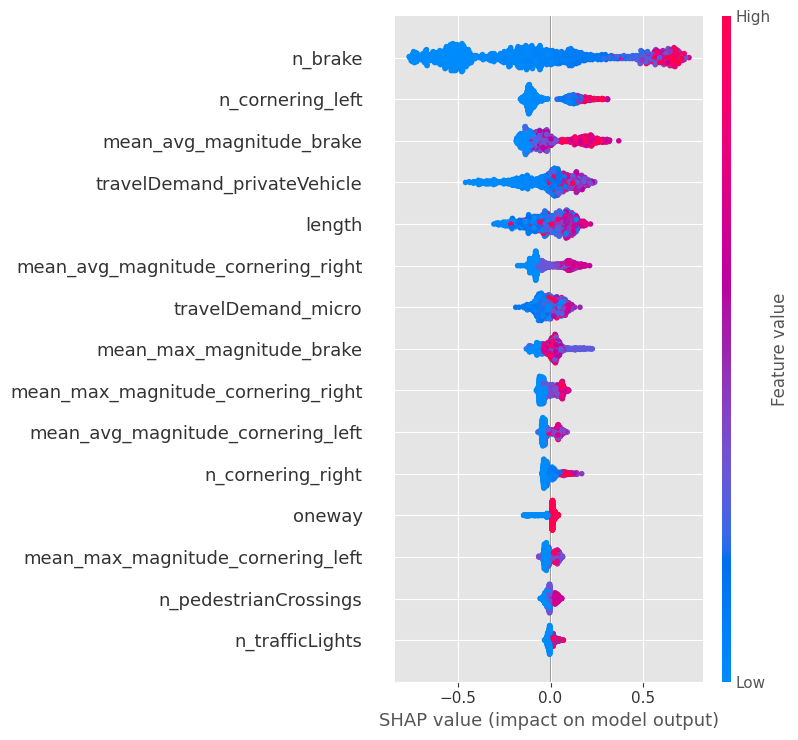

In [270]:
shap.summary_plot(shap_values[:,:], x_train_normalized, max_display=15)

## Retraining model only with relevant features

In [210]:
n_most_relevant_features = 7#6 y 7 me ha gustado. aunque igual tiene más sentido decir de eliminar el top 5 y ale. o decidir en base a la figura. hay que justificarlo bien

In [211]:
feature_importance_matrix = pd.DataFrame({
    "feature": x_test_regular.columns,
    "importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values("importance", ascending=False).set_index('feature')


In [212]:
feature_importance_matrix[:n_most_relevant_features]

importance
feature                                       
n_brake                               0.367389
n_cornering_left                      0.118064
mean_avg_magnitude_brake              0.115506
travelDemand_privateVehicle           0.112829
length                                0.086348
mean_avg_magnitude_cornering_right    0.082110
travelDemand_micro                    0.049696

In [213]:
if isinstance(best_model, RandomForestClassifier):
    trimmed_model = RandomForestClassifier(**best_model.get_params())
elif isinstance(best_model, GradientBoostingClassifier):
    trimmed_model = GradientBoostingClassifier(**best_model.get_params())
else:
    raise ValueError("Unsupported model type for trimming.")

trimmed_input_data = x_train_normalized[feature_importance_matrix.head(n_most_relevant_features).index.tolist()]

trimmed_test_data = x_test_normalized[feature_importance_matrix.head(n_most_relevant_features).index.tolist()]

In [214]:
trimmed_model.fit(trimmed_input_data,
                         y_train_normalized)

c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.021640514661168498,
                           loss='exponential', max_depth=6, min_samples_leaf=12,
                           min_samples_split=31, n_estimators=102,
                           random_state=42, subsample=0.5555036586152434)

In [215]:
trimmed_model_y_pred = trimmed_model.predict(trimmed_test_data)

In [216]:
ci_trimmed_model = bootstrap_ci_binary(
    y_test_normalized.values,
    trimmed_model_y_pred)

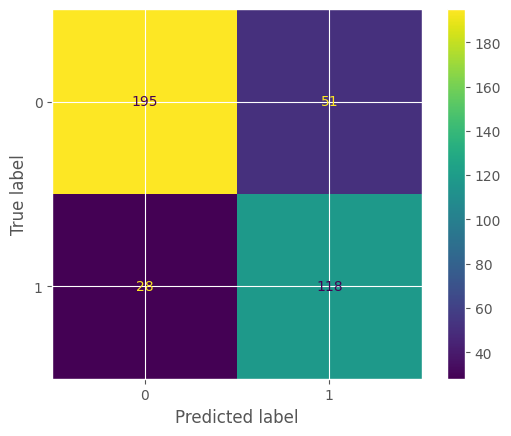

In [217]:
ConfusionMatrixDisplay.from_predictions(
    y_test_normalized,
    trimmed_model_y_pred
)

In [218]:
trimmedModel_accuracyValue = accuracy_score(y_test_normalized, trimmed_model_y_pred)
trimmedModel_precisionValue = precision_score(y_test_normalized, trimmed_model_y_pred, zero_division=0)
trimmedModel_recallValue = recall_score(y_test_normalized, trimmed_model_y_pred, zero_division=0)
trimmedModel_f1Value = f1_score(y_test_normalized, trimmed_model_y_pred, zero_division=0)

print(f"Trimmed Model Accuracy: {round(trimmedModel_accuracyValue,3)}")
print(f"Trimmed Model Precision: {round(trimmedModel_precisionValue,3)}")
print(f"Trimmed Model Recall: {round(trimmedModel_recallValue,3)}")
print(f"Trimmed Model F1-score: {round(trimmedModel_f1Value,3)}")

Trimmed Model Accuracy: 0.798
Trimmed Model Precision: 0.698
Trimmed Model Recall: 0.808
Trimmed Model F1-score: 0.749


In [219]:
# Use a small background sample for SHAP
background_trimmedModel = shap.sample(trimmed_input_data, n_samples_shap)  # 500 samples is usually fine

# Create the explainer
explainer_trimmedModel = shap.TreeExplainer(trimmed_model, background_trimmedModel)
# Compute SHAP values for all your data (or a subset)
shap_values_trimmedModel = explainer_trimmedModel(trimmed_input_data, check_additivity=False)

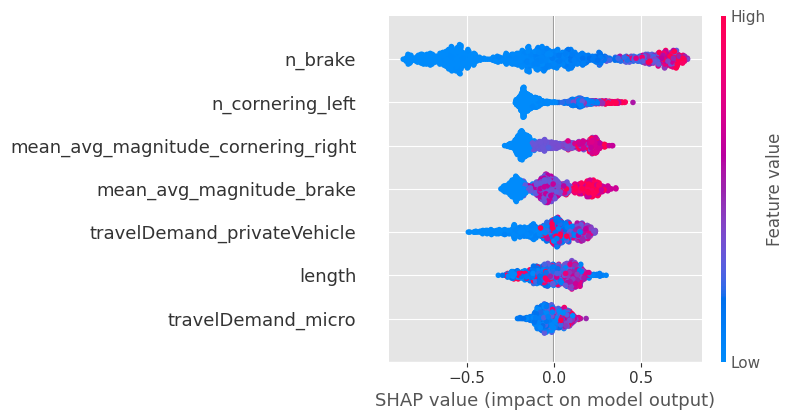

In [220]:
if isinstance(best_model, RandomForestClassifier):
    shap.summary_plot(shap_values_trimmedModel[:,:,0], trimmed_input_data, max_display=10)
else:
    shap.summary_plot(shap_values_trimmedModel[:,:], trimmed_input_data, max_display=10)

## Retraining model without most relevant features

In [221]:
feature_importance_matrix.iloc[n_most_relevant_features:].head(10)

importance
feature                                       
mean_max_magnitude_brake              0.044745
mean_max_magnitude_cornering_right    0.041050
mean_avg_magnitude_cornering_left     0.036726
n_cornering_right                     0.029197
oneway                                0.025562
mean_max_magnitude_cornering_left     0.024901
n_pedestrianCrossings                 0.019436
n_trafficLights                       0.013356
surfaceType_asphalt                   0.012575
numberOfLanes                         0.012531

In [222]:
if isinstance(best_model, RandomForestClassifier):
    trimmed_model_noRelevantFeatures = RandomForestClassifier(**best_model.get_params())
elif isinstance(best_model, GradientBoostingClassifier):
    trimmed_model_noRelevantFeatures = GradientBoostingClassifier(**best_model.get_params())
else:
    raise ValueError("Unsupported model type for trimming.")


trimmed_input_data_noRelevantFeatures = x_train_normalized[feature_importance_matrix.tail(feature_importance_matrix.shape[0] - n_most_relevant_features).index.tolist()]

trimmed_test_data_noRelevantFeatures = x_test_normalized[feature_importance_matrix.tail(feature_importance_matrix.shape[0] - n_most_relevant_features).index.tolist()]

In [223]:
trimmed_model_noRelevantFeatures.fit(trimmed_input_data_noRelevantFeatures,
                                     y_train_normalized)

c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.021640514661168498,
                           loss='exponential', max_depth=6, min_samples_leaf=12,
                           min_samples_split=31, n_estimators=102,
                           random_state=42, subsample=0.5555036586152434)

In [224]:
trimmed_model_y_pred_noRelevantFeatures = trimmed_model_noRelevantFeatures.predict(trimmed_test_data_noRelevantFeatures)

In [225]:
ci_trimmed_no_relevant_features = bootstrap_ci_binary(
    y_test_normalized.values,
    trimmed_model_y_pred_noRelevantFeatures)

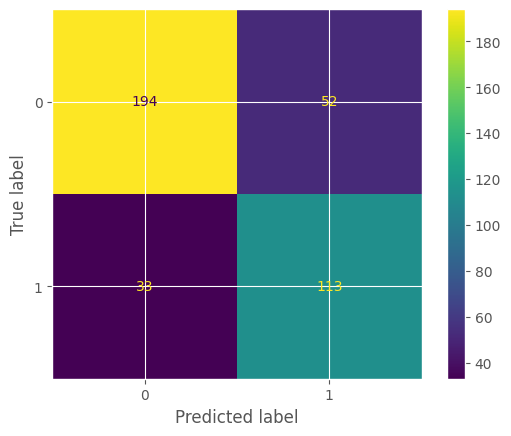

In [226]:
ConfusionMatrixDisplay.from_predictions(
    y_test_normalized,
    trimmed_model_y_pred_noRelevantFeatures
)

In [227]:
trimmedModel_noRelevantFeatures_accuracyValue = accuracy_score(y_test_normalized, trimmed_model_y_pred_noRelevantFeatures)
trimmedModel_noRelevantFeatures_precisionValue = precision_score(y_test_normalized, trimmed_model_y_pred_noRelevantFeatures, zero_division=0)
trimmedModel_noRelevantFeatures_recallValue = recall_score(y_test_normalized, trimmed_model_y_pred_noRelevantFeatures, zero_division=0)
trimmedModel_noRelevantFeatures_f1Value = f1_score(y_test_normalized, trimmed_model_y_pred_noRelevantFeatures, zero_division=0)

print(f"Trimmed Model Accuracy: {round(trimmedModel_noRelevantFeatures_accuracyValue,4)}")
print(f"Trimmed Model Precision: {round(trimmedModel_noRelevantFeatures_precisionValue,4)}")
print(f"Trimmed Model Recall: {round(trimmedModel_noRelevantFeatures_recallValue,4)}")
print(f"Trimmed Model F1-score: {round(trimmedModel_noRelevantFeatures_f1Value,4)}")

Trimmed Model Accuracy: 0.7832
Trimmed Model Precision: 0.6848
Trimmed Model Recall: 0.774
Trimmed Model F1-score: 0.7267


In [228]:
# Use a small background sample for SHAP
background_noRelevantFeatures = shap.sample(trimmed_input_data_noRelevantFeatures, n_samples_shap)  # 500 samples is usually fine
background_noRelevantFeatures['oneway'] = background_noRelevantFeatures['oneway'].astype(int)

# Create the explainer
explainer_noRelevantFeatures = shap.TreeExplainer(trimmed_model_noRelevantFeatures, background_noRelevantFeatures)
# Compute SHAP values for all your data (or a subset)
shap_values_noRelevantFeatures = explainer_noRelevantFeatures(trimmed_input_data_noRelevantFeatures, check_additivity=False)

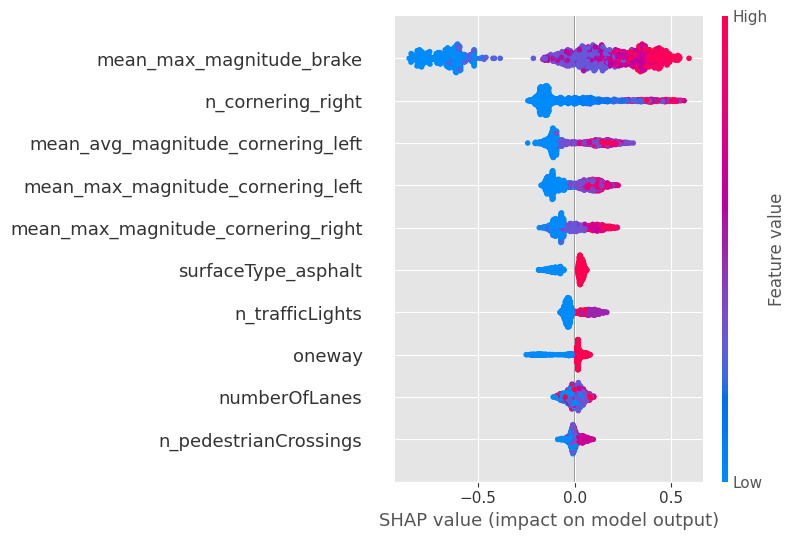

In [229]:
if isinstance(best_model, RandomForestClassifier):
    shap.summary_plot(shap_values_noRelevantFeatures[:,:,0], trimmed_input_data_noRelevantFeatures, max_display=10)
else:
    shap.summary_plot(shap_values_noRelevantFeatures[:,:], trimmed_input_data_noRelevantFeatures, max_display=10)

## Retraining model without CVD

In [230]:
list_cvd_keywords = ['brake', 'speedup', 'cornering']

In [231]:
noCVD_input_data = x_train_normalized.copy(deep=True)
noCVD_input_data = noCVD_input_data[[col for col in x_train_normalized.columns if not any(keyword in col for keyword in list_cvd_keywords)]]

noCVD_test_data = x_test_normalized.copy(deep=True)
noCVD_test_data = noCVD_test_data[[col for col in x_test_normalized.columns if not any(keyword in col for keyword in list_cvd_keywords)]]

In [232]:
if isinstance(best_model, RandomForestClassifier):
    noCVD_model = RandomForestClassifier(**best_model.get_params())
elif isinstance(best_model, GradientBoostingClassifier):
    noCVD_model = GradientBoostingClassifier(**best_model.get_params())
else:
    raise ValueError("Unsupported model type for trimming.")


noCVD_model.fit(noCVD_input_data,
                y_train_normalized)

c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.021640514661168498,
                           loss='exponential', max_depth=6, min_samples_leaf=12,
                           min_samples_split=31, n_estimators=102,
                           random_state=42, subsample=0.5555036586152434)

In [233]:
noCVD_y_pred = noCVD_model.predict(noCVD_test_data)

In [234]:
ci_noCVD = bootstrap_ci_binary(
    y_test_normalized.values,
    noCVD_y_pred)

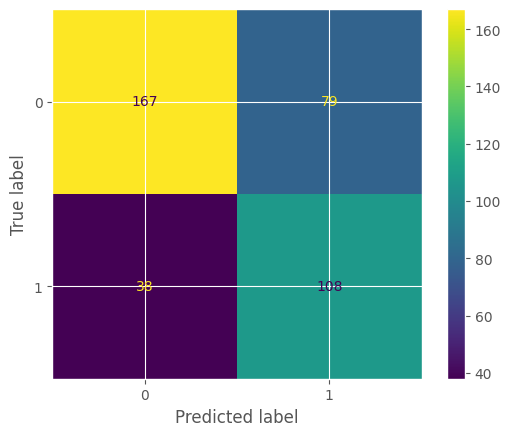

In [235]:
ConfusionMatrixDisplay.from_predictions(
    y_test_normalized,
    noCVD_y_pred
)

In [236]:
noCVD_accuracyValue = accuracy_score(y_test_normalized, noCVD_y_pred)
noCVD_precisionValue = precision_score(y_test_normalized, noCVD_y_pred, zero_division=0)
noCVD_recallValue = recall_score(y_test_normalized, noCVD_y_pred, zero_division=0)
noCVD_f1Value = f1_score(y_test_normalized, noCVD_y_pred, zero_division=0)

print(f"Trimmed Model Accuracy: {round(noCVD_accuracyValue,4)}")
print(f"Trimmed Model Precision: {round(noCVD_precisionValue,4)}")
print(f"Trimmed Model Recall: {round(noCVD_recallValue,4)}")
print(f"Trimmed Model F1-score: {round(noCVD_f1Value,4)}")

Trimmed Model Accuracy: 0.7015
Trimmed Model Precision: 0.5775
Trimmed Model Recall: 0.7397
Trimmed Model F1-score: 0.6486


In [237]:
n_samples_shap = 500

In [238]:
# Use a small background sample for SHAP
background_noCVD = shap.sample(noCVD_input_data, n_samples_shap)  # 500 samples is usually fine
background_noCVD['oneway'] = background_noCVD['oneway'].astype(int)

# Create the explainer
explainer_noCVD = shap.TreeExplainer(noCVD_model, background_noCVD)

# Compute SHAP values for all your data (or a subset)
shap_values_noCVD = explainer_noCVD(noCVD_input_data, check_additivity=False)

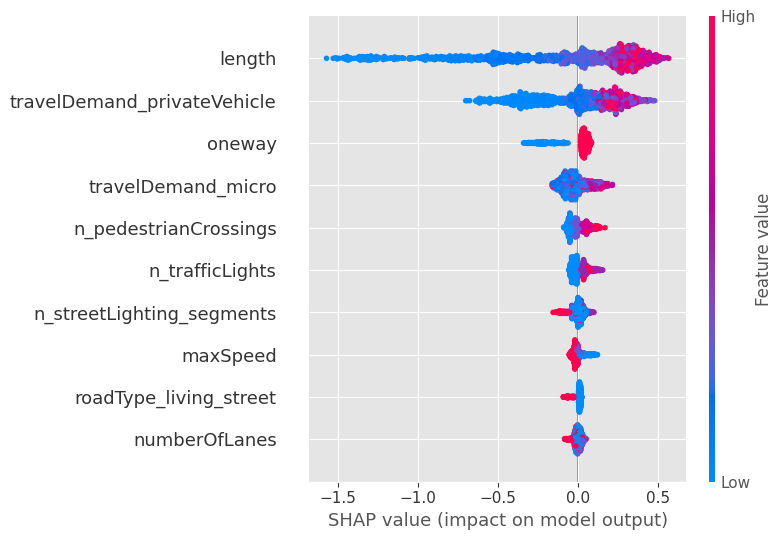

In [239]:
if isinstance(best_model, RandomForestClassifier):
    shap.summary_plot(shap_values_noCVD[:,:,0], noCVD_input_data, max_display=10)
else:
    shap.summary_plot(shap_values_noCVD[:,:], noCVD_input_data, max_display=10)

## Retraining model ONLY with CVD

CVD-only training shape: (1122, 12)
CVD-only testing  shape: (392, 12)


c:\Users\jon.diaz\Anaconda3\envs\soteria_env\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



--- CVD-Only Model Performance ---
Accuracy:  0.7934
Precision: 0.6923
Recall:    0.8014
F1-score:  0.7429


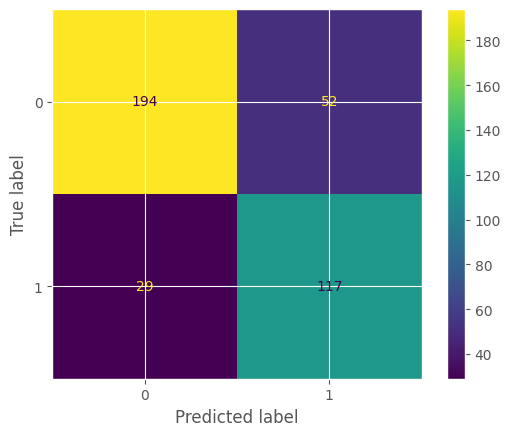

In [240]:
cvd_keywords = ['brake', 'speedup', 'cornering']

onlyCVD_input_data = x_train_normalized.copy(deep=True)
onlyCVD_input_data = onlyCVD_input_data[
    [col for col in x_train_normalized.columns if any(keyword in col for keyword in cvd_keywords)]
]

onlyCVD_test_data = x_test_normalized.copy(deep=True)
onlyCVD_test_data = onlyCVD_test_data[
    [col for col in x_test_normalized.columns if any(keyword in col for keyword in cvd_keywords)]
]

print("CVD-only training shape:", onlyCVD_input_data.shape)
print("CVD-only testing  shape:", onlyCVD_test_data.shape)

# -----------------------------
# 2. Recreate model using best hyperparameters
# -----------------------------
if isinstance(best_model, RandomForestClassifier):
    onlyCVD_model = RandomForestClassifier(**best_model.get_params())
elif isinstance(best_model, GradientBoostingClassifier):
    onlyCVD_model = GradientBoostingClassifier(**best_model.get_params())
else:
    raise ValueError("Unsupported model type for trimming.")

# -----------------------------
# 3. Train the model
# -----------------------------
onlyCVD_model.fit(onlyCVD_input_data, y_train_normalized)

# -----------------------------
# 4. Predictions
# -----------------------------
onlyCVD_y_pred = onlyCVD_model.predict(onlyCVD_test_data)

# -----------------------------
# 5. Confusion Matrix
# -----------------------------
ConfusionMatrixDisplay.from_predictions(
    y_test_normalized, onlyCVD_y_pred
)

# -----------------------------
# 6. Metrics
# -----------------------------
onlyCVD_accuracy  = accuracy_score(y_test_normalized, onlyCVD_y_pred)
onlyCVD_precision = precision_score(y_test_normalized, onlyCVD_y_pred, zero_division=0)
onlyCVD_recall    = recall_score(y_test_normalized, onlyCVD_y_pred, zero_division=0)
onlyCVD_f1        = f1_score(y_test_normalized, onlyCVD_y_pred, zero_division=0)

print("\n--- CVD-Only Model Performance ---")
print(f"Accuracy:  {onlyCVD_accuracy:.4f}")
print(f"Precision: {onlyCVD_precision:.4f}")
print(f"Recall:    {onlyCVD_recall:.4f}")
print(f"F1-score:  {onlyCVD_f1:.4f}")

# -----------------------------
# 7. SHAP analysis for CVD-only model
# -----------------------------
n_samples_shap = 500

# Background sample
background_CVD = shap.sample(onlyCVD_input_data, n_samples_shap)

# Explainer
explainer_CVD = shap.TreeExplainer(onlyCVD_model, background_CVD)

# SHAP values
shap_values_CVD = explainer_CVD(onlyCVD_input_data, check_additivity=False)



In [241]:
print("\n--- CVD-Only Model Performance ---")
print(f"Accuracy:  {onlyCVD_accuracy:.4f}")
print(f"Precision: {onlyCVD_precision:.4f}")
print(f"Recall:    {onlyCVD_recall:.4f}")
print(f"F1-score:  {onlyCVD_f1:.4f}")


--- CVD-Only Model Performance ---
Accuracy:  0.7934
Precision: 0.6923
Recall:    0.8014
F1-score:  0.7429


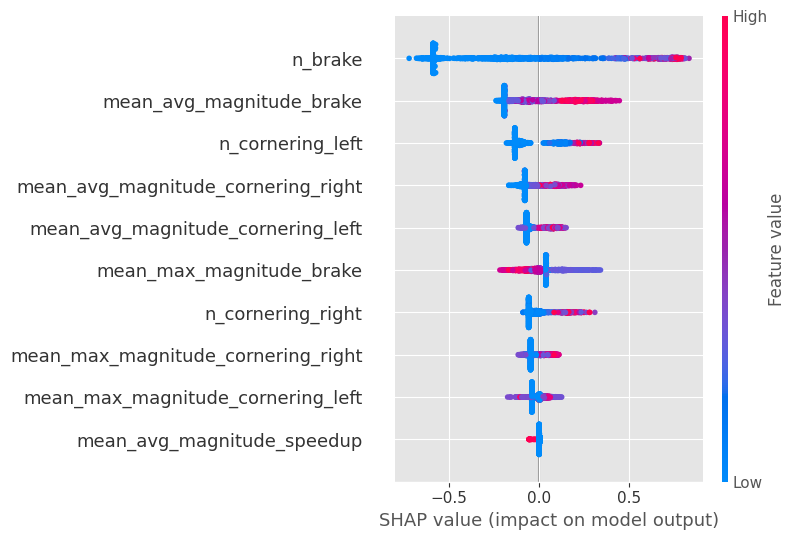

In [242]:
# Summary plot (RF vs GBC)
if isinstance(best_model, RandomForestClassifier):
    shap.summary_plot(shap_values_CVD[:, :, 0], onlyCVD_input_data, max_display=10)
else:
    shap.summary_plot(shap_values_CVD[:, :], onlyCVD_input_data, max_display=10)


# Final result tables

## Experimentation

### Methods

In [243]:
def prettyfy_result_table(df: pd.DataFrame, score_columns: list) -> pd.DataFrame:
    df.index.names = ['Preprocessing', 'Model']
    df = df.reorder_levels(['Model','Preprocessing'], axis=0)

    #score_columns = [col.replace('_', ' ').title() for col in score_columns]

    df.columns = [col.replace('_', ' ').title() if col not in ['mse', 'mae'] else col.upper() for col in df.columns]

    preprocessing_names_mapping = {
        'regular': 'No preprocessing',
        'regular_resampled': 'Overesampling',
        'regular_resampled_expanded': 'Expanded Overesampling',
        'regular_resampled_SMOTE': 'SMOTE',
        'regular_undersampled': 'Undersampling',
        'normalized': 'Normalization',
        'normalized_resampled': 'Normalization + Overesampling',
        'normalized_resampled_expanded': 'Normalization + Expanded Overesampling',
        'normalized_resampled_SMOTE': 'Normalization + SMOTE',
        'normalized_undersampled': 'Normalization + Undersampling'
    }

    df.rename(index=preprocessing_names_mapping, inplace=True)

    df.rename(index=lambda x: x.replace('Classifier', ''), inplace=True)
    df.rename(index=lambda x: x.replace('Regressor', ''), inplace=True)

    df = df.reset_index()

    return df

In [244]:
def obtain_result_table(df: pd.DataFrame, data_preprocessing_target: str, target_scores: list, n_topResults: int = 5) -> pd.DataFrame:
    processed_df = df[(df['data_preprocessing'] == data_preprocessing_target) ].drop(columns = ['model']).copy(deep=True)

    processed_df = processed_df.set_index(['data_name', 'model_name'])[target_scores].sort_values(by=(target_scores[0]), ascending=False)

    #processed_df = processed_df.droplevel(0, axis=1)
    processed_df.columns.name = None
    processed_df = processed_df.head(n_topResults)

    for col in processed_df.columns:
        processed_df[col] = processed_df[col].apply(lambda x: round(x,3))

    return prettyfy_result_table(processed_df, target_scores)

### Regression

In [245]:
regression_baseline = df_training_info_regression[
                                (df_training_info_regression['data_preprocessing'] == 'regression')&
                                (df_training_info_regression['data_name'] == 'regular') &
                                (df_training_info_regression['target_column'] == 'total_accidents')
                                ].sort_values(by='score_r2', ascending = False).iloc[0]
regression_baseline

model                 (DecisionTreeRegressor(max_features=1.0, rando...
model_name                                        RandomForestRegressor
data_name                                                       regular
score_r2                                                       0.313959
mae                                                            0.642105
mse                                                            1.278434
data_preprocessing                                           regression
target_column                                           total_accidents
Name: 24, dtype: object

In [246]:
df_result_comparison_regression = obtain_result_table(df_training_info_regression, 'regression', ['score_r2', 'mae', 'mse'], n_topResults=5)

if UPDATE_SAVED_FILES:
    df_result_comparison_regression.to_csv('results/df_result_comparison_regression.csv', index=False)
df_result_comparison_regression = pd.concat([df_result_comparison_regression, pd.DataFrame({
        'Model' : [regression_baseline['model_name'].replace('Regressor','')],
        'Preprocessing': ['No preprocessing'],
        'Score R2': [round(regression_baseline['score_r2'],3)],
        'MAE': [round(regression_baseline['mae'],3)],
        'MSE': [round(regression_baseline['mse'],3)]
    })], ignore_index=True)


df_result_comparison_regression

Model                           Preprocessing  Score R2    MAE  \
0  RandomForest           Normalization + Overesampling     0.433  0.422   
1  RandomForest                           Overesampling     0.400  0.439   
2           SVR           Normalization + Overesampling     0.391  0.426   
3           SVR  Normalization + Expanded Overesampling     0.387  0.419   
4           SVR                  Expanded Overesampling     0.376  0.416   
5  RandomForest                        No preprocessing     0.314  0.642   

     MSE  
0  0.607  
1  0.642  
2  0.652  
3  0.656  
4  0.668  
5  1.278

### Classification

In [247]:
df_result_comparison_categorical = obtain_result_table(df_training_info_classification, 'categorical', ['recall', 'precision', 'accuracy'], n_topResults=5)
if UPDATE_SAVED_FILES:
    df_result_comparison_categorical.to_csv('results/df_result_comparison_categorical.csv', index=False)
df_result_comparison_categorical

Model                           Preprocessing  Recall  Precision  \
0  RandomForest           Normalization + Overesampling   0.801      0.678   
1  RandomForest                           Normalization   0.801      0.713   
2  RandomForest                  Expanded Overesampling   0.796      0.719   
3  RandomForest                        No preprocessing   0.791      0.660   
4           XGB  Normalization + Expanded Overesampling   0.786      0.745   

   Accuracy  
0     0.801  
1     0.801  
2     0.796  
3     0.791  
4     0.786

### Binary classification

In [248]:
df_training_info_classification[
                                (df_training_info_classification['data_preprocessing'] == 'binary')&
                                (df_training_info_classification['data_name'] == 'regular') &
                                (df_training_info_classification['target_column'] == 'total_accidents')
                                ].sort_values(by='recall', ascending = False).iloc[0]

model                 SVC(class_weight='balanced', probability=True)
model_name                                                       SVC
data_name                                                    regular
accuracy                                                    0.795918
f1                                                          0.714286
precision                                                   0.666667
recall                                                      0.769231
data_preprocessing                                            binary
target_column                                        total_accidents
Name: 32, dtype: object

In [249]:
best_binary_model_info = df_training_info_classification.loc[BEST_MODEL_ROW]

In [250]:
df_result_comparison_binary = obtain_result_table(df_training_info_classification, 'binary', ['recall', 'precision', 'accuracy'], n_topResults=5)

if UPDATE_SAVED_FILES:
    df_result_comparison_binary.to_csv('results/df_result_comparison_binary.csv', index=False)

df_result_comparison_binary

Model                  Preprocessing  Recall  Precision  \
0      RandomForest                  Undersampling   0.875      0.522   
1      RandomForest  Normalization + Undersampling   0.850      0.515   
2               SVC               No preprocessing   0.825      0.569   
3      RandomForest                  Undersampling   0.815      0.679   
4  GradientBoosting                  Undersampling   0.815      0.654   

   Accuracy  
0     0.811  
1     0.806  
2     0.837  
3     0.811  
4     0.796

## Confidence Intervals

In [251]:
print_ci(ci_best_model)

Precision: 0.690 [0.623, 0.759]
Recall: 0.795 [0.730, 0.860]
F1: 0.738 [0.685, 0.792]
Accuracy: 0.790 [0.753, 0.832]


In [252]:
print_ci(ci_trimmed_model)

Precision: 0.697 [0.631, 0.766]
Recall: 0.809 [0.745, 0.872]
F1: 0.748 [0.696, 0.801]
Accuracy: 0.798 [0.758, 0.837]


In [253]:
print_ci(ci_trimmed_no_relevant_features)

Precision: 0.684 [0.616, 0.754]
Recall: 0.776 [0.709, 0.841]
F1: 0.726 [0.671, 0.778]
Accuracy: 0.783 [0.742, 0.821]


In [254]:
print_ci(ci_noCVD)

Precision: 0.577 [0.505, 0.650]
Recall: 0.740 [0.667, 0.809]
F1: 0.648 [0.586, 0.707]
Accuracy: 0.701 [0.656, 0.747]


## Confusion Matrixes

In [255]:
df = dict_edge_datasets[testing_dataPreprocessing]

dict_training_datasets = {
            'regular' : base_trainTest_split(df, testing_targetColumn, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'regular_resampled' : resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'regular_resampled_expanded' : resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'regular_resampled_SMOTE' : resample_data_SMOTE(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'regular_undersampled' : under_resample_data(df, target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),

            'normalized' : base_trainTest_split(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), testing_targetColumn, LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
            'normalized_resampled' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=None),
            'normalized_resampled_expanded' : resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_samples=5000),
            'normalized_resampled_SMOTE' : resample_data_SMOTE(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns, n_neighbours = 4),
            'normalized_undersampled' : under_resample_data(normalize_data(df, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns), target_column=testing_targetColumn, exclude_columns=LIST_EXCLUDED_COLUMNS_ML + list_extra_excluded_columns),
}

Precision: 0.312
Recall: 0.975
Accuracy: 0.556
----
Precision: 0.515
Recall: 0.85
Accuracy: 0.806
----
Precision: 0
Recall: 0.0
Accuracy: 0.796
----
Precision: 0.312
Recall: 0.975
Accuracy: 0.556
----
Precision: 0.315
Recall: 0.975
Accuracy: 0.561
----


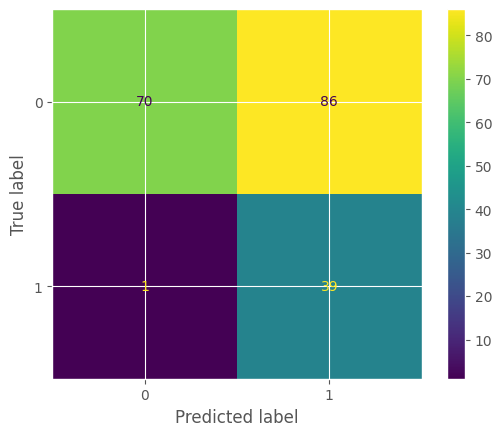

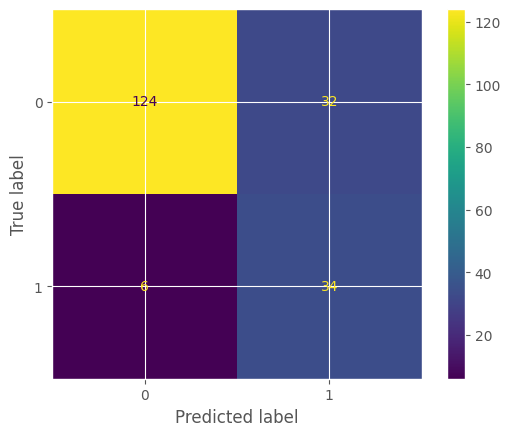

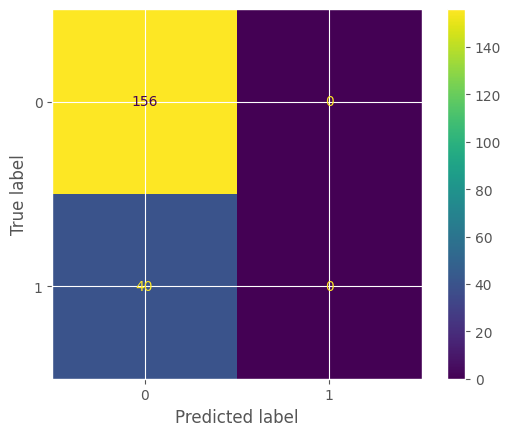

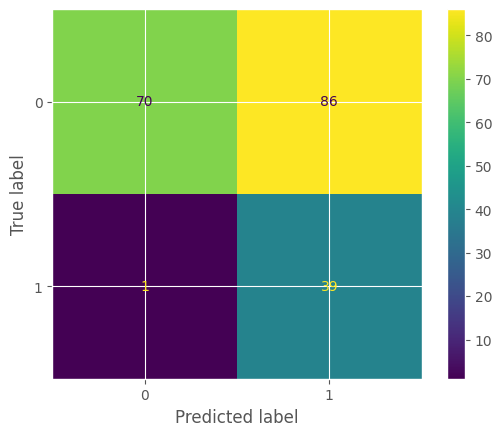

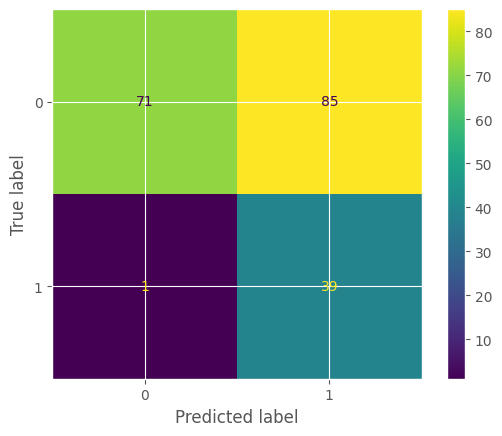

In [256]:
list_cases_to_evaluate = [0,1,2,3,4]

for case_row in list_cases_to_evaluate:
    testing_targetColumn = df_training_info_classification.loc[case_row, 'target_column']
    testing_datasetUsed = df_training_info_classification.loc[case_row, 'data_name']
    testing_dataPreprocessing = df_training_info_classification.loc[case_row, 'data_preprocessing']

    y_pred = df_training_info_classification.loc[case_row,'model'].predict(dict_training_datasets[testing_datasetUsed]['x_validation'])

    true_positives = confusion_matrix(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)[1,1]
    true_negatives = confusion_matrix(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)[0,0]
    false_positives = confusion_matrix(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)[0,1]
    false_negatives = confusion_matrix(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)[1,0]


    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score_value = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    print(f"Precision: {round(precision,3)}")
    print(f"Recall: {round(recall,3)}")
    print(f"Accuracy: {round(accuracy,3)}")
    print("----")

    ConfusionMatrixDisplay.from_predictions(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)

Accuracy: 0.8061
F1-score: 0.6415
Precision: 0.5152
Recall: 0.85


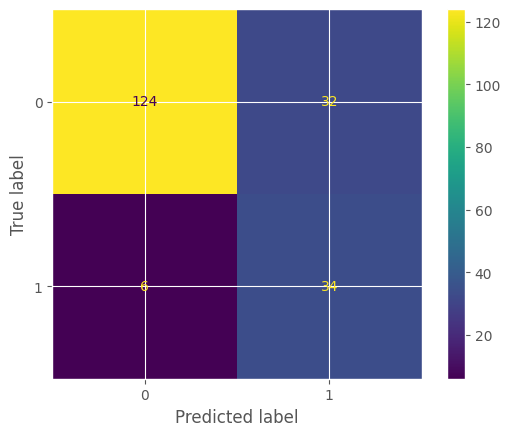

In [257]:
second_best_row = 1

testing_targetColumn = df_training_info_classification.loc[second_best_row, 'target_column']
testing_datasetUsed = df_training_info_classification.loc[second_best_row, 'data_name']
testing_dataPreprocessing = df_training_info_classification.loc[second_best_row, 'data_preprocessing']
print(f"Accuracy: {round(df_training_info_classification.loc[second_best_row, 'accuracy'],4)}")
print(f"F1-score: {round(df_training_info_classification.loc[second_best_row, 'f1'],4)}")
print(f"Precision: {round(df_training_info_classification.loc[second_best_row, 'precision'],4)}")
print(f"Recall: {round(df_training_info_classification.loc[second_best_row, 'recall'],4)}")

y_pred = df_training_info_classification.loc[second_best_row,'model'].predict(dict_training_datasets[testing_datasetUsed]['x_validation'])
ConfusionMatrixDisplay.from_predictions(dict_training_datasets[testing_datasetUsed]['y_validation'], y_pred)

## Hyperparameter tunning

In [258]:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.021640514661168498,
 'loss': 'exponential',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 12,
 'min_samples_split': 31,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 102,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.5555036586152434,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [259]:
hypertunedModel_precision = precision_score(dict_best_dataset['y_test'], best_model_y_pred, zero_division=0)
hypertunedModel_recall = recall_score(dict_best_dataset['y_test'], best_model_y_pred, zero_division=0)
hypertunedModel_f1 = f1_score(dict_best_dataset['y_test'], best_model_y_pred, zero_division=0)
hypertunedModel_accuracy = accuracy_score(dict_best_dataset['y_test'], best_model_y_pred)

print(f"Hypertuned Model Precision: {round(hypertunedModel_precision,3)}")
print(f"Hypertuned Model Recall: {round(hypertunedModel_recall,3)}")
print(f"Hypertuned Model F1-score: {round(hypertunedModel_f1,3)}")
print(f"Hypertuned Model Accuracy: {round(hypertunedModel_accuracy,3)}")

Hypertuned Model Precision: 0.726
Hypertuned Model Recall: 0.753
Hypertuned Model F1-score: 0.739
Hypertuned Model Accuracy: 0.781


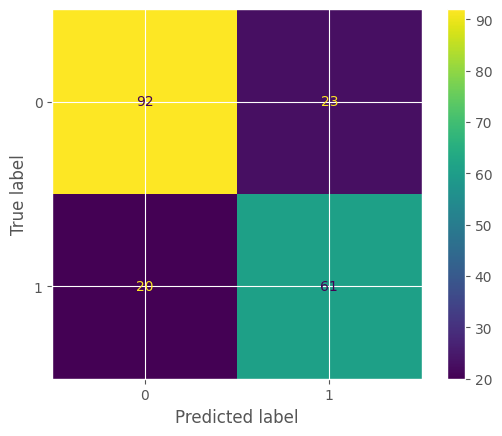

In [260]:
ConfusionMatrixDisplay.from_predictions(
    dict_best_dataset['y_test'],
    best_model_y_pred
)

## Explainability

In [276]:
readability_rename_dict = {
    "oneway": "One-way",
    "length": "Length",
    "n_trafficLights": "Traffic Lights",
    "n_giveWaySignal": "Give Way Signal",
    "n_stopSignal": "Stop Signal",
    "n_pedestrianCrossings": "Pedestrian Crossing",
    "n_cyclingPath": "Cycling Path",
    "n_cycleParking": "Cycle Parking",
    "n_parkingLeft": "Parking - Left",
    "n_parkingRight": "Parking - Right",
    "n_streetLighting_segments": "Street Lighting",
    "p_pTStop": "P PT Stop",

    # Road types
    "roadType_tertiary": "Road Type - Tertiary",
    "roadType_residential": "Road Type - Residential",
    "roadType_primary": "Road Type - Primary",
    "roadType_living_street": "Road Type - Living Street",
    "roadType_pedestrian": "Road Type - Pedestrian",
    "roadType_secondary": "Road Type - Secondary",
    "roadType_primary_link": "Road Type - Primary link",
    "roadType_service": "Road Type - Service",
    "roadType_secondary_link": "Road Type - Secondary link",
    "roadType_tertiary_link": "Road Type - Tertiary link",

    # Surface types
    "surfaceType_asphalt": "Surface Type - Asphalt",
    "surfaceType_sett": "Surface Type - Sett",
    "surfaceType_paving_stones": "Surface Type - Paving Stones",
    "surfaceType_paving_stones:20": "Surface Type - Paving Stones:20",
    "surfaceType_cobblestone": "Surface Type - Cobblestone",
    "surfaceType_paving_stones:30": "Surface Type - Paving Stones:30",
    "surfaceType_unhewn_cobblestone": "Surface Type - Unhewn Cobblestone",
    "surfaceType_paved": "Surface Type - Paved",
    "numberOfLanes": "Number of Lanes",
    "maxSpeed": "Max. Speed",

    # Travel demand
    "travelDemand_micro": "AADT - Micromobility",
    "travelDemand_privateVehicle": "AADT - Private Vehicle",

    # Cornering right
    "n_cornering_right": "Cornering Right - Count",
    "mean_avg_magnitude_cornering_right": "Cornering Right - Avg. Mag.",
    "mean_max_magnitude_cornering_right": "Cornering Right - Max. Mag.",

    # Cornering left
    "n_cornering_left": "Cornering Left - Count",
    "mean_avg_magnitude_cornering_left": "Cornering Left - Avg. Mag.",
    "mean_max_magnitude_cornering_left": "Cornering Left - Max. Mag.",

    # Brake
    "n_brake": "Brake - Count",
    "mean_avg_magnitude_brake": "Brake - Avg. Mag.",
    "mean_max_magnitude_brake": "Brake - Max. Mag.",

    # Speedup
    "n_speedup": "Speedup - Count",
    "mean_avg_magnitude_speedup": "Speedup - Avg. Mag.",
    "mean_max_magnitude_speedup": "Speedup - Max. Mag."
}


In [277]:
def save_and_display_shap_summary(shap_values, input_data, figure_name: str, max_display: int = 15, cmap: str = None):
    if cmap is None:
        shap.summary_plot(shap_values[:,:], input_data, max_display=max_display,  show=False, title="")
    else:
        shap.summary_plot(shap_values[:,:], input_data, max_display=max_display,  show=False, title="", cmap=cmap)
    plt.title(None)
    plt.xlabel(None)
    plt.savefig(os.path.join(PATH_SAVE_FIGURE, figure_name), bbox_inches='tight', dpi=300)
    plt.show()    

### Hypertuned model

In [278]:
shap_values.feature_names = [readability_rename_dict.get(feat, feat) for feat in shap_values.feature_names]

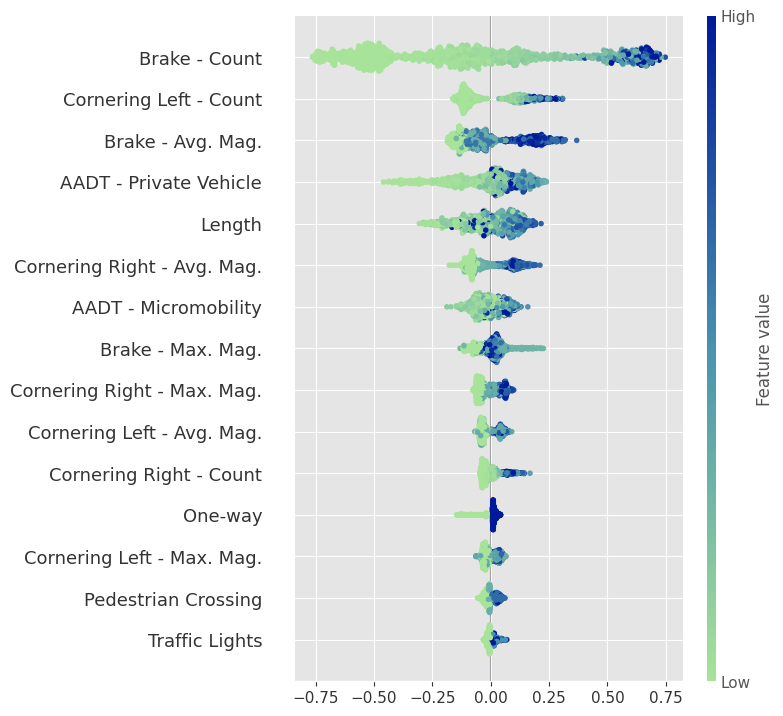

In [279]:
figure_name_hypertunedSHAP = 'shapHypertuned.png'

save_and_display_shap_summary(shap_values, x_train_normalized, figure_name_hypertunedSHAP, max_display=15, cmap=CMAP_SHAP)

### Hypertuned model without 5 most relevant chracteristics

In [280]:
shap_values_noRelevantFeatures.feature_names = [readability_rename_dict.get(feat, feat) for feat in shap_values_noRelevantFeatures.feature_names]

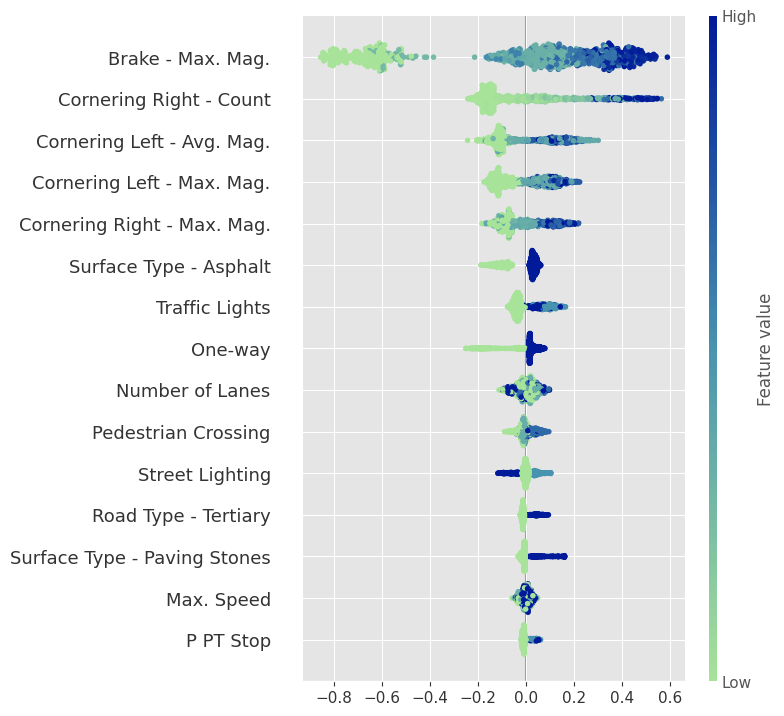

In [281]:
figure_name_hypertunedTrimmedSHAP = 'shapHypertuned_noRelevantFeatures.png'

save_and_display_shap_summary(shap_values_noRelevantFeatures, trimmed_input_data_noRelevantFeatures, figure_name_hypertunedTrimmedSHAP, max_display=15, cmap=CMAP_SHAP)

### Hypertuned model without CVD

In [282]:
shap_values_noCVD.feature_names = [readability_rename_dict.get(feat, feat) for feat in shap_values_noCVD.feature_names]

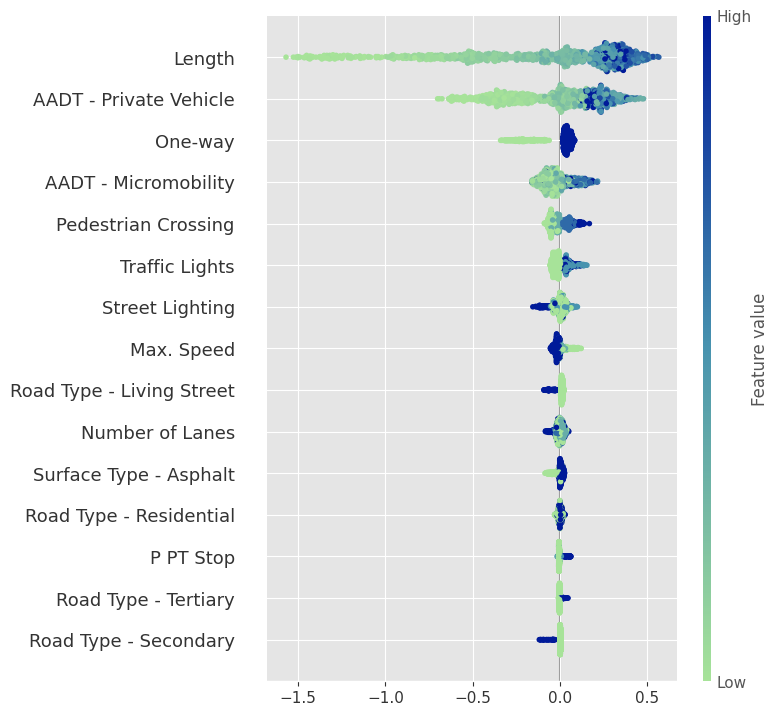

In [283]:
figure_name_hypertunedNoCVD_SHAP = 'shapHypertuned_noCVD.png'

save_and_display_shap_summary(
    shap_values_noCVD,
    noCVD_input_data,
    figure_name_hypertunedNoCVD_SHAP,
    max_display=15,
    cmap=CMAP_SHAP
)


### Hypertuning comparison

In [284]:
df_hypertunudedStatsComparison = pd.DataFrame(
    {
        'Case': ['Hypertuned Model', f'Top {n_most_relevant_features} features only', f'Without top {n_most_relevant_features} features', 'Without CVD features'],
        'Precision': [round(hypertunedModel_precision,3), round(trimmedModel_precisionValue,3), round(trimmedModel_noRelevantFeatures_precisionValue,3), round(noCVD_precisionValue,3)],
        'Recall': [round(hypertunedModel_recall,3), round(trimmedModel_recallValue,3), round(trimmedModel_noRelevantFeatures_recallValue,3), round(noCVD_recallValue,3)],
        'F1-score': [round(hypertunedModel_f1,3), round(trimmedModel_f1Value,3), round(trimmedModel_noRelevantFeatures_f1Value,3), round(noCVD_f1Value,3)],
        'Accuracy': [round(hypertunedModel_accuracy,3), round(trimmedModel_accuracyValue,3), round(trimmedModel_noRelevantFeatures_accuracyValue,3), round(noCVD_accuracyValue,3)]
    }
)

df_hypertunudedStatsComparison

Case  Precision  Recall  F1-score  Accuracy
0        Hypertuned Model      0.726   0.753     0.739     0.781
1     Top 7 features only      0.698   0.808     0.749     0.798
2  Without top 7 features      0.685   0.774     0.727     0.783
3    Without CVD features      0.578   0.740     0.649     0.702